In [12]:
#######################
##  Library Imports  ##
#######################
import numpy as np
import h5py as h5
import sys
import os
from numba import njit
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = 'Computer Modern Roman'
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getopt
from itertools import zip_longest
import multiprocessing as mprocs
import time as TIME
from subprocess import Popen, PIPE
from matplotlib.pyplot import cm
from functions import tc, import_data, sim_data, import_data, import_spectra_data, import_post_processing_data

## Helper Functions

In [13]:
def spectra_accum(spec):
    spec_accum = np.empty_like(spec)
    spec_accum[0] = spec[0]
    for i in range(1, spec.shape[0]):
        spec_accum[i] = spec[i]
        spec_accum[i] += spec_accum[i - 1]
        
    return spec_accum

def neg_k_search(k, sector):
    n     = sector.shape[-1]
    x     = False
    indx  = np.inf
    neg_k = k
    
    for i in range(n):
        if np.allclose(-k, sector[:, i]):
            x     = True
            indx  = i
            neg_k = sector[:, i]
        else:
            continue

    return x, indx, neg_k

def pos_k_search(k, sector):
    n     = sector.shape[-1]
    x     = False
    indx  = np.inf
    pos_k = None
    
    for i in range(n):
        if np.allclose(k, sector[:, i]):
            x     = True
            indx  = i
            pos_k = sector[:, i]
        else:
            continue
        
    if x == False:
        pos_k = k
    return x, indx, pos_k

def k_search(k, k_list):    
    n     = k_list.shape[-1]
    x     = False
    indx  = np.inf
    pos_k = None
    
    for i in range(n):
        if np.allclose(k, k_list[:, i]):
            x     = True
            indx  = i
            pos_k = k_list[:, i]
        else:
            continue
        
    if x == False:
        pos_k = k
    return x, indx, pos_k

## Read in Data

In [46]:
data = "DECAY"
# data = "MAX_PALIN"
# data = "EXTRM_ENS"

N_loc = 32
k_frac = 0.75
num_k3_sec = 24
num_k1_sec = 24

In [47]:
if data == "DECAY":
    in_dir = "../Data/Sync/SIM_DATA_NAVIER_RK4_FULL_N[{},{}]_T[0-50]_NU[0.000000]_CFL[0.90]_u0[DECAY_TURB_ALT]_TAG[Sync-Test]/".format(int(N_loc), int(N_loc))
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Test-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
elif data == "MAX_PALIN":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.001000]_CFL[0.90]_u0[MAX_PALIN]_TAG[Max-Palin-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Max-Palin-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
elif data == "EXTRM_ENS":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.000010]_CFL[0.90]_u0[EXTRM_ENS]_TAG[Extrm-Enst-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Extrm-Enst-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)


Preparing real space vorticity... Finished!
0
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[-inf -inf -inf -inf -inf -inf -inf -inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 

/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


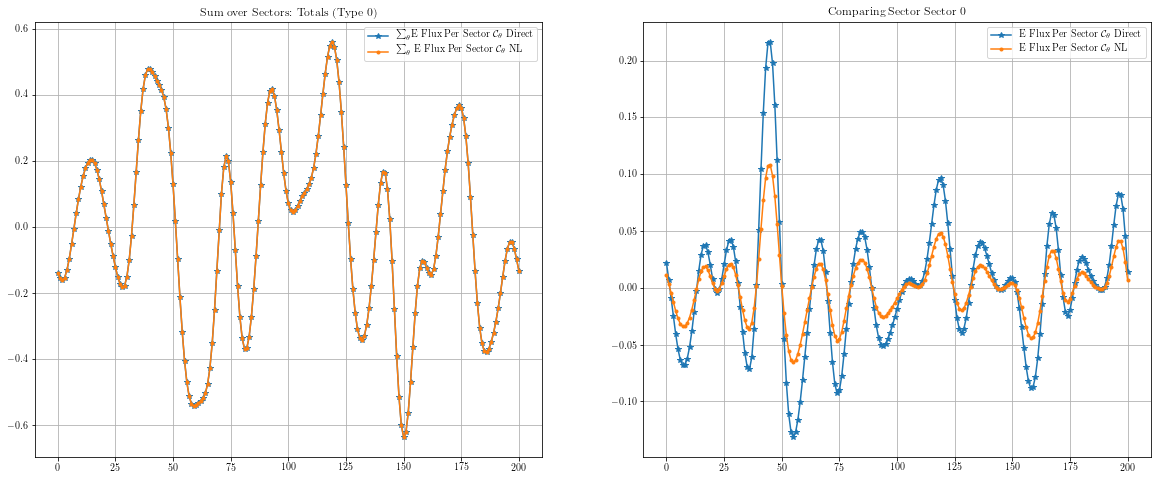

In [48]:
# -----------------------------------------
# # --------  Read In data
# -----------------------------------------
## Read in simulation parameters
sys_vars = sim_data(in_dir)

## Read in solver data
run_data = import_data(in_dir, sys_vars)

## Read in spectra data
spec_data = import_spectra_data(in_dir, sys_vars)

## Read in post processing data
post_data = import_post_processing_data(post_file_path, sys_vars, 'file')


const_fac_sector = 4.0 * np.pi**2 
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

theta = 0 #int(post_data.num_sect // 2)
print(theta)

print(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
print(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) / post_data.enst_flux_test[:, 0])

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, '*-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) * 2, '.-')
# ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '--')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$ Direct (Test)"])

theta = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac_sector * norm_fac, '*-')
ax1.plot(post_data.enst_flux_C_theta[:, theta], '.-')
ax1.set_title(r"Comparing Sector Sector {}".format(theta))
ax1.grid()
ax1.legend([r"E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$"])


plt.show()

In [34]:
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[{},{}]_SECTORS[{},{}]_KFRAC[{:0.2f}].h5'.format(int(N_loc), int(N_loc), int(1), int(1), k_frac)) as f:
    num_wv_1 = f["NumWavevectors"][:, :]
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_1 = np.zeros((1, 1, 16, np.amax(num_wv_1)))
    for a in range(1):
        for l in range(1):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wv_1[a, l]):
                    wv_1[a, l, k, n] = tmp_arr[k, n]
                    
                    
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[{},{}]_SECTORS[{},{}]_KFRAC[{:0.2f}].h5'.format(int(N_loc), int(N_loc), int(num_k3_sec), int(1), k_frac)) as f:
    num_wv_4 = f["NumWavevectors"][:, :]
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_4 = np.zeros((num_k3_sec, 1, 16, np.amax(num_wv_4)))
    for a in range(num_k3_sec):
        for l in range(1):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wv_4[a, l]):
                    wv_4[a, l, k, n] = tmp_arr[k, n]
                    
                    
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[{},{}]_SECTORS[{},{}]_KFRAC[{:0.2f}].h5'.format(int(N_loc), int(N_loc), int(num_k3_sec), int(num_k1_sec), k_frac)) as f:
    num_wv_2 = f["NumWavevectors"][:, :]
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_2 = np.zeros((num_k3_sec, num_k1_sec, 16, np.amax(num_wv_2)))
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wv_2[a, l]):
                    wv_2[a, l, k, n] = tmp_arr[k, n]

K1_X         = 0
K1_Y         = 1
K2_X         = 2
K2_Y         = 3
K3_X         = 4
K3_Y         = 5
K1_SQR       = 6
K2_SQR       = 7
K3_SQR       = 8
K1_ANGLE     = 9
K2_ANGLE     = 10
K3_ANGLE     = 11
K1_ANGLE_NEG = 12
K2_ANGLE_NEG = 13
K3_ANGLE_NEG = 14
FLUX_TERM    = 15

              
print(num_wv_1)
print(num_wv_1.shape)
print(wv_1.shape)
print(num_wv_2)
print(num_wv_2.shape)
print(wv_2.shape)
print("Num 1,1: {}\tNum k3,1: {}\tNum k3,k1: {}".format(num_wv_1[0,0], np.sum(num_wv_4), np.sum(num_wv_2)))

print()
print(num_wv_1)
print(num_wv_4)
print(wv_4.shape)


OSError: Unable to open file (unable to open file: name = '/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[32,32]_SECTORS[1,1]_KFRAC[0.75].h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Check 1d + 2d = Flux

Sec: 0	 - 	1D + 2D: 1190184.3311038218	 Total: 1190184.3311038169	 Eq: False	 Diff: 4.218847493575595e-15	 Close: True
Sec: 1	 - 	1D + 2D: -4735574.592291913	 Total: -4735574.592291914	 Eq: False	 Diff: -2.220446049250313e-16	 Close: True
Sec: 2	 - 	1D + 2D: -5680949.565902677	 Total: -5680949.56590268	 Eq: False	 Diff: -4.440892098500626e-16	 Close: True
Sec: 3	 - 	1D + 2D: -10559357.685792025	 Total: -10559357.68579203	 Eq: False	 Diff: -5.551115123125783e-16	 Close: True
Sec: 4	 - 	1D + 2D: -3794093.793315695	 Total: -3794093.7933156984	 Eq: False	 Diff: -8.881784197001252e-16	 Close: True
Sec: 5	 - 	1D + 2D: -2196174.0334623526	 Total: -2196174.0334623493	 Eq: False	 Diff: 1.5543122344752192e-15	 Close: True
Sec: 6	 - 	1D + 2D: -1009670.3630093238	 Total: -1009670.3630093256	 Eq: False	 Diff: -1.7763568394002505e-15	 Close: True
Sec: 7	 - 	1D + 2D: 2268282.2190672182	 Total: 2268282.2190672173	 Eq: False	 Diff: 4.440892098500626e-16	 Close: True
Sec: 8	 - 	1D + 2D: -2387192.9772514

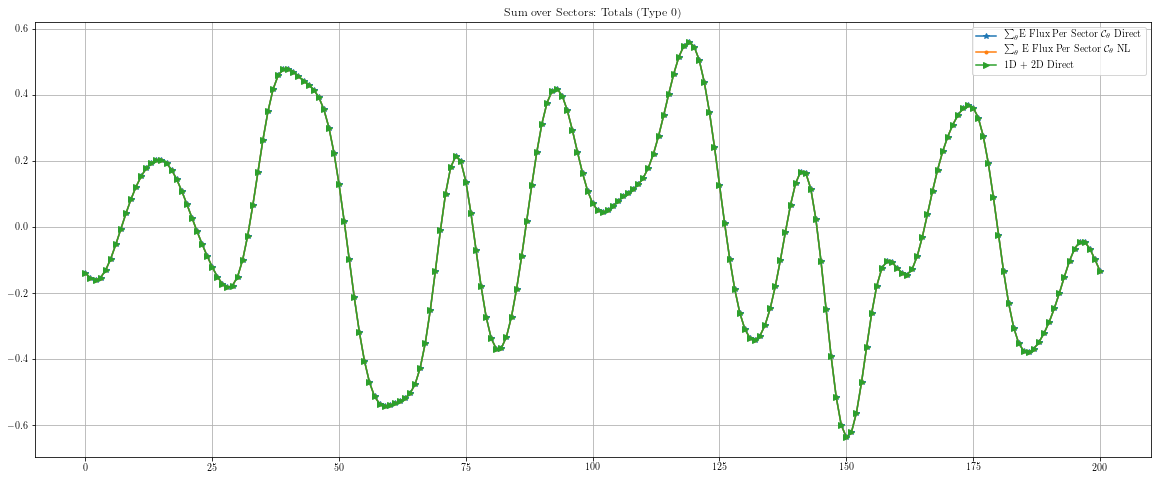

In [49]:
for i in range(post_data.num_sect):
    print("Sec: {}\t - \t1D + 2D: {}\t Total: {}\t Eq: {}\t Diff: {}\t Close: {}".format(i, 
          post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1), 
          post_data.enst_flux_per_sec[0, 0, i], 
          post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1) == post_data.enst_flux_per_sec[0, 0, i],
          (post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1)) / post_data.enst_flux_per_sec[0, 0, i] - 1,
         np.allclose(post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1), post_data.enst_flux_per_sec[0, 0, i])))
    
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, '*-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) * 2, '.-')
ax2.plot(np.sum(post_data.enst_flux_per_sec_1d[:, 0, :] + np.sum(post_data.enst_flux_per_sec_2d[:, 0, :, :], axis = -1), axis = -1) * const_fac * norm_fac, '>-')
# ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '--')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"1D + 2D Direct", r"Enstrophy Flux $\mathcal{C}$ Direct (Test)"])
plt.show()

## Check Complexification of flux

[1.99941468 1.99915614 1.99882754 1.99838885 1.99775832 1.99672662
 1.99446532 1.98065789 2.00928624 2.00304465 2.00160387 2.00107469
 2.00091113 2.00096552 2.00121728 2.00174522 2.00282203 2.00543514
 2.01654419 1.95839541 1.98728449 1.99113333 1.99268449 1.99391796
 1.99550698 1.99735809 1.99879488 1.99947161 1.99953703 1.9991798
 1.99838953 1.99669427 1.99062704 2.02983309 2.0067759  2.00397709
 2.00279877 2.00208488 2.00155386 2.00110203 2.00068438 2.00028401
 1.99990217 1.99955144 1.99924602 1.99898974 1.99876664 1.99853531
 1.99821506 1.99761959 1.99606018 1.98466805 2.0074107  2.00295983
 2.0018315  2.00127632 2.00089031 2.00054801 2.00019844 1.99982569
 1.99944009 1.99907178 1.99875694 1.99851984 1.99836155 1.99826045
 1.99817754 1.99805164 1.99774788 1.99666239 2.36559996 2.00154765
 2.00049959 2.00024765 2.00025855 2.00059836 2.00415401 1.99796589
 1.99890044 1.9991745  1.99934629 1.99952174 1.99977008 2.00020523
 2.00115074 2.00431031 1.9276562  1.992641   1.99509649 1.99590

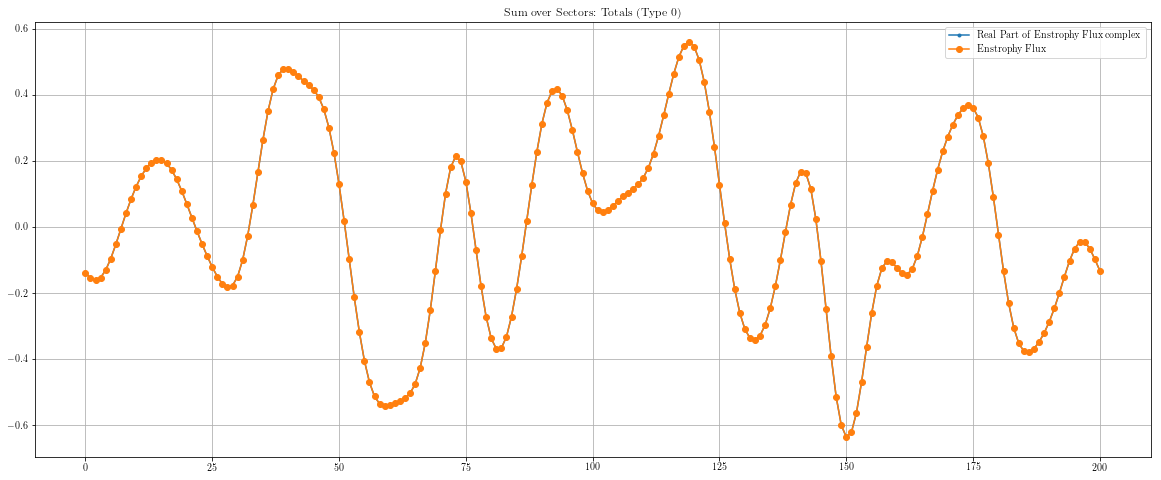

In [58]:
# print(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1))
# print(np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1))

# print(post_data.enst_flux_per_sec[:, 0, -1] / np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, -1]))
# print(np.imag(post_data.phase_order_C_theta_triads_unidirec[:, 0, 10]))

print(np.sum(post_data.enst_flux_per_sec[:, 0, :-1], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :-1]), axis = -1))


fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1) * const_fac * norm_fac, '.-')
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, 'o-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
# ax2.set_yscale('log')
ax2.grid()
ax2.legend([r"Real Part of Enstrophy Flux complex", r"Enstrophy Flux"])
plt.show()

## Check Unidrectional Phase Order Parameter

[ -32064.58760777  -31744.71552809  -31239.78556279  -30618.5246946
  -29915.9984707   -29138.04963839  -28283.68210388  -27363.12456578
  -26399.87589743  -25420.560529    -24445.31269833  -23488.35260347
  -22569.23222592  -21718.93194085  -20954.87751059  -20265.00506052
  -19672.30726888  -19258.55617258  -19164.84008859  -19702.08633174
  -21422.86066711  -24420.28691602  -27377.44492092  -29230.41016694
  -30301.91641558  -31215.80650059  -24364.19252043  -22980.19415031
  -22282.10479456  -21463.88057946  -20386.16346167  -19423.53046521
  -19016.40186136  -19103.35664701  -19477.33684912  -20020.52432562
  -20678.28482878  -21413.28656357  -22165.45149066  -22764.80548044
  -22591.29826736  -20514.48621465  -20226.09655873  -21325.80338873
  -22584.83254547  -23955.39700593  -25495.22244124  -27275.79084173
  -29347.46479374  -31663.74085254  -34169.31414112  -37257.53709362
  -45080.14054094  -65372.33880934  -70717.76203657  -78832.88118856
  -88977.17221564 -100667.71820044 

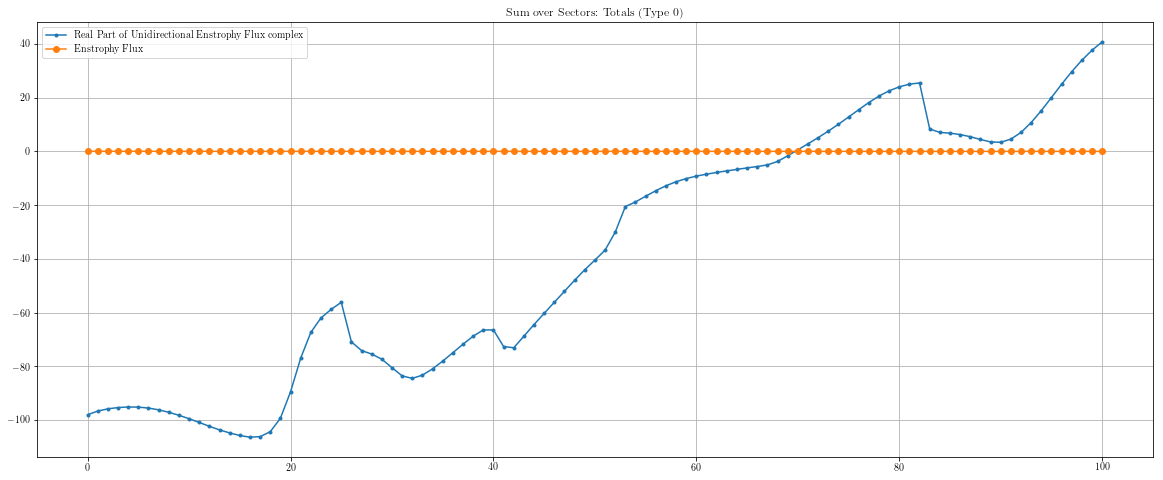

In [9]:
print(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :]), axis = -1))

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :]), axis = -1), '.-')
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, 'o-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
# ax2.set_yscale('log')
ax2.grid()
ax2.legend([r"Real Part of Unidirectional Enstrophy Flux complex", r"Enstrophy Flux"])
plt.show()

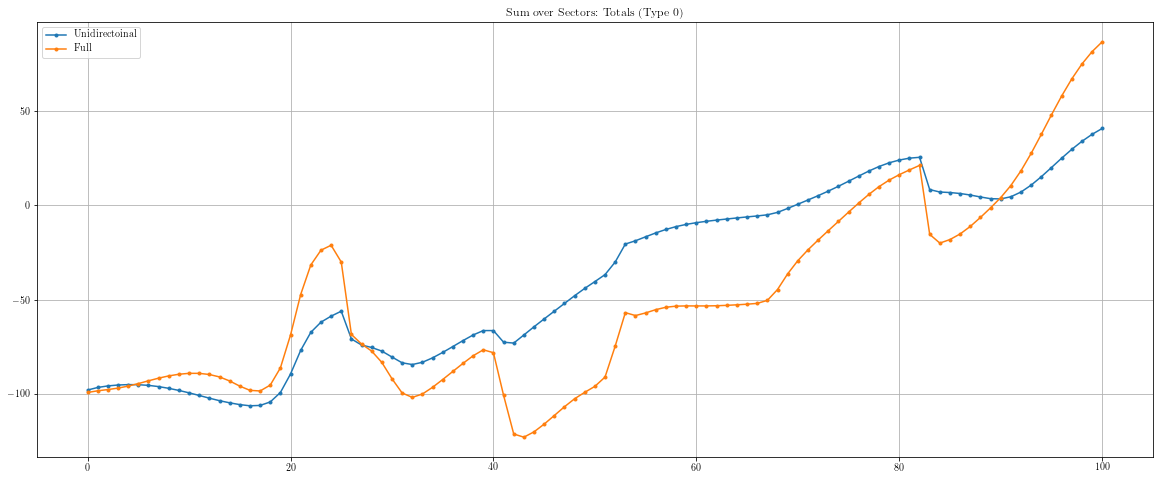

In [11]:
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :]), axis = -1), '.-')
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1), '.-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"Unidirectoinal", r"Full"])
plt.show()

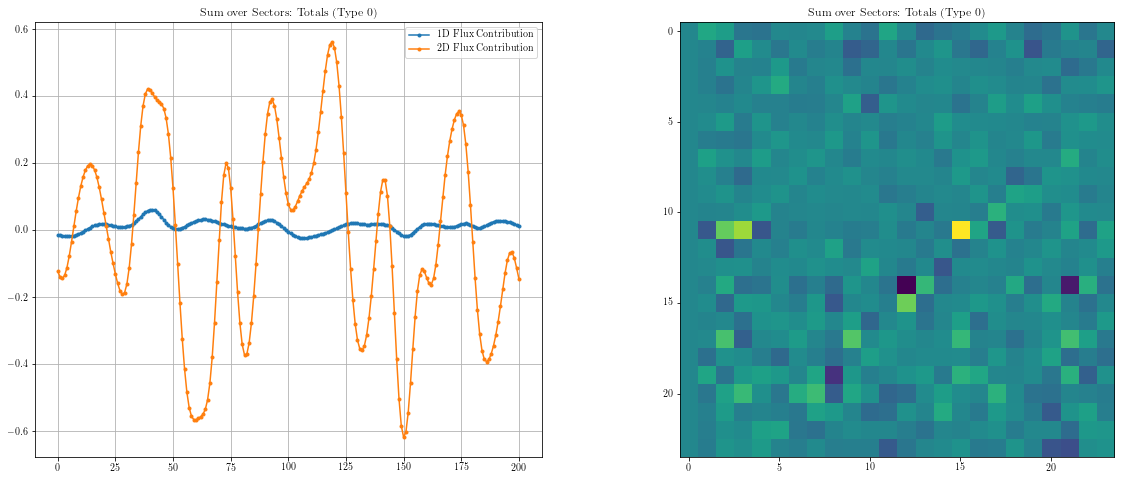

In [60]:
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec_1d[:, 0, :], axis = -1) * const_fac * norm_fac, '.-')
ax2.plot(np.sum(np.sum(post_data.enst_flux_per_sec_2d[:, 0, :, :], axis = -1), axis = -1) * const_fac * norm_fac, '.-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"1D Flux Contribution", r"2D Flux Contribution"])

t = 90
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(post_data.enst_flux_per_sec_2d[t, 0, :, :])
ax1.set_title(r"Sum over Sectors: Totals (Type 0)")

plt.show()

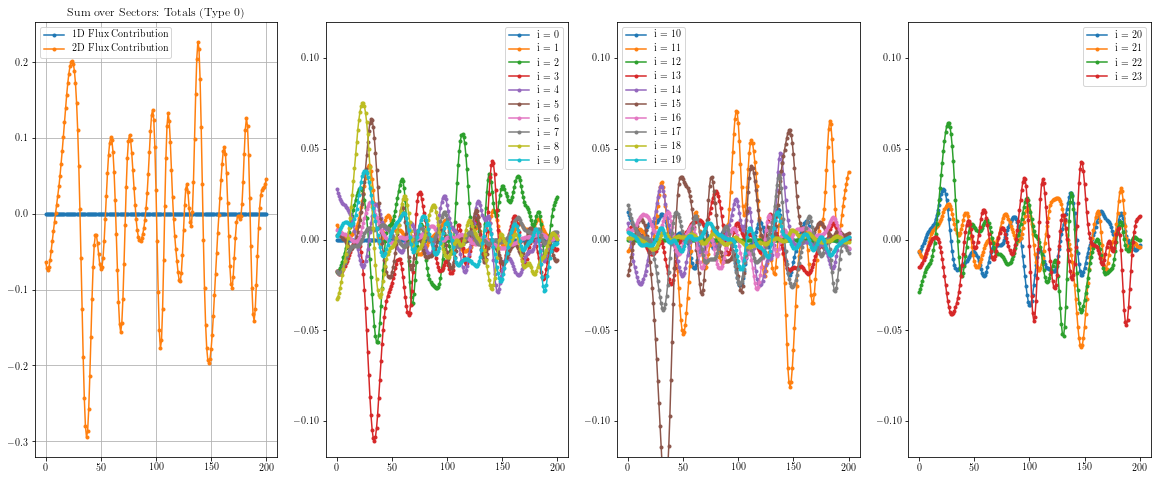

0.06544984694978828
-1.5053464798451093
-1.1126473981463847


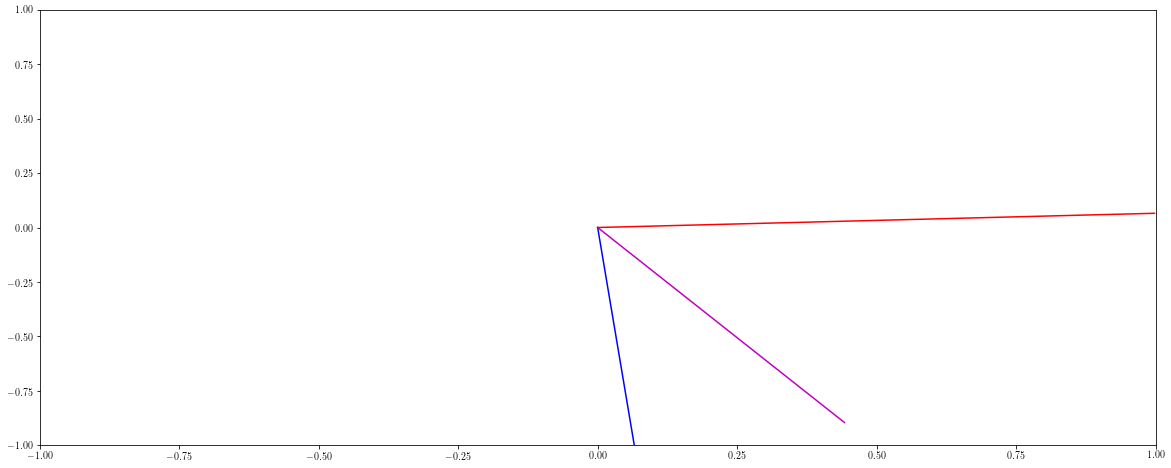

-1.5707963267948974
-1.1780972450961729
-0.1308996938995748


In [85]:
k3 = 12
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 4)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(post_data.enst_flux_per_sec_1d[:, 0, k3] * const_fac * norm_fac, '.-')
ax2.plot(np.sum(post_data.enst_flux_per_sec_2d[:, 0, k3, :], axis = -1) * const_fac * norm_fac, '.-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.legend([r"1D Flux Contribution", r"2D Flux Contribution"])
ax2.grid()
ax1 = fig.add_subplot(gs[0, 1])
for i in range(10):
    ax1.plot(post_data.enst_flux_per_sec_2d[:, 0, k3, i] * const_fac * norm_fac, '.-')
ax1.legend([r"i = {}".format(i) for i in range(10)])
ax1.set_ylim(-0.12, 0.12)
ax3 = fig.add_subplot(gs[0, 2])
for i in range(10):
    ax3.plot(post_data.enst_flux_per_sec_2d[:, 0, k3, i + 10] * const_fac * norm_fac, '.-')
ax3.legend([r"i = {}".format(i + 10) for i in range(10)])
ax3.set_ylim(-0.12, 0.12)

ax4 = fig.add_subplot(gs[0, 3])
for i in range(4):
    ax4.plot(post_data.enst_flux_per_sec_2d[:, 0, k3, i + 10 + 10] * const_fac * norm_fac, '.-')
ax4.legend([r"i = {}".format(i + 10 + 10) for i in range(4)])
ax4.set_ylim(-0.12, 0.12)

plt.show()

n_theta   = post_data.num_sect
dtheta    =  np.pi / n_theta
theta     = np.arange(-np.pi/2, np.pi/2 + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
print(theta[np.mod(k3, 24)])
print(theta[np.mod(k3 + 12, 24)])
print(theta[np.mod(k3 + 15, 24)])

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot([0.0, np.cos(theta[np.mod(k3, 24)])], [0.0, np.sin(theta[np.mod(k3, 24)])], 'r')
ax2.plot([0.0, np.cos(theta[np.mod(k3 + 12, 24)])], [0.0, np.sin(theta[np.mod(k3 + 12, 24)])], 'b')
ax2.plot([0.0, np.cos(theta[np.mod(k3 + 15, 24)])], [0.0, np.sin(theta[np.mod(k3 + 15, 24)])], 'm')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)

plt.show()

print(theta[np.mod(k3 + 12, 24)] - theta[np.mod(k3, 24)])
print(theta[np.mod(k3 + 15, 24)] - theta[np.mod(k3, 24)])
print(theta[np.mod(k3 + 23, 24)] - theta[np.mod(k3, 24)])

In [94]:
def compute_pdf(bin_ranges, bin_counts, normalized = False):

    ## Get nonzero bin indexs
    non_zero_args = np.where(bin_counts != 0)

    ## Get the bin centres
    bin_centres = (bin_ranges[1:] + bin_ranges[:-1]) * 0.5
    bin_centres = bin_centres[non_zero_args]

    ## Compute the bin width
    bin_width = bin_ranges[1] - bin_ranges[0]

    ## Compute the pdf
    pdf = bin_counts[:] / (np.sum(bin_counts[:]) * bin_width)
    pdf = pdf[non_zero_args]

    if normalized:
        var         = np.sqrt(np.sum(pdf * bin_centres**2 * bin_width))
        pdf         *= var
        bin_centres /= var 
        bin_width   /= var


    return bin_centres, pdf

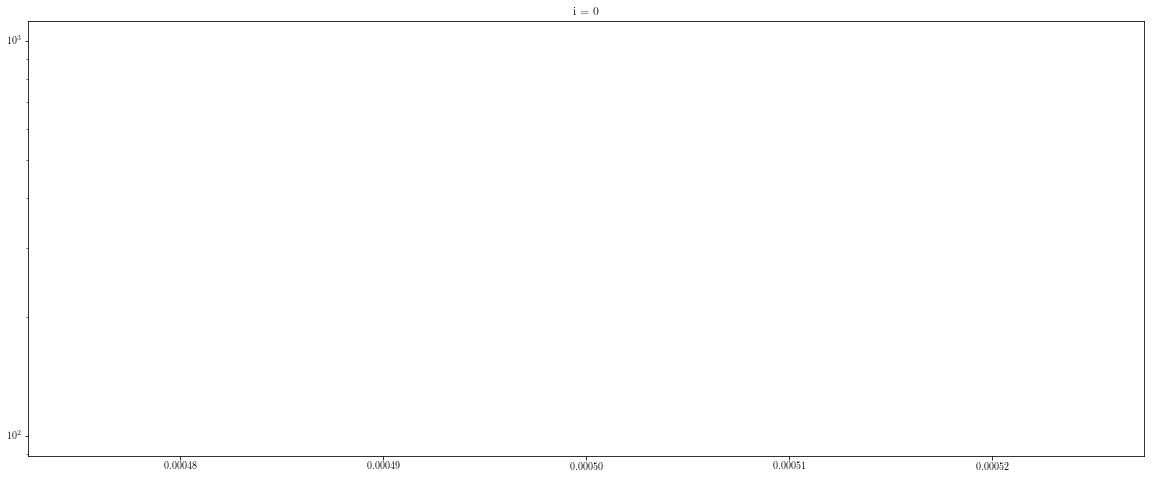

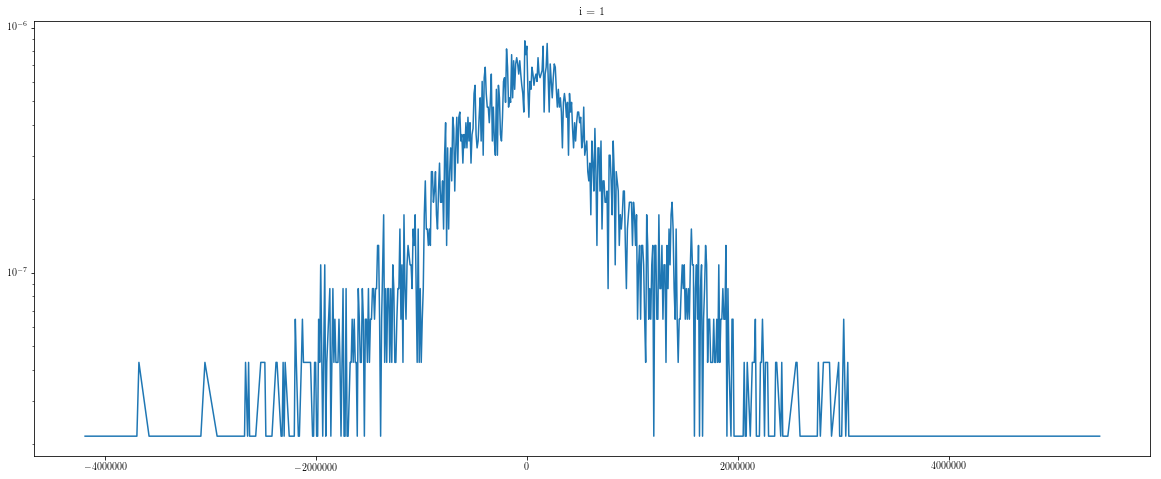

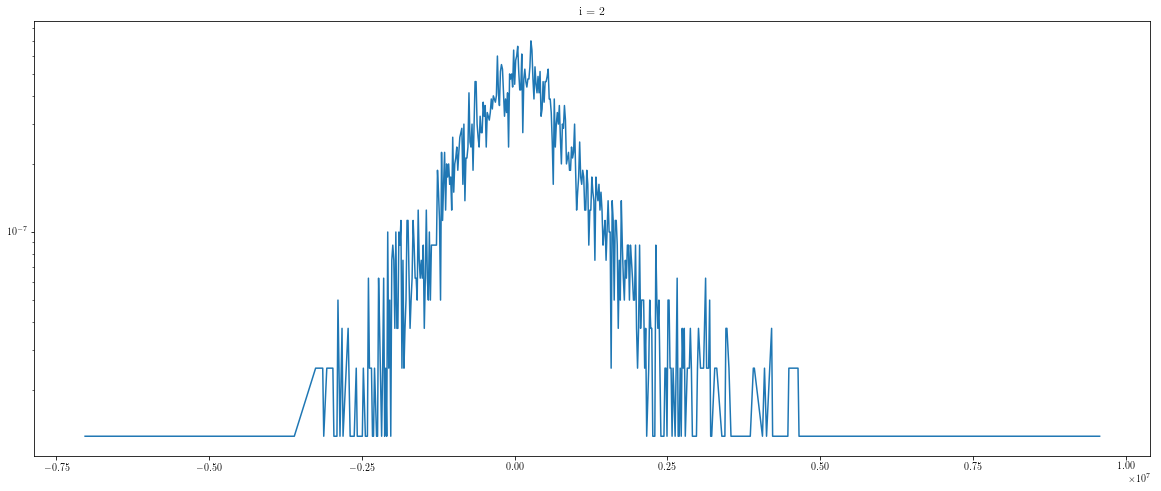

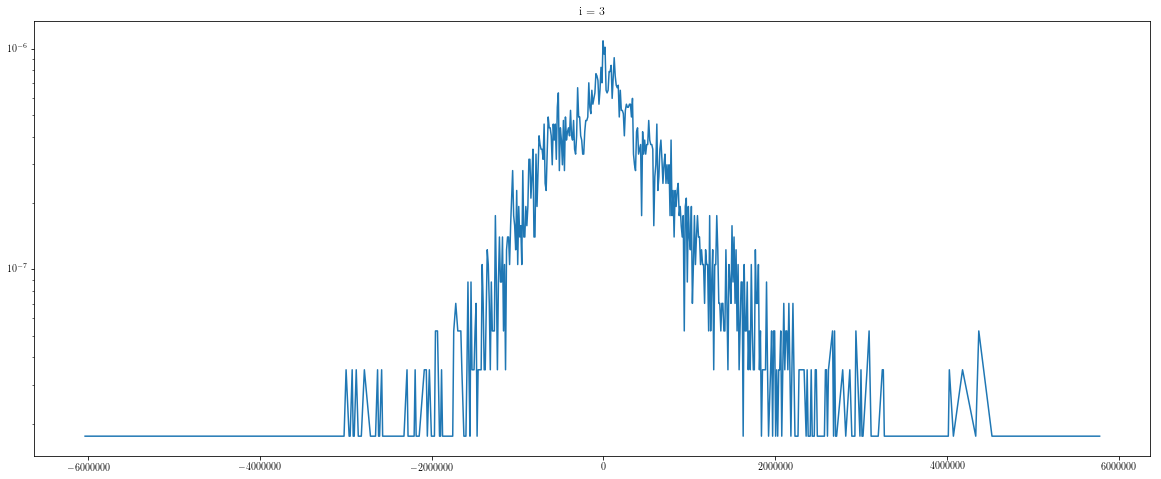

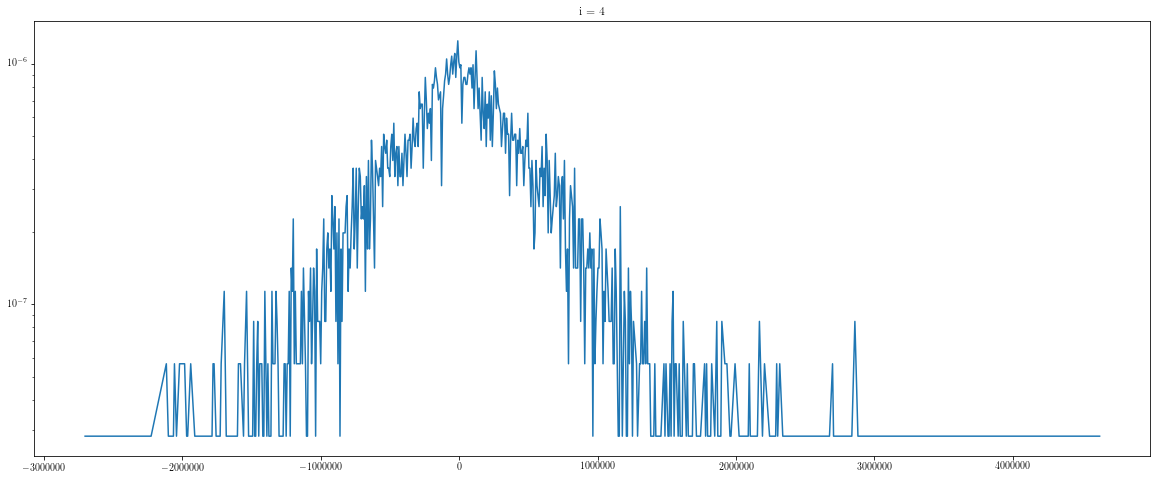

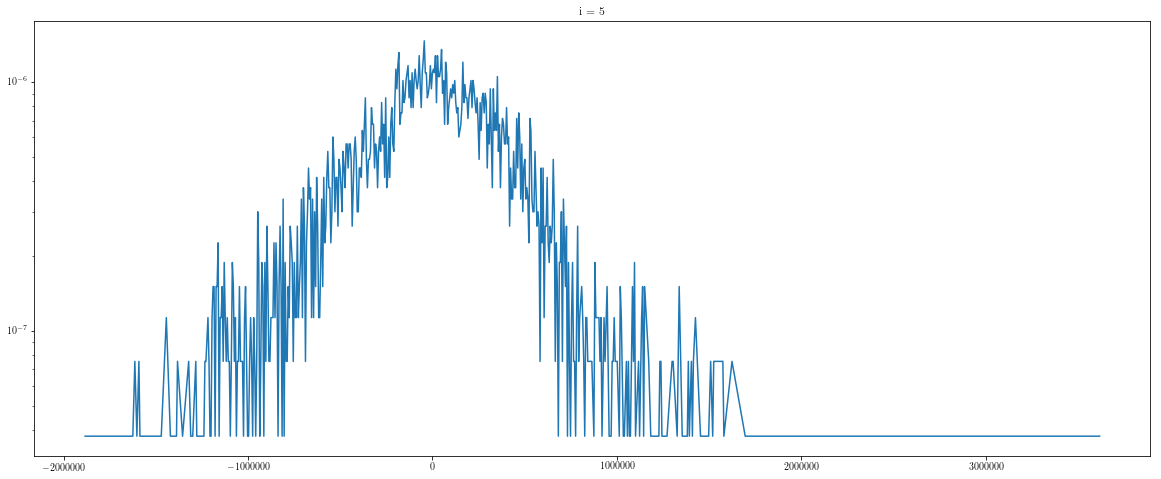

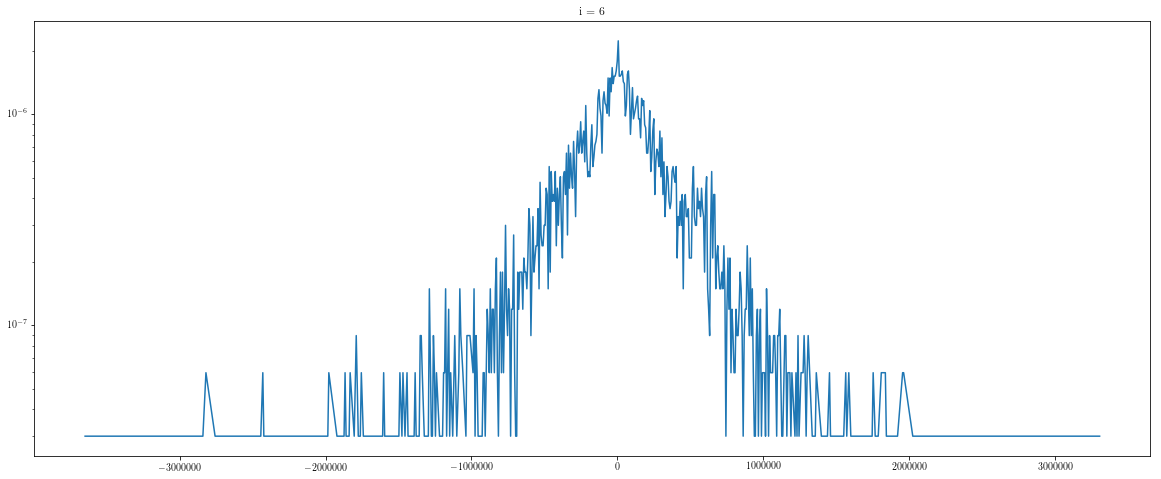

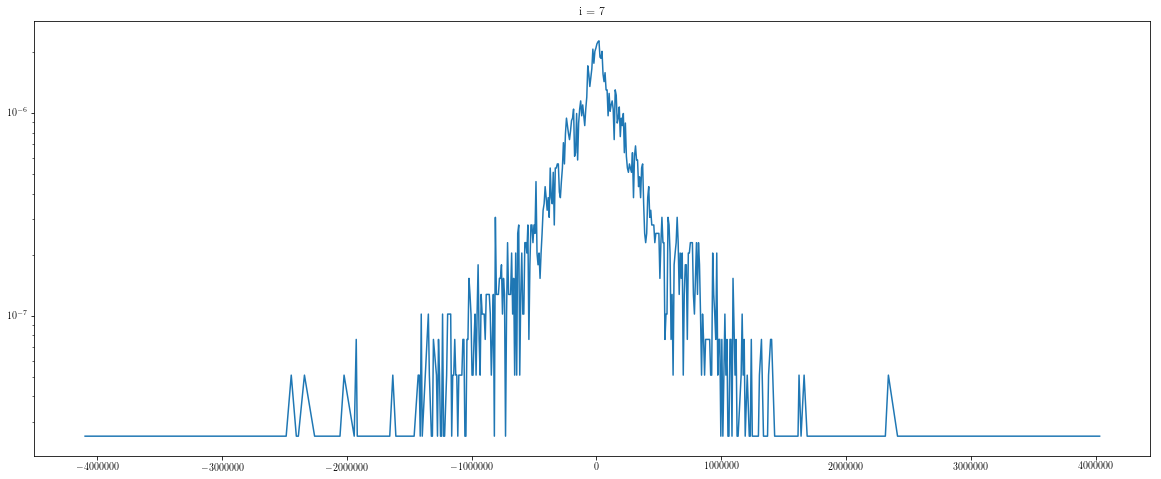

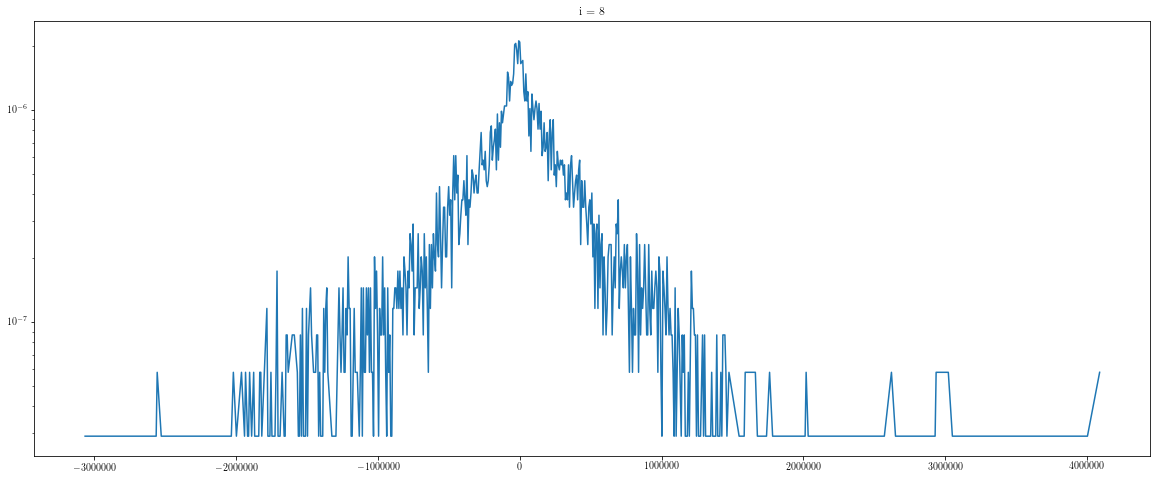

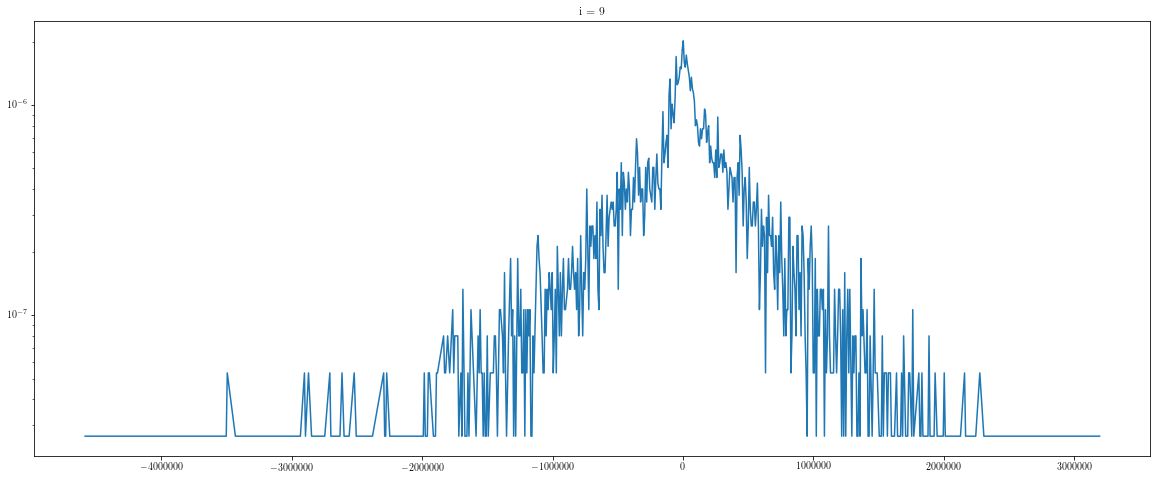

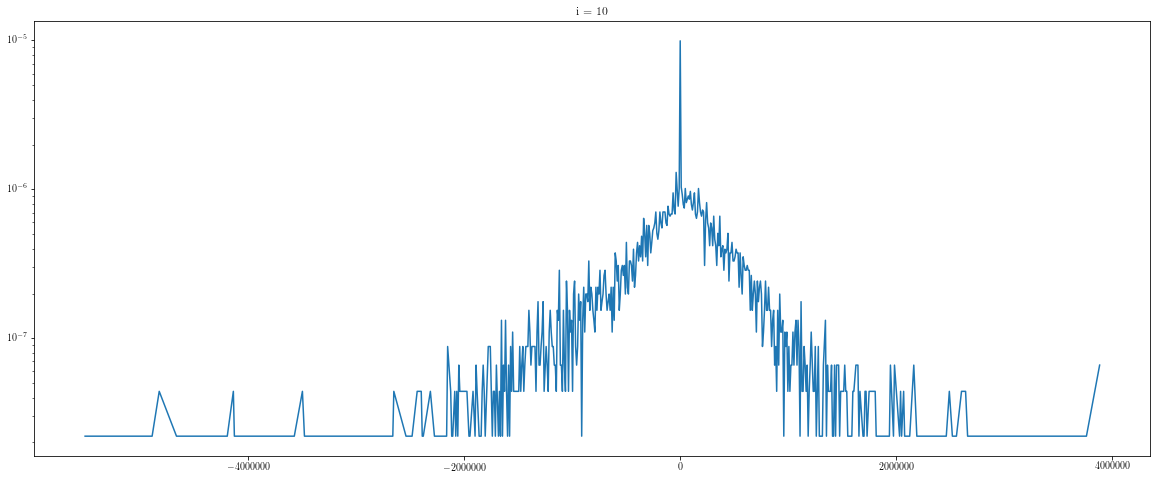

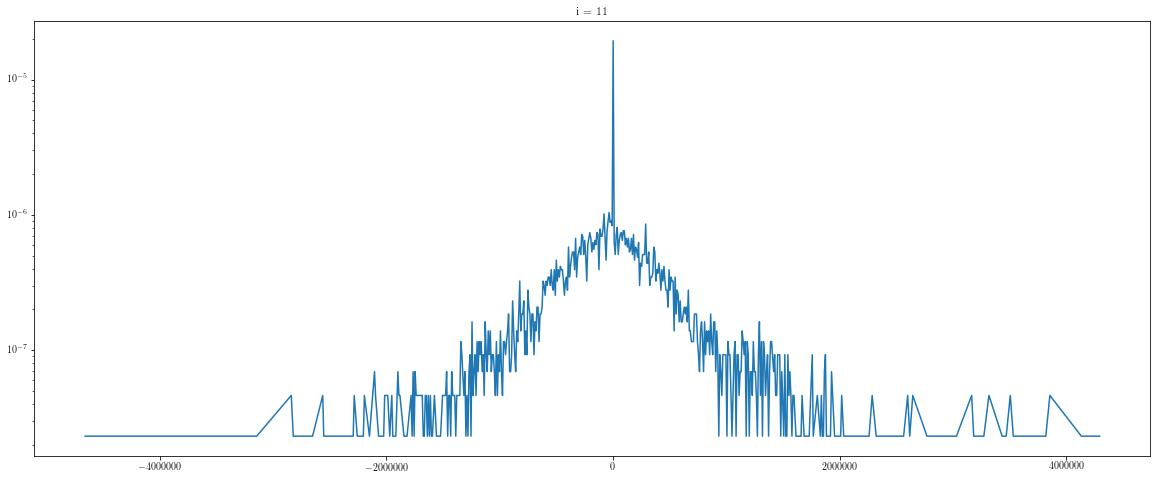

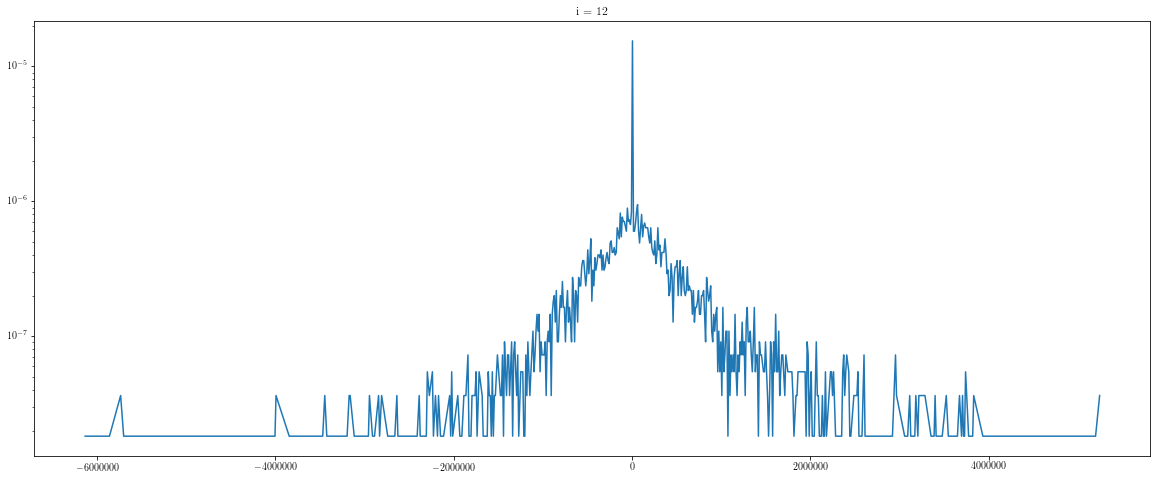

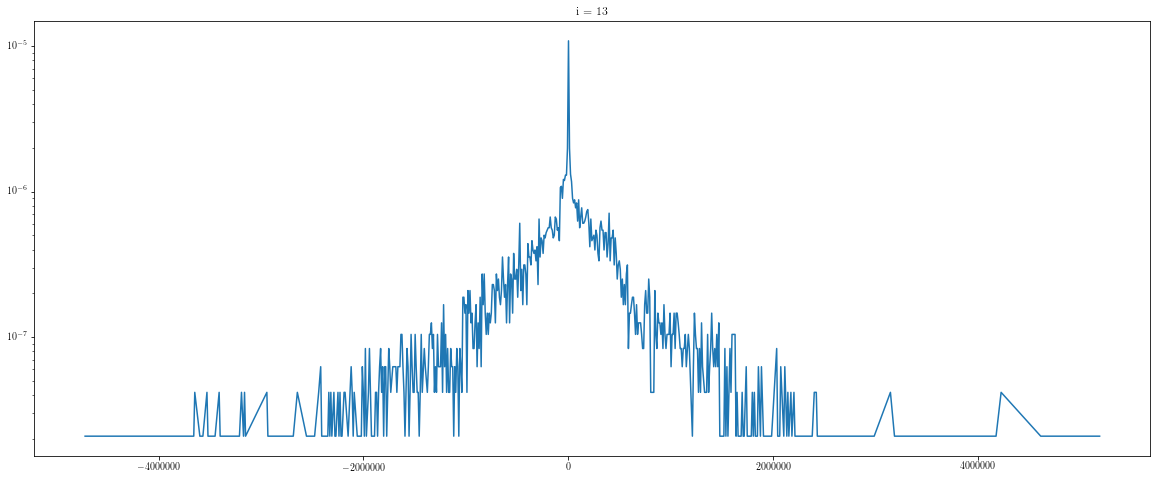

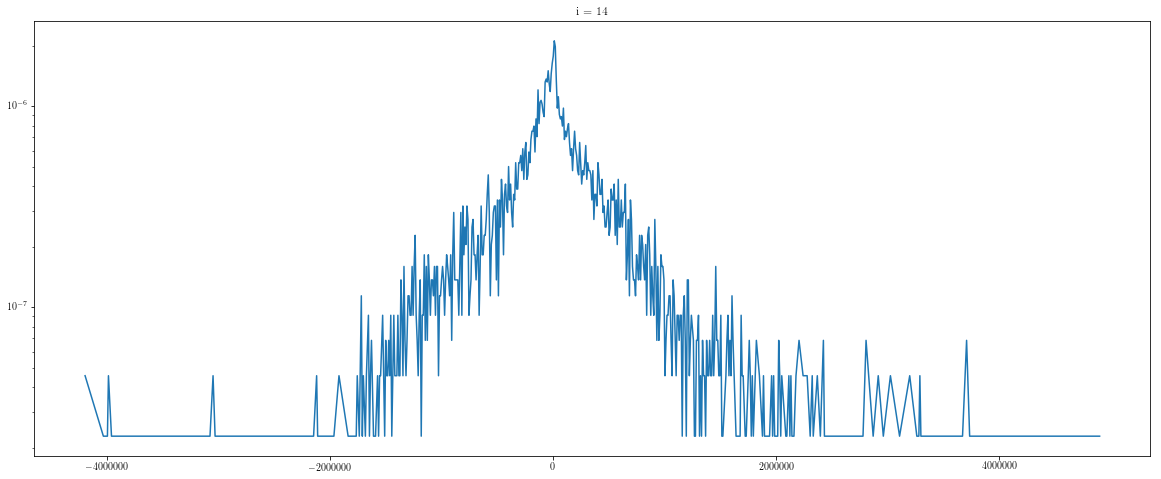

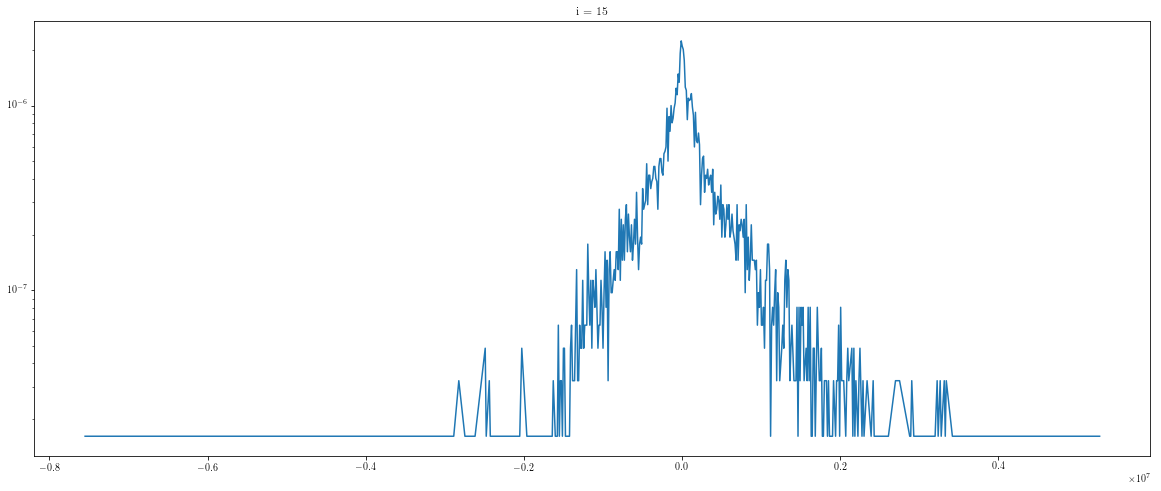

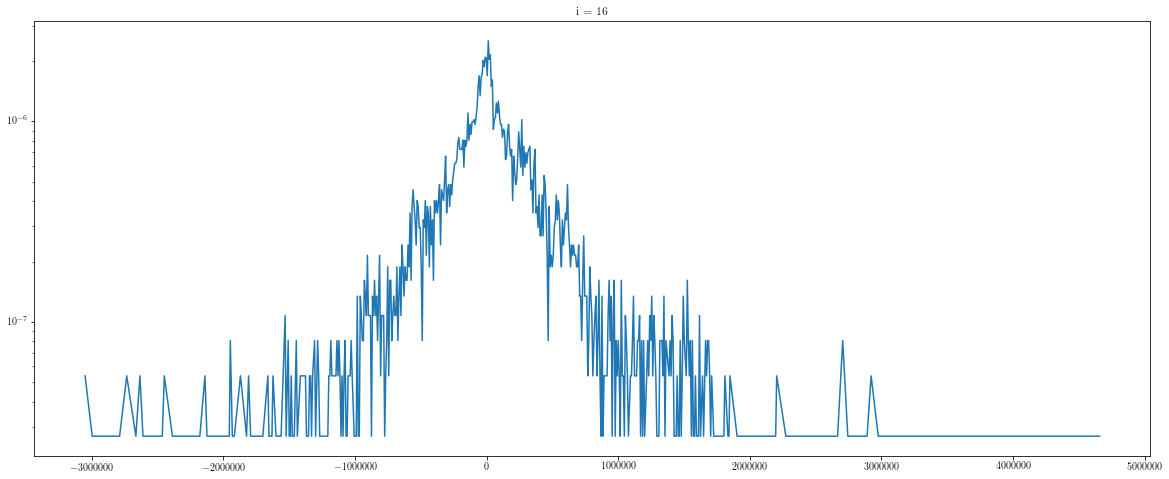

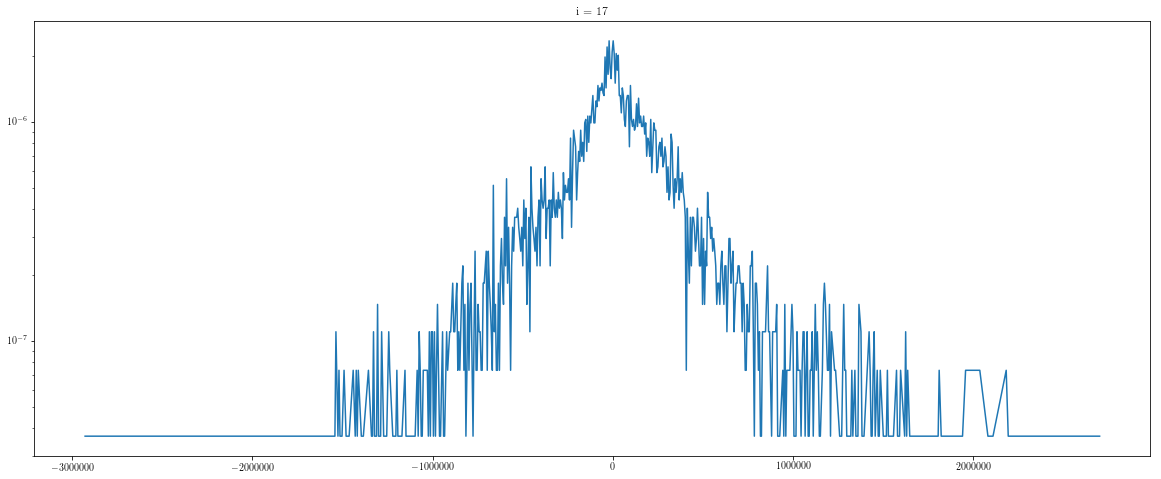

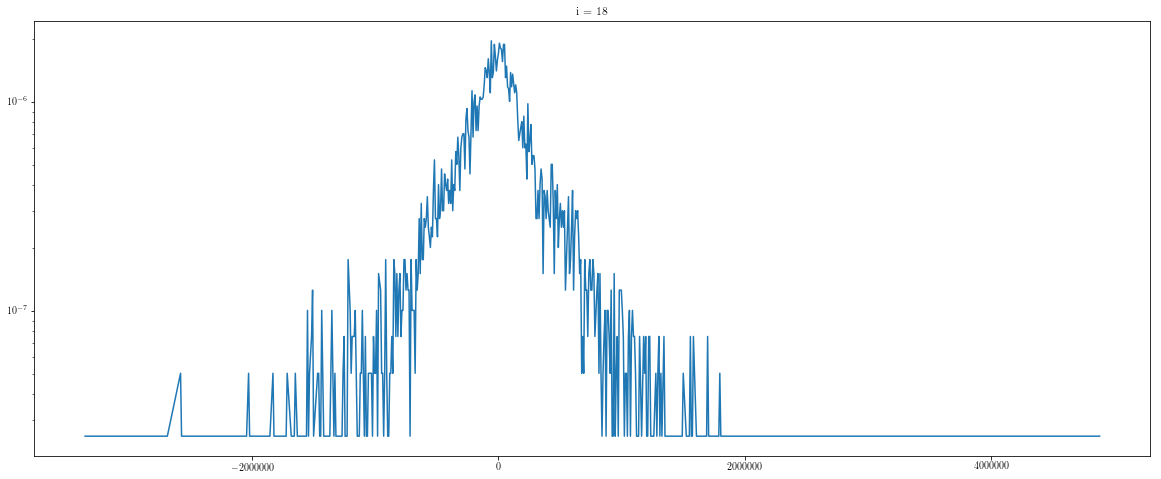

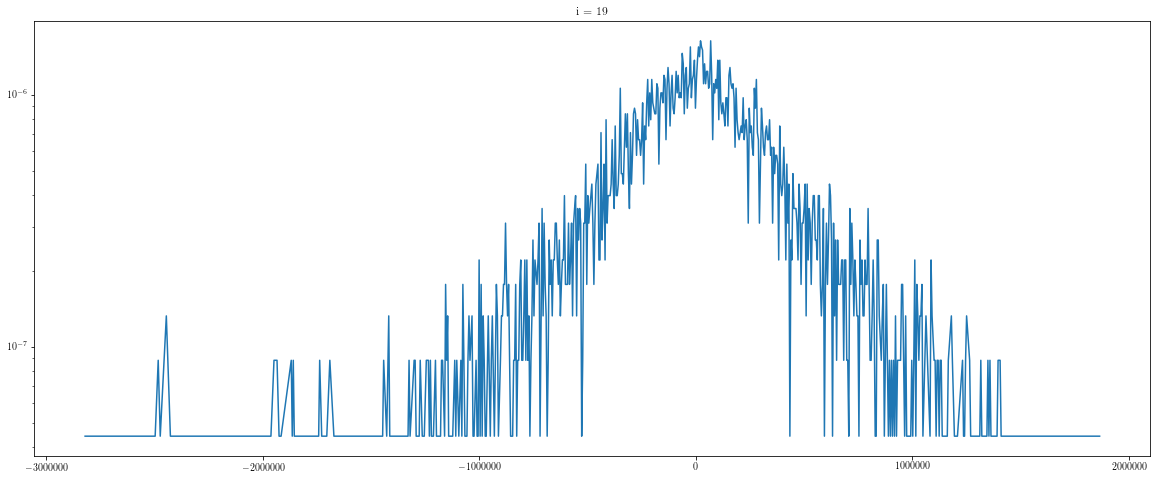

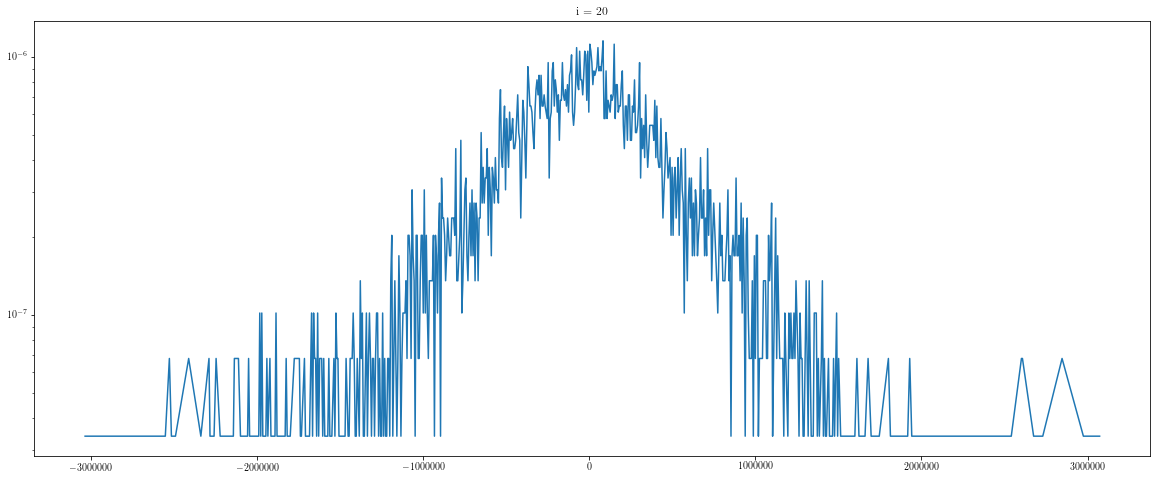

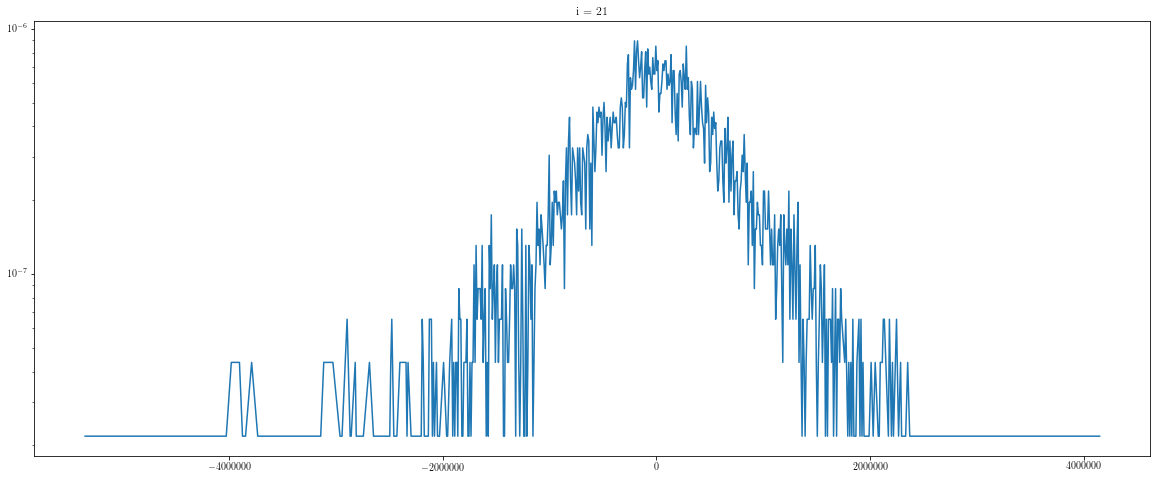

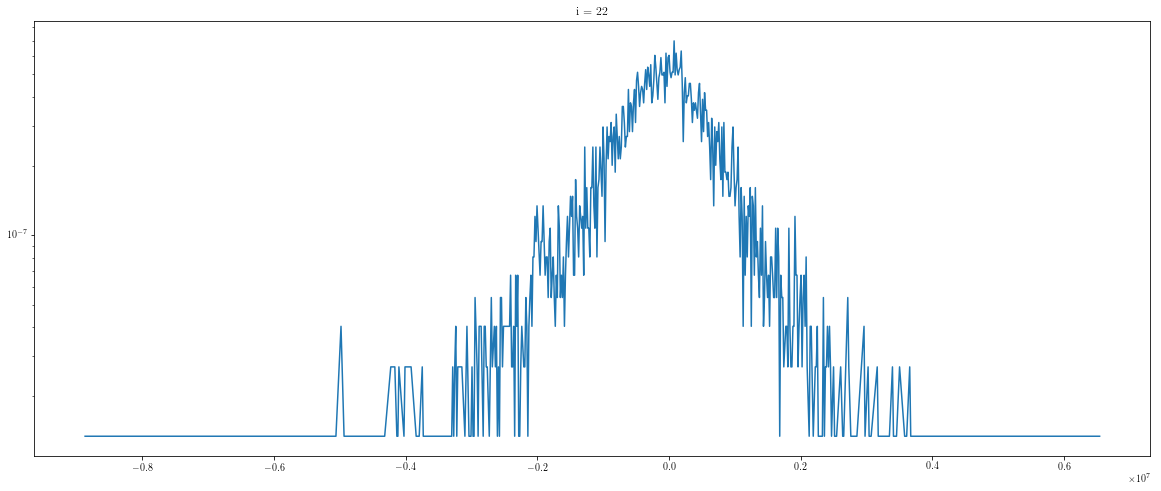

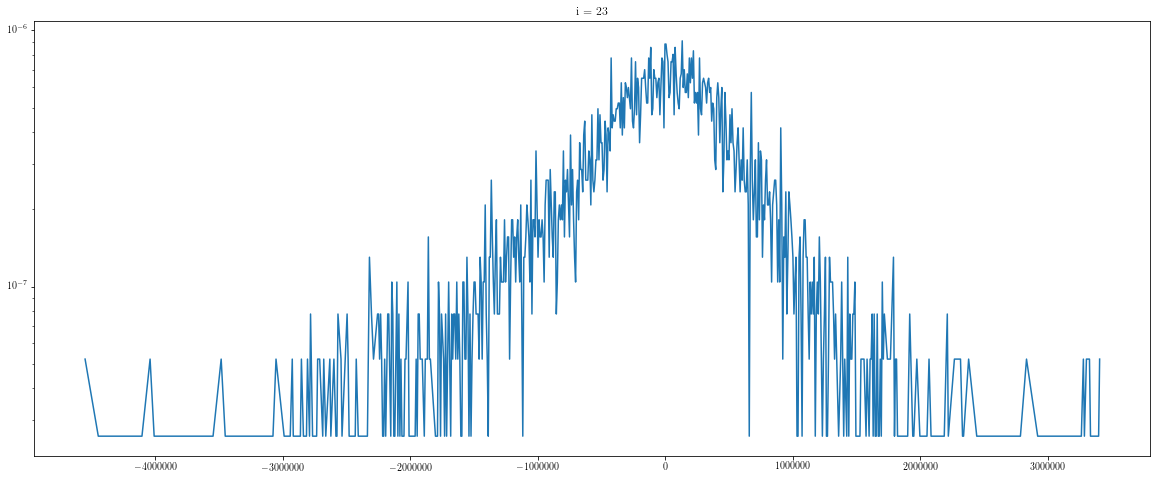

[0.0, 39812.962081156686, 116212.74552643091, 62926.351823385994, 38400.515863351684, -59.02922525206213, 4679.232702176355, -599.2881078694146, -23059.61793910613, -20819.988705204105, -77411.51101054074, -4578.090880247231, 81498.64273870851, -29703.01832770697, 11294.975622883021, 51502.50184926817, 59214.75032005413, 22924.13303829013, -16461.42940304456, -27721.672909999626, -52981.25892326172, -44554.70095798308, -136902.83098965473, -98039.93407713309]


In [102]:
# print(post_data.enst_flux_per_sec_2d[0, 0, 0, :])
# print(post_data.num_triads_2d[0, :, 12])
import scipy

mean = []
for i in range(post_data.num_k1_sects):
    counts, edges = np.histogram(post_data.enst_flux_per_sec_2d[:, 0, :, i], bins = 1000)
    bin_centres, pdf = compute_pdf(edges, counts)
    
    mean.append(np.mean(post_data.enst_flux_per_sec_2d[:, 0, :, i]))
    fig = plt.figure(figsize = (20, 8))
    gs  = GridSpec(1, 1)
    ax2 = fig.add_subplot(gs[0, 0])
    ax2.plot(bin_centres, pdf)
    ax2.set_yscale('log')
    ax2.set_title("i = {}".format(i))
    plt.show()
print(mean)

In [84]:
print(post_data.enst_flux_C_theta[:, :])

[[ 0.01093992 -0.04352839 -0.05221807 ...  0.01883611 -0.03544097
   0.01075189]
 [ 0.00362363 -0.06874446 -0.04419212 ...  0.01586799 -0.04789295
   0.00088531]
 [-0.0043458  -0.08882347 -0.03292861 ...  0.01419516 -0.05982331
  -0.00706148]
 ...
 [ 0.03471465  0.00325095 -0.02152442 ... -0.01072018  0.04319488
  -0.04004245]
 [ 0.02270895  0.01414995 -0.02323791 ... -0.01388749  0.04539528
  -0.04600686]
 [ 0.00690568  0.02853438 -0.02403321 ... -0.01598299  0.04429657
  -0.04513556]]


In [480]:
# test_c_theta_flux = np.sum(post_data.enst_flux_C_theta[:, :], axis = -1)
# test_test_flux = post_data.enst_flux_test[:, 0] * const_fac * norm_fac
# test_flux_c_theta_full = post_data.enst_flux_C_theta[:, :]
# test_test_full = post_data.enst_flux_test[:, 0]
# print(test_flux_c_theta_full.shape)
# print(test_flux_c_theta_full)
# print(test_test_full.shape)
# print(test_test_full)

In [107]:
print(post_data.enst_flux_per_sec[0, 0, :])
print(post_data.enst_flux_per_sec[0, 1, :])
print(post_data.num_triads[0, :])
# NOTE: 8 Sectors is weird, none of the sectors match up
print("\n\nSect ID \t Enst  \t\t\t Enst \t\t\t Diff \t\t Matching\t\tAllClose\tNum Triads")
for i in range(post_data.num_sect // 2):
    print("{}/{}:\t{}\t{}\t{}\t\t{}\t\t{}\t\t{}".format(i, post_data.num_sect // 2 + i, post_data.enst_flux_per_sec[0, 0, i], post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                          post_data.enst_flux_per_sec[0, 0, i] - post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                              post_data.enst_flux_per_sec[0, 0, i] == post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i],
                                              np.allclose(post_data.enst_flux_per_sec[0, 0, i],post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i]),
                                              post_data.num_triads[0, i]))
print()
print(post_data.num_wv)
print(post_data.num_wv.shape)
print(post_data.wv.shape)

[ -7005.81349153  -2109.86501106 -16936.9664138   29853.5173995 ]
[ -2274.59742631  -5284.99521296 -11699.82281345  13974.34852586]
[166 232 166 232]


Sect ID 	 Enst  			 Enst 			 Diff 		 Matching		AllClose	Num Triads
0/2:	-7005.813491531523	-16936.96641380368	9931.152922272155		False		False		166
1/3:	-2109.8650110614085	29853.517399503515	-31963.382410564922		False		False		232

[[ 72  94]
 [120 112]
 [ 94  72]
 [112 120]]
(4, 2)
(4, 2, 16, 120)


In [95]:
num_k3_sec = 10
num_k1_sec = 1

with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[{},{}]_KFRAC[0.75].h5'.format(int(num_k3_sec), int(num_k1_sec))) as f:
    num_wave_vec_sec1 = f["NumWavevectors"][:, :]
#     print(num_wave_vec_sec1)
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv = np.ones((num_k3_sec, num_k1_sec, 16, np.amax(num_wave_vec_sec1))) * 100
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wave_vec_sec1[a, l]):
                    wv[a, l, k, n] = tmp_arr[k, n]
                    
num_k3_sec = 10
num_k1_sec = 2     
# print(post_data.num_k1_sects)
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[{},{}]_KFRAC[0.75].h5'.format(int(num_k3_sec), int(num_k1_sec))) as f:
    num_wave_vec_sec1_2 = f["NumWavevectors"][:, :]
#     print(num_wave_vec_sec1)
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_2 = np.ones((num_k3_sec, num_k1_sec, 16, np.amax(num_wave_vec_sec1_2))) * 100
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wave_vec_sec1_2[a, l]):
                    wv_2[a, l, k, n] = tmp_arr[k, n]
                    
                    
num_k3_sec = 10
num_k1_sec = 4

with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[{},{}]_KFRAC[0.75].h5'.format(int(num_k3_sec), int(num_k1_sec))) as f:
    num_wave_vec_sec1_4 = f["NumWavevectors"][:, :]
#     print(num_wave_vec_sec1)
    num_triad_est_4 = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_4 = np.ones((num_k3_sec, num_k1_sec, 16, np.amax(num_wave_vec_sec1_4))) * 100
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wave_vec_sec1_4[a, l]):
                    wv_4[a, l, k, n] = tmp_arr[k, n]
print("First Sum -------- Second Sum")
print("1 - 2 - 4 -------- 1 - 2 - 4")
for a in range(num_k3_sec):
#     print(wv_10[a, :, -1, :])
    print("{} - {} - {} -------- {} - {} - {}".format(np.sum(wv[a, :, -1, :] == 0), np.sum(wv_2[a, :, -1, :] == 0), np.sum(wv_4[a, :, -1, :] == 0), np.sum(wv[a, :, -1, :] == 1), np.sum(wv_2[a, :, -1, :] == 1), np.sum(wv_4[a, :, -1, :] == 1)))  
print(post_data.num_triads)
print(num_wave_vec_sec1_2)

OSError: Unable to open file (unable to open file: name = '/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[10,2]_KFRAC[0.75].h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
## Pick sector to examine
sec_i = 0

## Ignore the extra data
ignore   = wv[sec_i, :, -1, :] != 100
ignore_2 = wv_2[sec_i, :, -1, :] != 100
wv_i     = wv[sec_i, :, :, ignore[0]]
wv_2_i   = wv_2[sec_i, :, :, ignore_2[0]]

## Extract first or second sum cases
term = 1
flux_term_type = wv_i[:, :, -1] == term
wv_i_terms = wv_i[flux_term_type[:, 0], :, :6][:, 0, :]
for i in range(wv_i_terms.shape[0]):
    print(wv_i_terms[i, :])
flux_term_type = wv_2_i[:, :, -1] == term
wv_2_i_terms = wv_2_i[flux_term_type[:, 0], :, :6][:, :, :]
for i in range(wv_2_i_terms.shape[0]):
    print(wv_2_i_terms[i, :, :])

[-2. -4.  1.  4. -1.  0.]


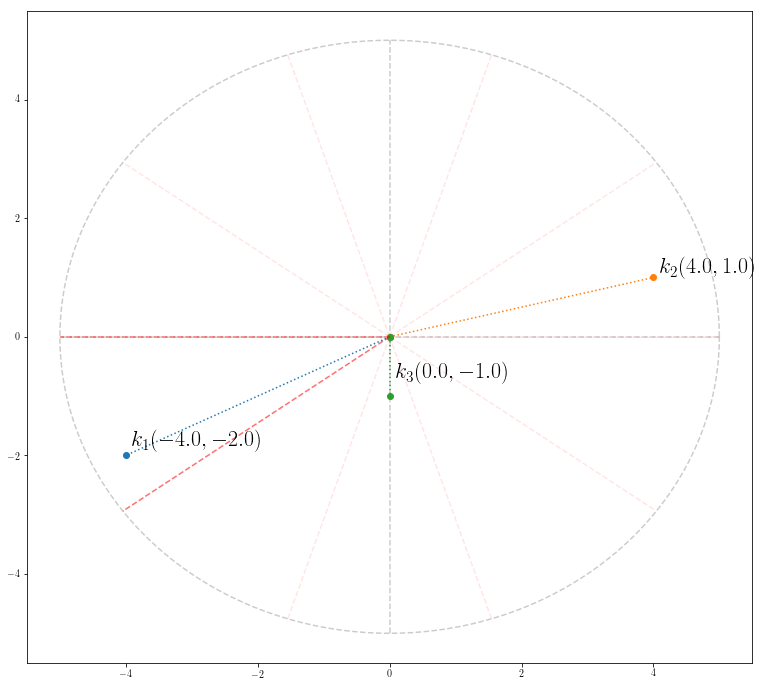

[ 1.  4. -2. -4. -1.  0.]


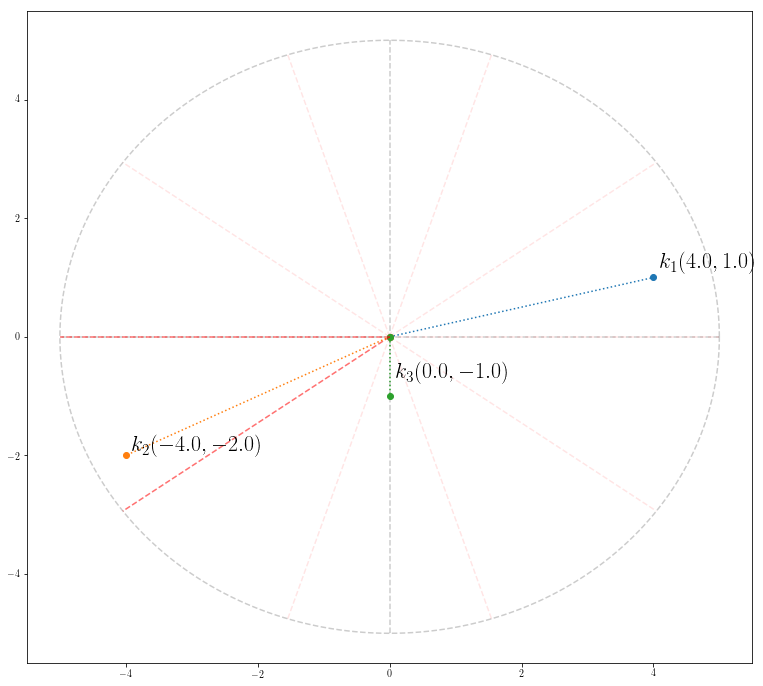

[-1. -4.  2.  4.  1.  0.]


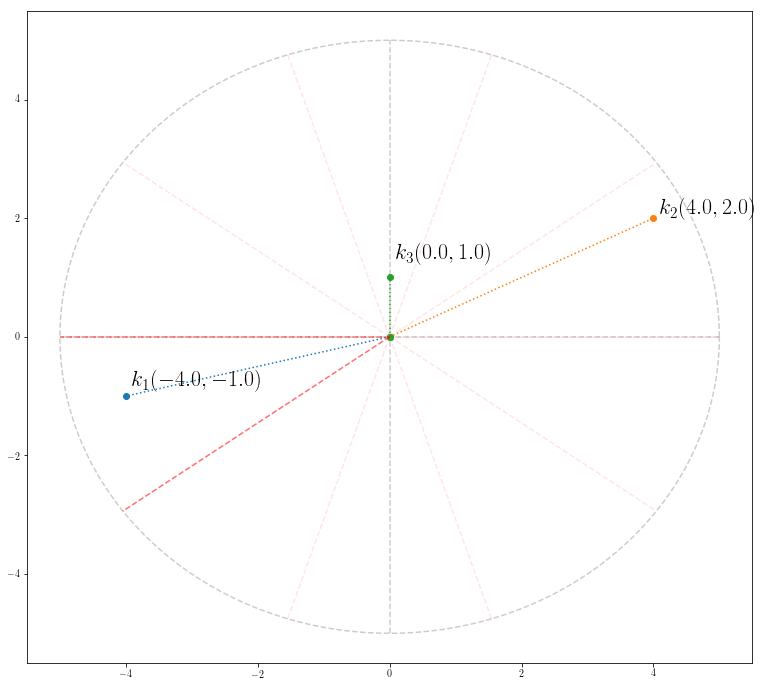

[ 2.  4. -1. -4.  1.  0.]


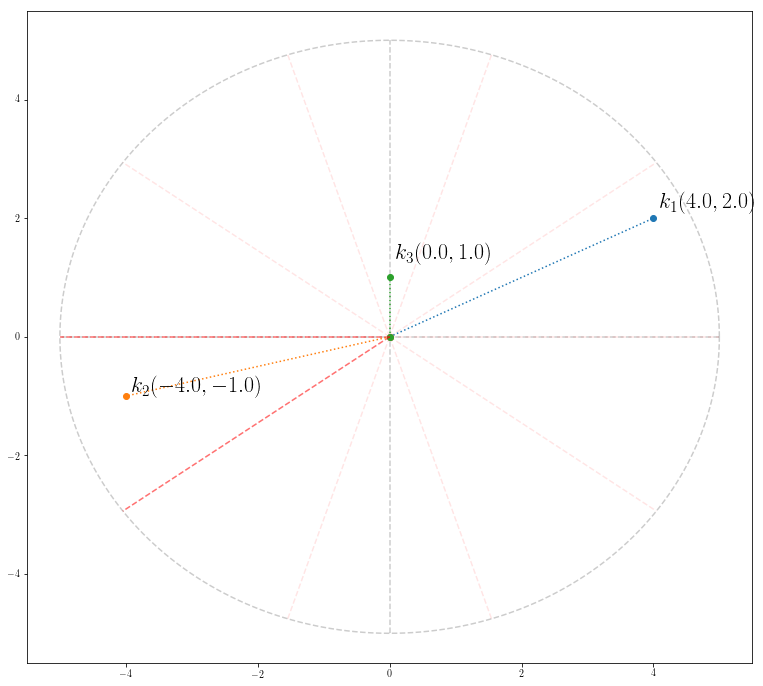

In [50]:
n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

K1_X         = 0
K1_Y         = 1
K2_X         = 2
K2_Y         = 3
K3_X         = 4
K3_Y         = 5
K1_SQR       = 6
K2_SQR       = 7
K3_SQR       = 8
K1_ANGLE     = 9
K2_ANGLE     = 10
K3_ANGLE     = 11
K1_ANGLE_NEG = 12
K2_ANGLE_NEG = 13
K3_ANGLE_NEG = 14
FLUX_TERM    = 15

dsec = sec_i

for k_vec in wv_i_terms[:, :]:
    
    print(k_vec)

    plt.figure(figsize = (13, 12))
    plt.plot(x, y, 'k--', alpha = 0.2)
    plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
    plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
    for aa in range(post_data.num_sect):
        ## Plot sectors
        plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
        plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

    ## Print missing 
#     p1, = plt.plot([0, -k_vec[K1_Y]], [0, -k_vec[K1_X]], '.-', alpha = 1)
#     p2, = plt.plot([0, -k_vec[K2_Y]], [0, -k_vec[K2_X]], '.-', alpha = 1)
#     p3, = plt.plot([0, -k_vec[K3_Y]], [0, -k_vec[K3_X]], '.-', alpha = 1)
#     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
#     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
    p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
    p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
    p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
    plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
    plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
    plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)

    plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
    plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
    
    plt.show()

In [ ]:
print(post_data.enst_flux_per_sec[-100, 0, :])
print(post_data.enst_flux_per_sec[-100, 1, :])
print(post_data.num_triads[0, :])
# NOTE: 8 Sectors is weird, none of the sectors match up
print("\n\nSect ID \t Enst  \t\t\t Enst \t\t\t Diff \t\t Matching\t\tAllClose\tNum Triads")
for i in range(post_data.num_sect // 2):
    print("{}/{}:\t{}\t{}\t{}\t\t{}\t\t{}\t\t{}".format(i, post_data.num_sect // 2 + i, post_data.enst_flux_per_sec[0, 0, i], post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                          post_data.enst_flux_per_sec[0, 0, i] - post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                              post_data.enst_flux_per_sec[0, 0, i] == post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i],
                                              np.allclose(post_data.enst_flux_per_sec[0, 0, i],post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i]),
                                              post_data.num_triads[0, i]))

## Search All sector for missing

In [19]:
sector = 0

combined = []
for l in range(post_data.num_k1_sects):
    for i in range(post_data.num_wv[sector, l]):
        combined.append(post_data.wv[sector, l, :6, i])

## Check first k1 sector is in all list
for l in range(post_data.num_k1_sects):
    for i in range(post_data.num_wv[sector, l]):
        k_vec = post_data.wv[sector, l, :6, i]

        res = k_search(k_vec, wv_4[sector, 0, :6, :])
        if res[0] == False:
            print(res)

## Get the missing triads        
missing = []
missing_type = []
missing_indx = []
for i in range(num_wv_4[sector, 0]):
    k_vec = wv_4[sector, 0, :6, i]
    flux_term = wv_4[sector, 0, -1, i]
    indx = i
    
    res_0 = k_search(k_vec, post_data.wv[sector, 0, :6, :])
    res_1 = k_search(k_vec, post_data.wv[sector, 1, :6, :])
    if res_0[0] == False and res_1[0] == False:
        missing.append(k_vec)
        missing_type.append(flux_term)
        missing_indx.append(indx)
        
print(len(missing))
for i in range(len(missing)):
    print(missing[i], missing_type[i], missing_indx[i])

0


## Search split sectors for extra

In [23]:
sector = 0

# print(wv_4[sector, 0, :6, :])

## Check if triads are in other sectors
match = []
for l in range(post_data.num_k1_sects):
    if l != sector:
        print("l = {}".format(l))
        for i in range(post_data.num_wv[sector, 0]):
            k_vec = post_data.wv[sector, 0, :6, i]

            res = k_search(k_vec,post_data.wv[sector, l, :6, :])
            if res[0] == True:
                match.append(k_vec)
                print(i, res, post_data.wv[sector, 0, -1, i], post_data.wv[sector, l, -1, res[1]])
print(len(match))

l = 1
92 (True, 120, array([-4.,  1.,  4., -3.,  0., -2.])) 1.0 1.0
93 (True, 121, array([ 4., -3., -4.,  1.,  0., -2.])) 1.0 1.0
94 (True, 122, array([-4.,  1.,  4., -2.,  0., -1.])) 1.0 1.0
95 (True, 123, array([-4.,  2.,  4., -3.,  0., -1.])) 1.0 1.0
96 (True, 124, array([-3.,  3.,  3., -4.,  0., -1.])) 1.0 1.0
97 (True, 125, array([ 3., -4., -3.,  3.,  0., -1.])) 1.0 1.0
98 (True, 126, array([ 4., -3., -4.,  2.,  0., -1.])) 1.0 1.0
99 (True, 127, array([ 4., -2., -4.,  1.,  0., -1.])) 1.0 1.0
100 (True, 128, array([-4.,  2.,  4., -1.,  0.,  1.])) 1.0 1.0
101 (True, 129, array([-4.,  3.,  4., -2.,  0.,  1.])) 1.0 1.0
102 (True, 130, array([-3.,  4.,  3., -3.,  0.,  1.])) 1.0 1.0
103 (True, 131, array([ 3., -3., -3.,  4.,  0.,  1.])) 1.0 1.0
104 (True, 132, array([ 4., -2., -4.,  3.,  0.,  1.])) 1.0 1.0
105 (True, 133, array([ 4., -1., -4.,  2.,  0.,  1.])) 1.0 1.0
106 (True, 134, array([-4.,  3.,  4., -1.,  0.,  2.])) 1.0 1.0
107 (True, 135, array([ 4., -1., -4.,  3.,  0.,  2.])) 1.

-0.7853981633974483
0.7853981633974483
[-4.  1.  4. -3.  0. -2.]


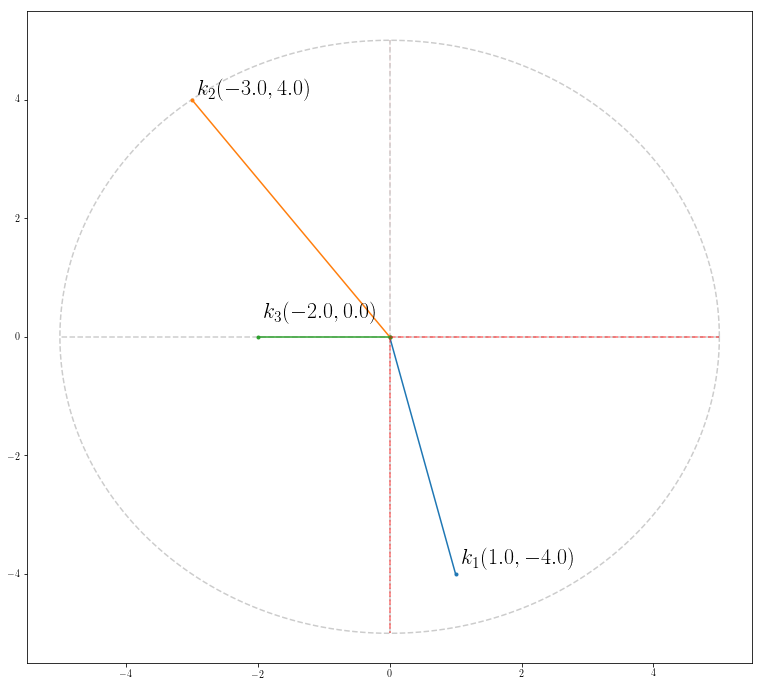

[ 4. -3. -4.  1.  0. -2.]


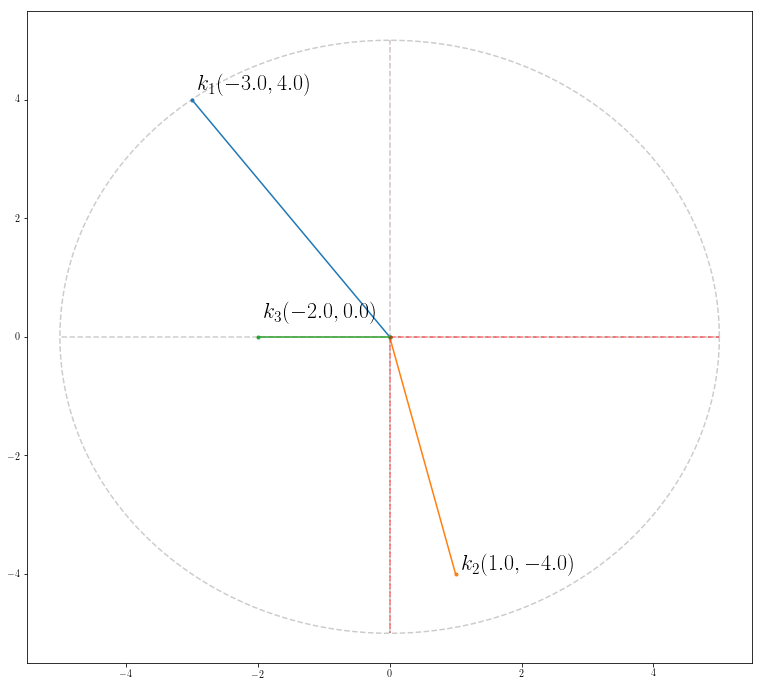

[-4.  1.  4. -2.  0. -1.]


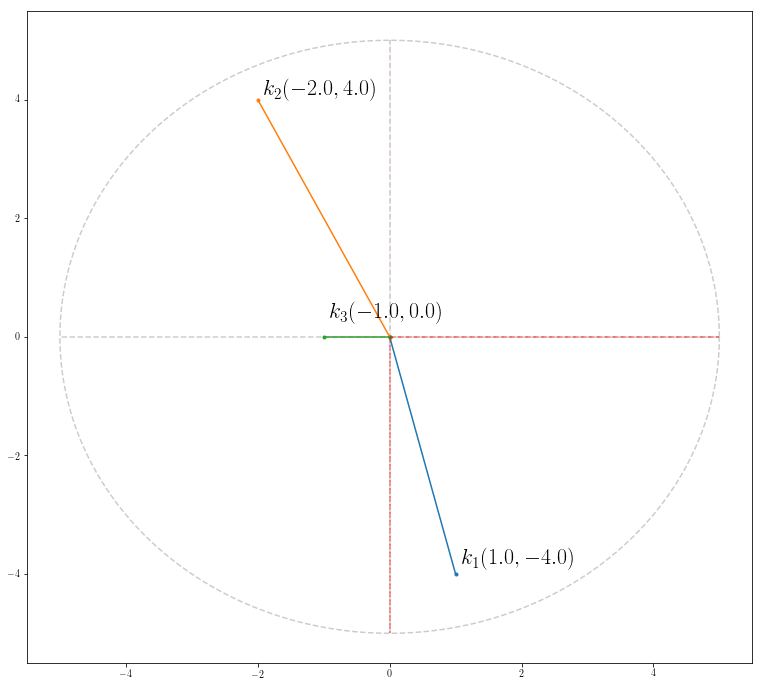

[-4.  2.  4. -3.  0. -1.]


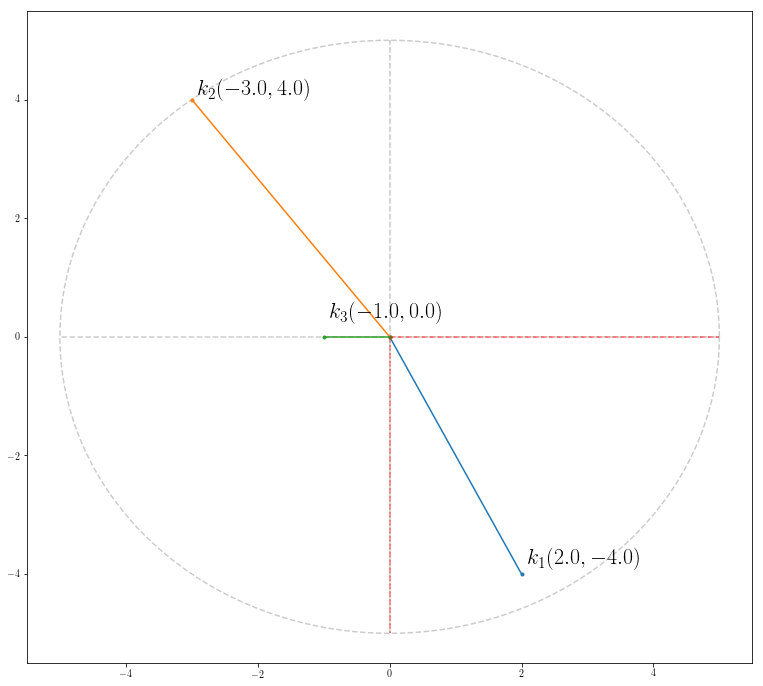

[-3.  3.  3. -4.  0. -1.]


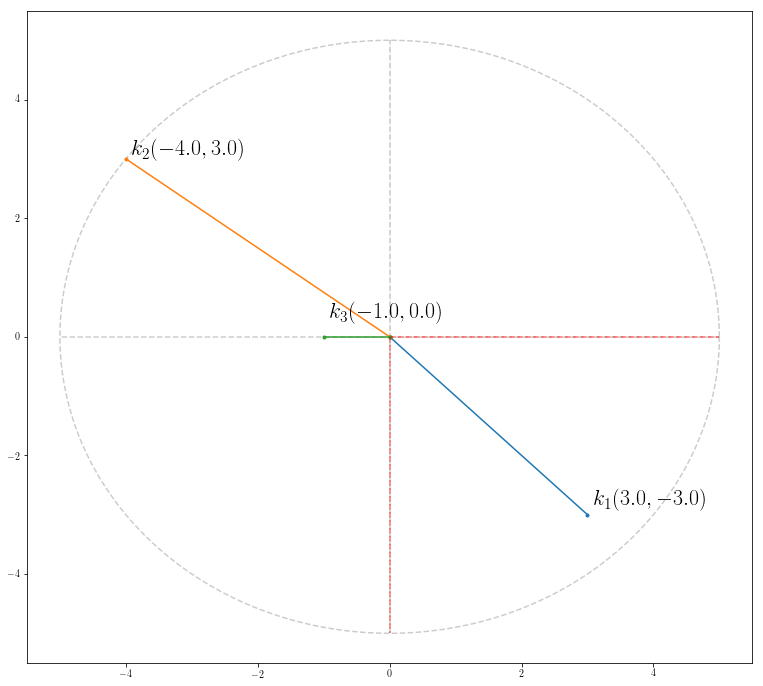

[ 3. -4. -3.  3.  0. -1.]


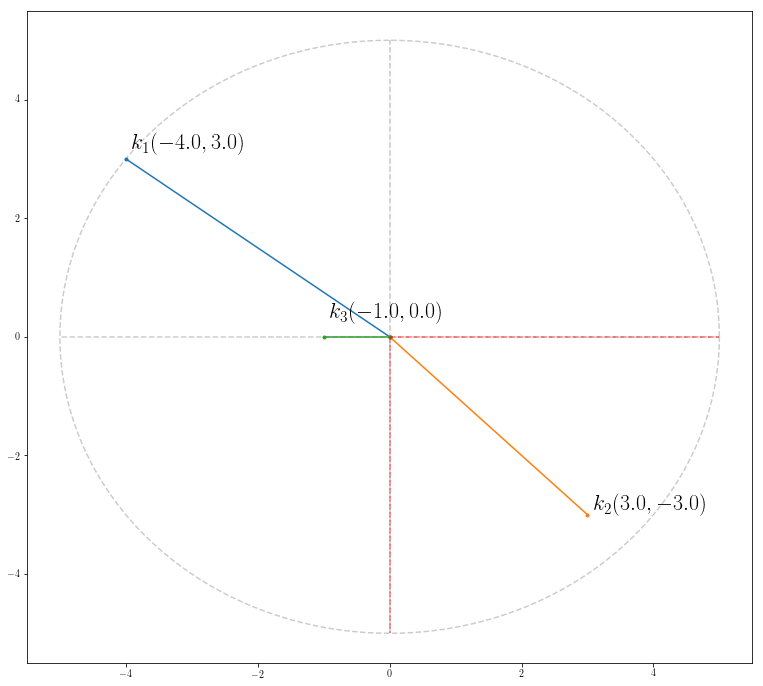

[ 4. -3. -4.  2.  0. -1.]


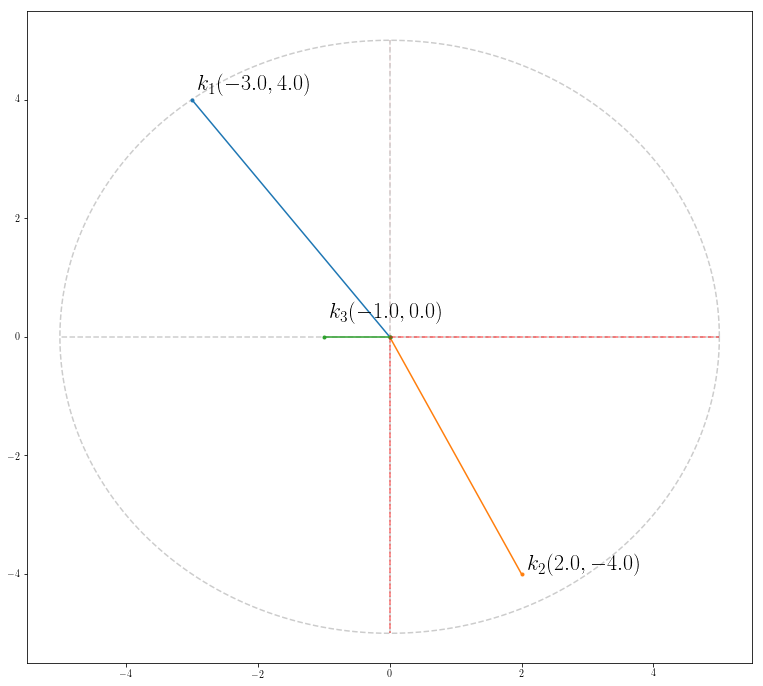

[ 4. -2. -4.  1.  0. -1.]


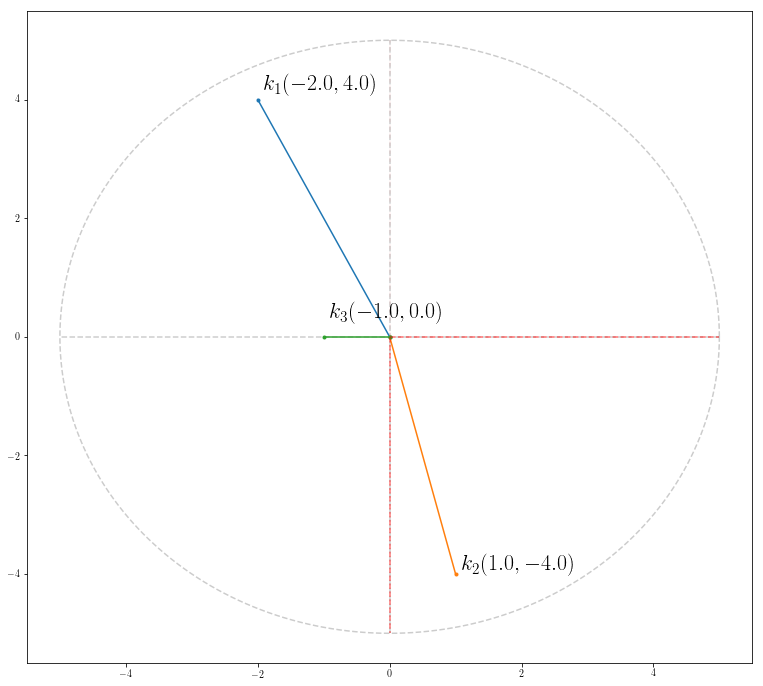

[-4.  2.  4. -1.  0.  1.]


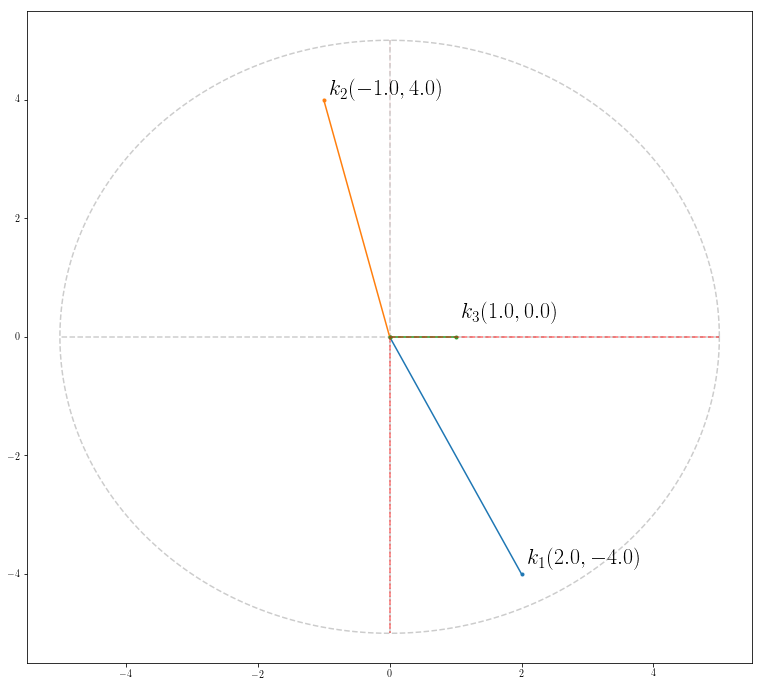

[-4.  3.  4. -2.  0.  1.]


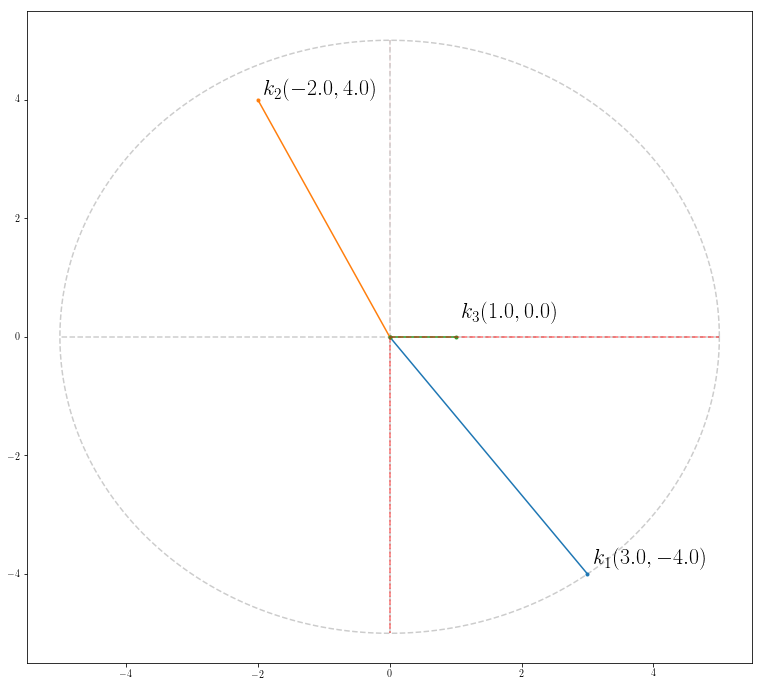

[-3.  4.  3. -3.  0.  1.]


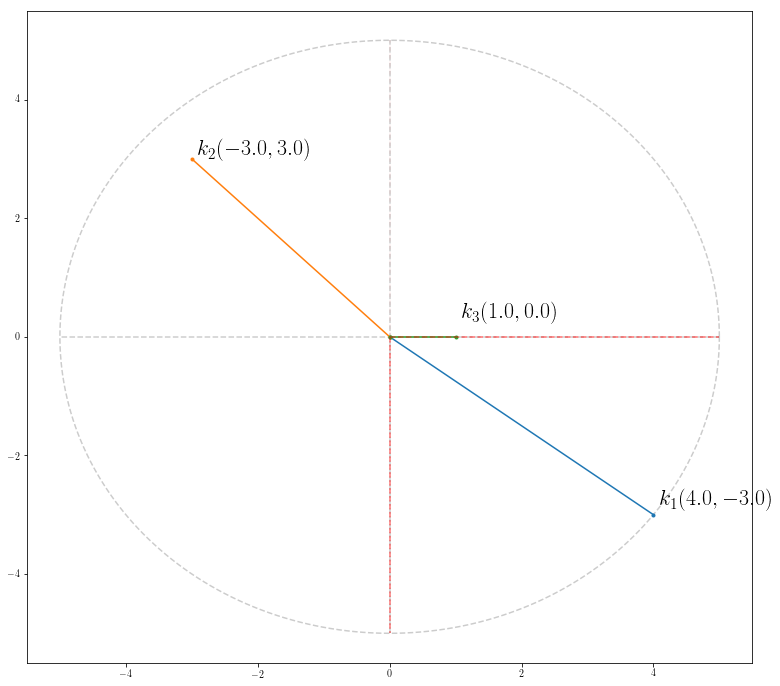

[ 3. -3. -3.  4.  0.  1.]


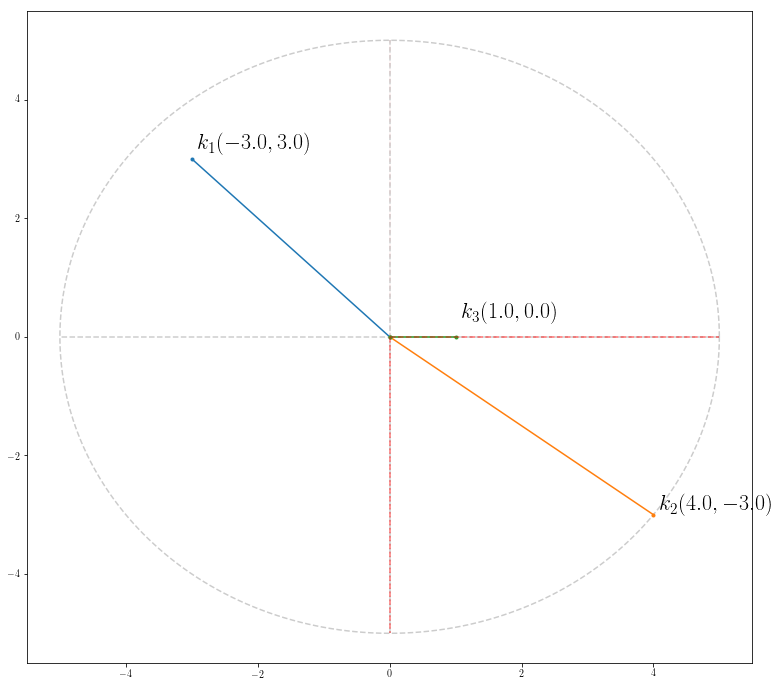

[ 4. -2. -4.  3.  0.  1.]


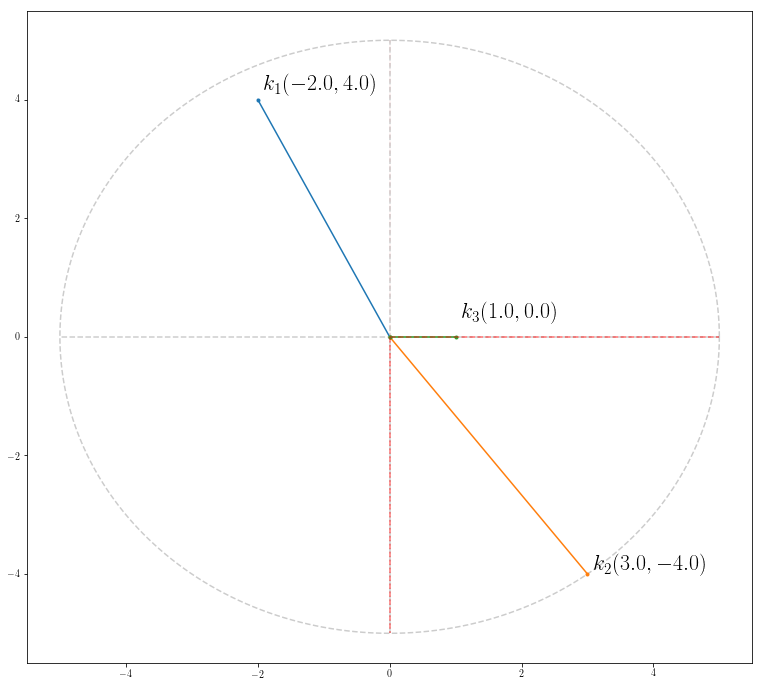

[ 4. -1. -4.  2.  0.  1.]


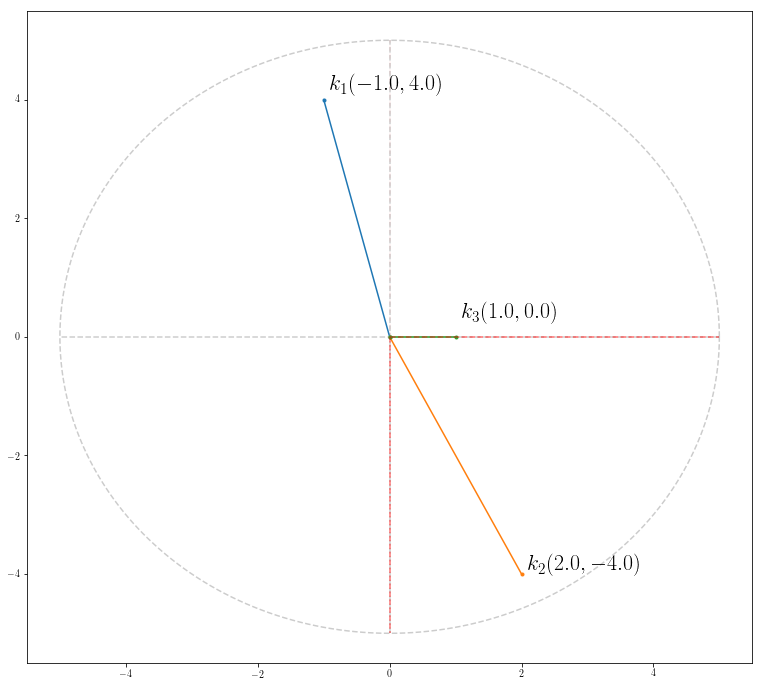

[-4.  3.  4. -1.  0.  2.]


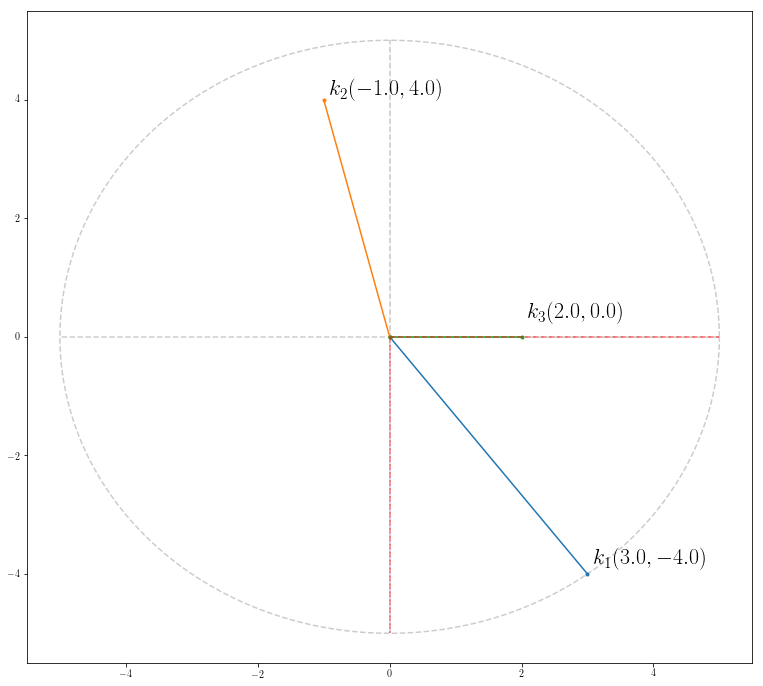

[ 4. -1. -4.  3.  0.  2.]


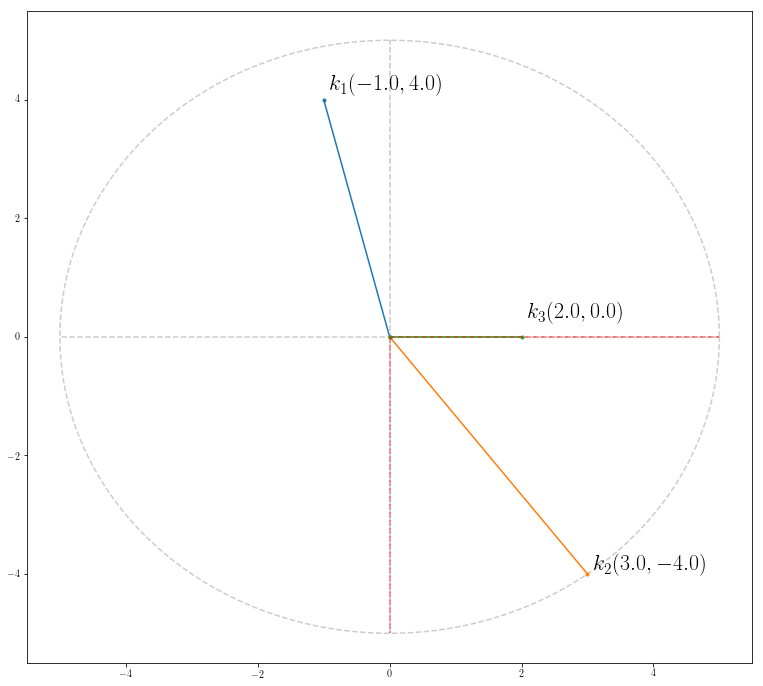

In [22]:

dsec = sector

n_theta   = post_data.num_sect
dtheta    =  np.pi / n_theta
theta     = np.arange(-np.pi/2, np.pi/2 + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

for i in mid_theta:
    print(i)
# for l in range(post_data.num_k1_sects):
#     print("\n\nl = {}".format(l))
for i, k_vec in enumerate(match[:]):
    print(k_vec)
    plt.figure(figsize = (13, 12))
    plt.plot(x, y, 'k--', alpha = 0.2)
    plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
    plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
    for aa in range(post_data.num_sect):
        ## Plot sectors
        plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
        plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

    ## Print missing 
    p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], '.-', alpha = 1)
    p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], '.-', alpha = 1)
    p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], '.-', alpha = 1)
#     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
#     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
#         p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
#         p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
#         p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
    plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
    plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
    plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)

    plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
    plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
#         plt.plot([0, R*np.cos(theta[dsec + l] - dtheta/2)], [0, R*np.sin(theta[dsec + l] - dtheta/2)], '--', alpha = 0.5, color = "b")
#         plt.plot([0, R*np.cos(theta[dsec + l] + dtheta/2)], [0, R*np.sin(theta[dsec + l] + dtheta/2)], '--', alpha = 0.5, color = "b")
#         plt.plot([0, R*np.cos(theta[dsec + 5] - dtheta/2)], [0, R*np.sin(theta[dsec + 5] - dtheta/2)], '--', alpha = 0.5, color = "b")
#         plt.plot([0, R*np.cos(theta[dsec + 5] + dtheta/2)], [0, R*np.sin(theta[dsec + 5] + dtheta/2)], '--', alpha = 0.5, color = "b")
    plt.show()

In [114]:
dsec = 0
sec_0 = dsec
sec = post_data.num_sect//2 + dsec
pos_present = []
neg_present = []
pos_missing = []
neg_missing = []
pos_missing_indices = []
neg_missing_indices = []

print("sec_0: {}\nsec_opp: {}".format(sec_0, sec))

for i in range(post_data.num_wv[sec_0, 0]):
    k3_x = post_data.wv[sec_0, 0, K3_X, i]
    k3_y = post_data.wv[sec_0, 0, K3_Y, i]
    print("i: {}\t - {} - {}\t {}".format(i, post_data.wv[sec_0, 0, :6, i], post_data.wv[sec, 0, :6, i], np.arctan2(k3_x, k3_y)))

for l in range(post_data.num_k1_sects):
    opp_sec_list = post_data.wv[sec, l, :6, :]
    sec_0_list   = post_data.wv[sec_0, l, :6, :]
    n = post_data.num_wv[sec_0, l]
    
    pos_present.append([])
    neg_present.append([])
    pos_missing.append([])
    neg_missing.append([])
    pos_missing_indices.append([])
    neg_missing_indices.append([])
    
    print("\n\nl = {}".format(l))
    print("\t\tPositive k Search\t\t\t-\t\t\tNegative k Search\t\t\t-\t\t\tNegative k Search")
    for i in range(n):
        k_sec_0   = post_data.wv[sec_0, l, :6, i]
        k_sec_opp = post_data.wv[sec, l, :6, i]
        pos_k_sear = pos_k_search(k_sec_0, opp_sec_list)
#         if pos_k_sear[0] == False:
#             pos_missing_indices[l].append(i)
#             pos_missing[l].append(pos_k_sear[-1])

        neg_k_sear = neg_k_search(k_sec_0, opp_sec_list)
        if neg_k_sear[0] == False:
            neg_missing_indices[l].append(i)
            neg_missing[l].append(neg_k_sear[-1])

        neg_k_sear_sec = neg_k_search(k_sec_opp, sec_0_list)
        if neg_k_sear_sec[0] == False:
            neg_missing[l].append(neg_k_sear_sec[-1])
        pos_present[l].append(pos_k_sear)
        neg_present[l].append(neg_k_sear)
        print("i: {}\t{}\t-\t{}\t-\t{}".format(i, pos_k_sear, neg_k_sear, neg_k_sear_sec)) 
    print()
    print("Pos match: {}".format(np.all(np.asarray(np.asarray(pos_present[l])[:, 0]))))
    print("Neg match: {}".format(np.all(np.asarray(np.asarray(neg_present[l])[:, 0]))))

sec_0: 0
sec_opp: 2
i: 0	 - [-3.  1. -1.  0. -4.  1.] - [-2. -3. -1. -1. -3. -4.]	 -1.3258176636680326
i: 1	 - [-3.  2. -1. -1. -4.  1.] - [-2. -2. -1. -2. -3. -4.]	 -1.3258176636680326
i: 2	 - [-3.  4. -1. -3. -4.  1.] - [-1. -3. -2. -1. -3. -4.]	 -1.3258176636680326
i: 3	 - [-2.  1. -2.  0. -4.  1.] - [-1. -2. -2. -2. -3. -4.]	 -1.3258176636680326
i: 4	 - [-2.  2. -2. -1. -4.  1.] - [-1. -1. -2. -3. -3. -4.]	 -1.3258176636680326
i: 5	 - [-2.  3. -2. -2. -4.  1.] - [ 1. -2. -4. -2. -3. -4.]	 -1.3258176636680326
i: 6	 - [-2.  4. -2. -3. -4.  1.] - [ 1. -1. -4. -3. -3. -4.]	 -1.3258176636680326
i: 7	 - [-1.  1. -3.  0. -4.  1.] - [ 2. -4. -5.  0. -3. -4.]	 -1.3258176636680326
i: 8	 - [-1.  2. -3. -1. -4.  1.] - [-3.  2.  0. -5. -3. -3.]	 -1.3258176636680326
i: 9	 - [-3.  1. -1.  1. -4.  2.] - [-2. -3. -1.  0. -3. -3.]	 -1.1071487177940904
i: 10	 - [-3.  2. -1.  0. -4.  2.] - [-2. -2. -1. -1. -3. -3.]	 -1.1071487177940904
i: 11	 - [-3.  4. -1. -2. -4.  2.] - [-1. -3. -2.  0. -3. -3.]	 -1

In [16]:
print(wv[sec_0][:6, :].shape)
print(wv[sec][:6, :].shape)
for i in range(n):
    k_dsec = wv[sec_0][:6, i]
    k_sec = wv[sec][:6, i]
    print(k_sec)

NameError: name 'wv' is not defined

In [38]:
print(wv_1.shape)
print(wv_1[0, 0, :6, :])

print(np.sum(post_data.num_wv))
combined = np.zeros((6, np.sum(post_data.num_wv)))
nn = 0
for i in range(post_data.num_sect):
    for j in range(post_data.num_k1_sects):
        for n in range(post_data.num_wv[i, j]):
            combined[:, nn] = post_data.wv[i, 0, :6, n]
            nn += 1

missing_first_pass = []
for i in range(num_wv_1[0,0]):
    k_vec = wv_1[0, 0, :6, i]
    res = k_search(k_vec, combined[:])
    if res[0] == False:
        missing_first_pass.append(k_vec)
    print("i: {}\t{}".format(i, res))
print(len(missing_first_pass))

(1, 1, 16, 752)
[[-4. -3. -3. ...  3.  3.  4.]
 [ 0. -2. -1. ...  1.  2.  0.]
 [-1. -2. -2. ...  2.  2.  1.]
 [ 0.  2.  1. ... -1. -2.  0.]
 [-5. -5. -5. ...  5.  5.  5.]
 [ 0.  0.  0. ...  0.  0.  0.]]
664
i: 0	(True, 0, array([-4.,  0., -1.,  0., -5.,  0.]))
i: 1	(True, 4, array([-3., -2., -2.,  2., -5.,  0.]))
i: 2	(True, 5, array([-3., -1., -2.,  1., -5.,  0.]))
i: 3	(True, 6, array([-3.,  0., -2.,  0., -5.,  0.]))
i: 4	(True, 7, array([-3.,  1., -2., -1., -5.,  0.]))
i: 5	(True, 8, array([-3.,  2., -2., -2., -5.,  0.]))
i: 6	(True, 11, array([-2., -2., -3.,  2., -5.,  0.]))
i: 7	(True, 12, array([-2., -1., -3.,  1., -5.,  0.]))
i: 8	(True, 13, array([-2.,  0., -3.,  0., -5.,  0.]))
i: 9	(True, 14, array([-2.,  1., -3., -1., -5.,  0.]))
i: 10	(True, 15, array([-2.,  2., -3., -2., -5.,  0.]))
i: 11	(True, 19, array([-1.,  0., -4.,  0., -5.,  0.]))
i: 12	(True, 20, array([-4.,  0.,  0., -3., -4., -3.]))
i: 13	(True, 23, array([-3., -2., -1., -1., -4., -3.]))
i: 14	(True, 24, array([-

In [40]:
for i in range(10):
    print(missing_first_pass[i])

[-3. -4. -1.  4. -4.  0.]
[-3.  4. -1. -4. -4.  0.]
[-2. -4. -2.  4. -4.  0.]
[-2.  4. -2. -4. -4.  0.]
[-1. -4. -3.  4. -4.  0.]
[-1.  4. -3. -4. -4.  0.]
[-4.  2.  1. -4. -3. -2.]
[-3.  3.  0. -5. -3. -2.]
[ 0. -5. -3.  3. -3. -2.]
[ 1. -4. -4.  2. -3. -2.]


In [11]:
## Get sector lists
sec_0_0 = wv_2[0, 0, :6, :]
sec_1_0 = wv_2[1, 0, :6, :]

print(num_wv_1[0][0])

miss_first_pass = []
for i in range(num_wv_1[0][0]):
               
    ## Choose k_vec to search sector lists with
    k_vec = wv_1[0, 0, :6, i]
    
    ## Search
    k_search_0 = k_search(k_vec, sec_0_0)
    k_search_1 = k_search(k_vec, sec_1_0)   
    if k_search_0[0] == False and k_search_1[0] == False:
        miss_first_pass.append(k_vec)
        
    ## Print results
#     print("i: {}\t{}\t-\t{}".format(i, k_search_0, ())) 
#     print("i: {}\t{}\t-\t{}".format(i, k_search_0, k_search_1)) 

# fully_missing = []
for i, k in enumerate(miss_first_pass):
#     k_search_1 = k_search(k, sec_1_0)
#     if k_search_1[0] == False:
#         fully_missing.append(k_search_1[-1])
    print(i, k)

# for i, k in enumerate(fully_missing):
#     print(i, k)

276
0 [-3.  1.  1. -3. -2. -2.]
1 [ 1. -3. -3.  1. -2. -2.]
2 [-3.  2.  1. -3. -2. -1.]
3 [-2.  3.  0. -4. -2. -1.]
4 [ 0. -4. -2.  3. -2. -1.]
5 [ 1. -3. -3.  2. -2. -1.]
6 [-3. -2.  1.  3. -2.  1.]
7 [ 1.  3. -3. -2. -2.  1.]
8 [-3. -1.  1.  3. -2.  2.]
9 [ 1.  3. -3. -1. -2.  2.]
10 [-4.  0.  3. -2. -1. -2.]
11 [-3.  1.  2. -3. -1. -2.]
12 [ 2. -3. -3.  1. -1. -2.]
13 [ 3. -2. -4.  0. -1. -2.]
14 [-4.  0.  3. -1. -1. -1.]
15 [-3.  2.  2. -3. -1. -1.]
16 [-1.  3.  0. -4. -1. -1.]
17 [ 0. -4. -1.  3. -1. -1.]
18 [ 2. -3. -3.  2. -1. -1.]
19 [ 3. -1. -4.  0. -1. -1.]
20 [-2. -3.  1.  3. -1.  0.]
21 [-2.  3.  1. -3. -1.  0.]
22 [ 1. -3. -2.  3. -1.  0.]
23 [ 1.  3. -2. -3. -1.  0.]
24 [-4.  0.  3.  1. -1.  1.]
25 [-3. -2.  2.  3. -1.  1.]
26 [ 2.  3. -3. -2. -1.  1.]
27 [ 3.  1. -4.  0. -1.  1.]
28 [-4.  0.  3.  2. -1.  2.]
29 [-3. -1.  2.  3. -1.  2.]
30 [ 2.  3. -3. -1. -1.  2.]
31 [ 3.  2. -4.  0. -1.  2.]
32 [-3. -2.  3. -1.  0. -3.]
33 [-3. -1.  3. -2.  0. -3.]
34 [ 3. -2. -3. -1. 

[-3.  1.  1. -3. -2. -2.]


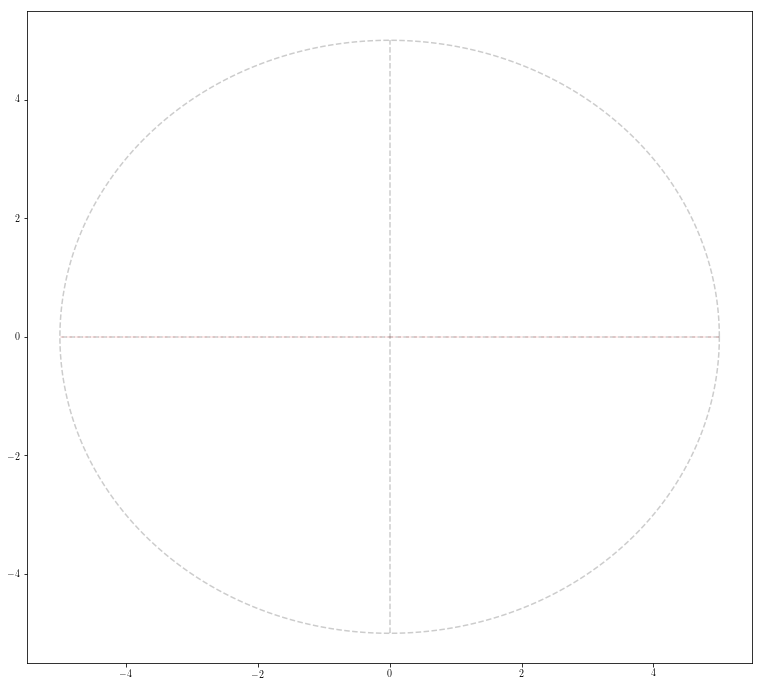

[ 1. -3. -3.  1. -2. -2.]


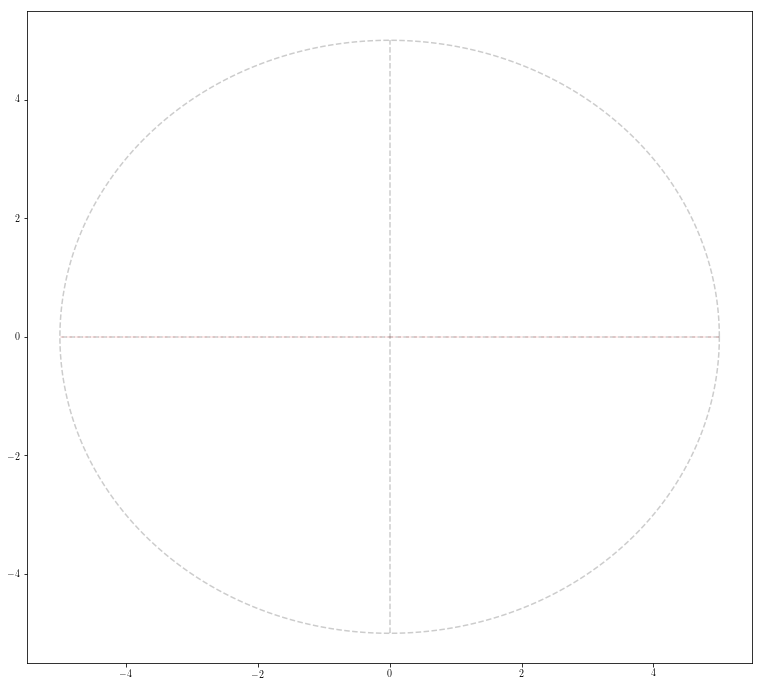

[-3.  2.  1. -3. -2. -1.]


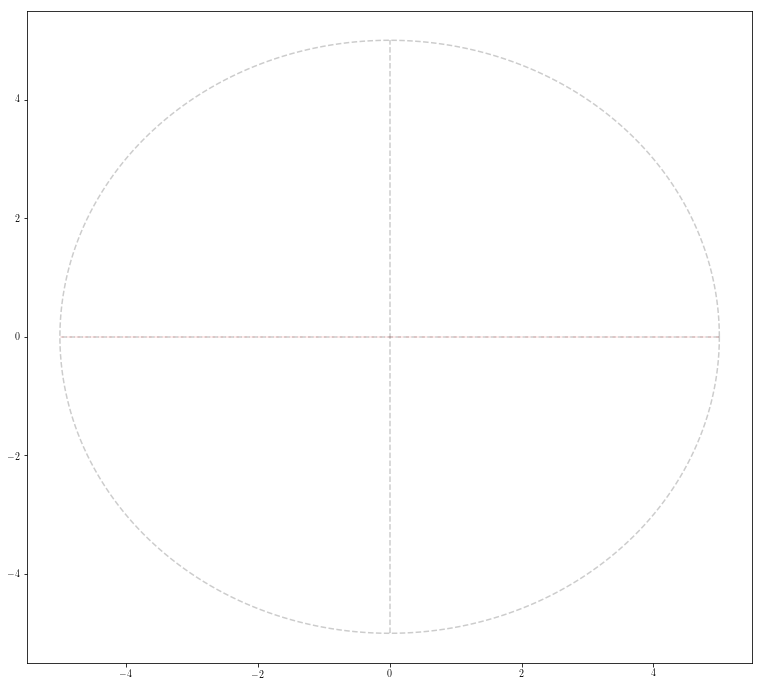

[-2.  3.  0. -4. -2. -1.]


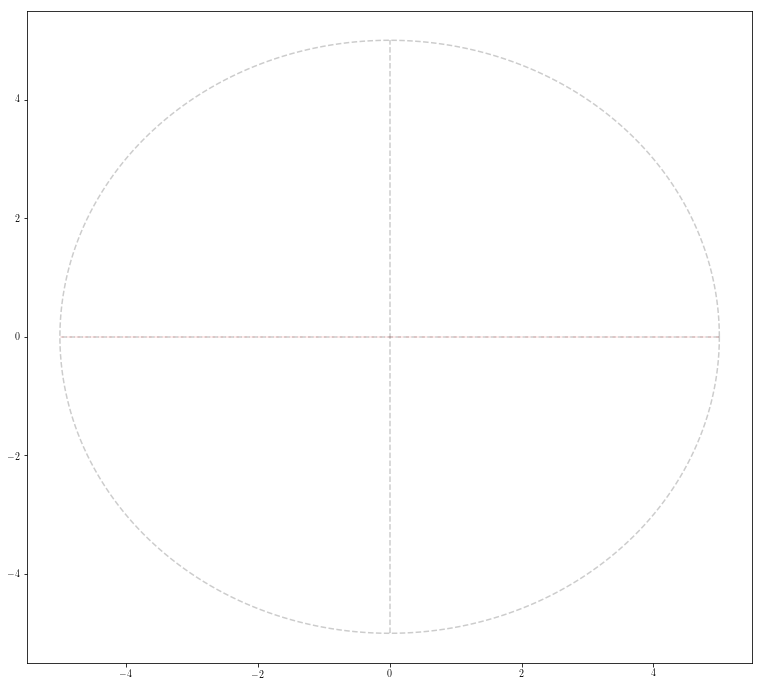

[ 0. -4. -2.  3. -2. -1.]


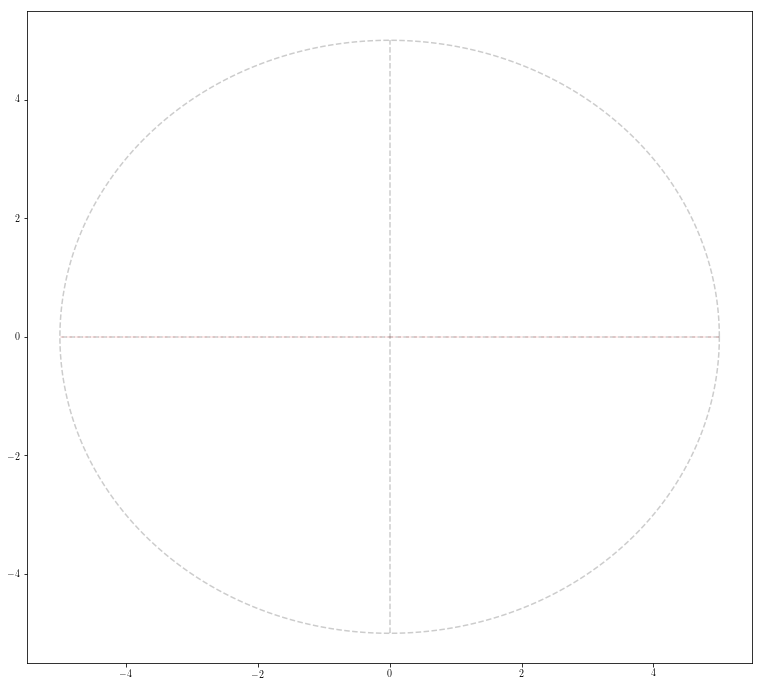

[ 1. -3. -3.  2. -2. -1.]


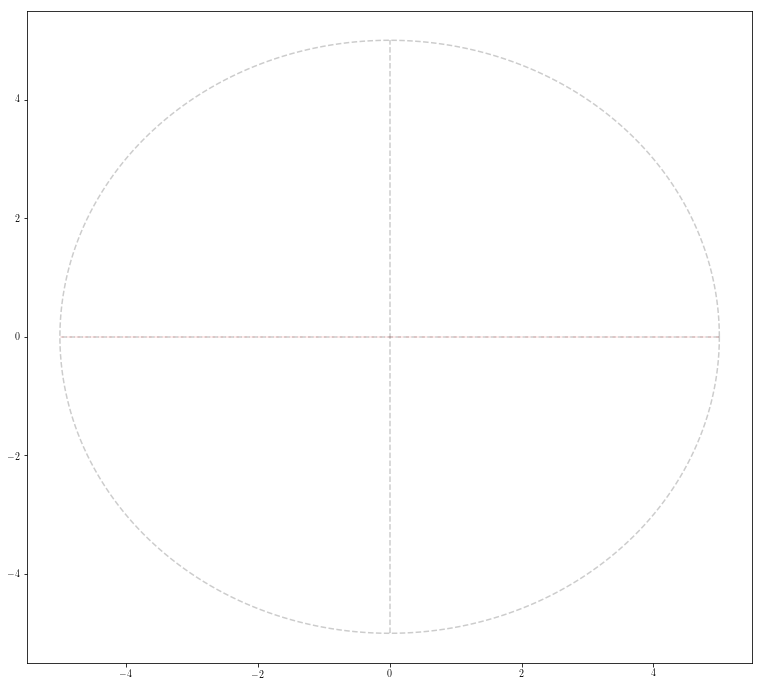

[-3. -2.  1.  3. -2.  1.]


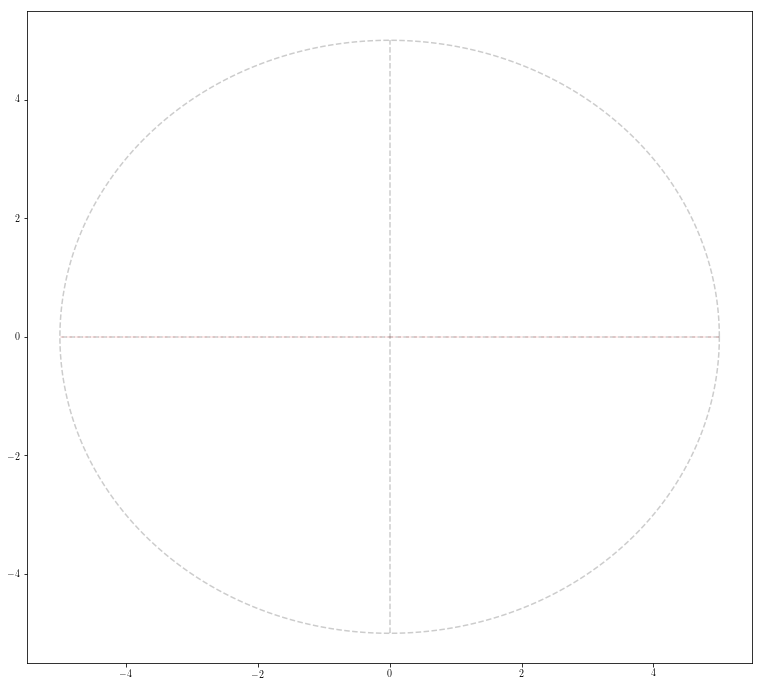

[ 1.  3. -3. -2. -2.  1.]


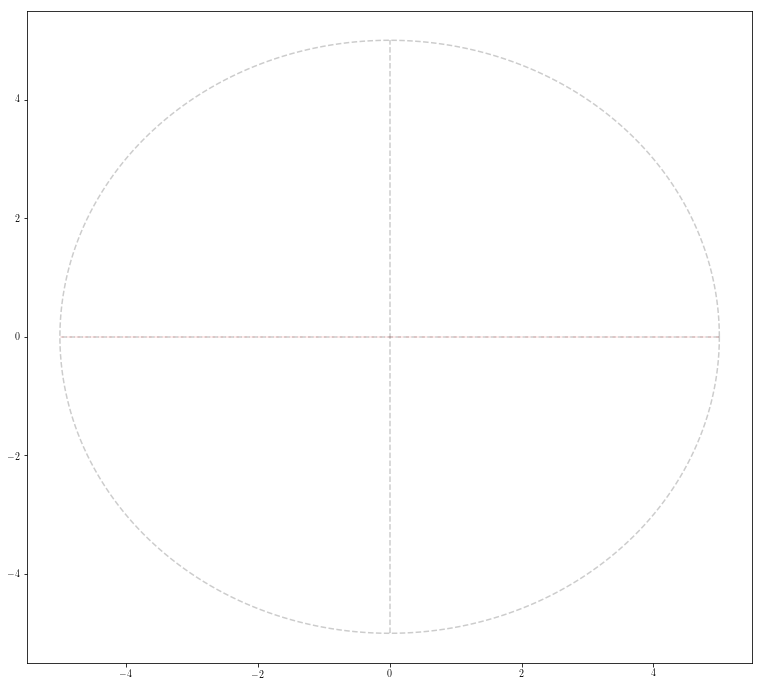

[-3. -1.  1.  3. -2.  2.]


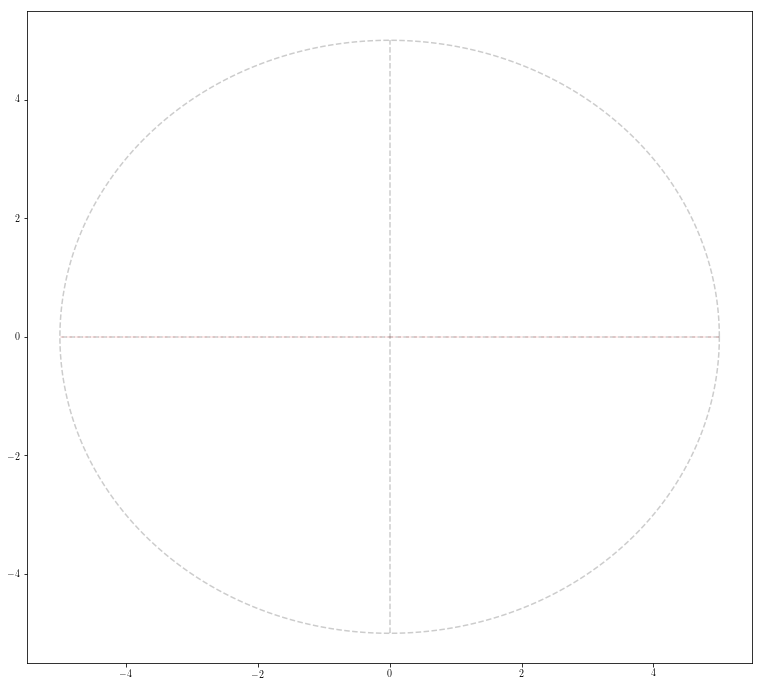

[ 1.  3. -3. -1. -2.  2.]


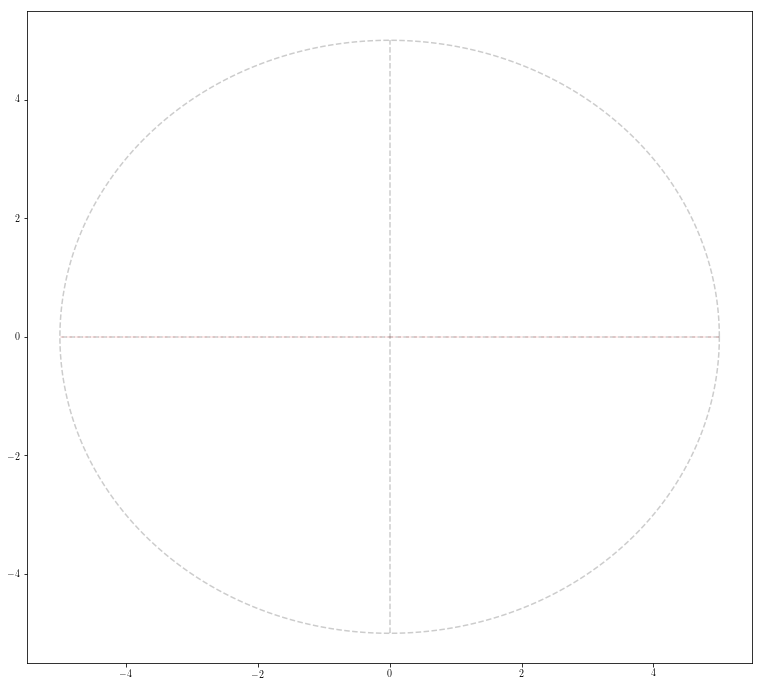

[-4.  0.  3. -2. -1. -2.]


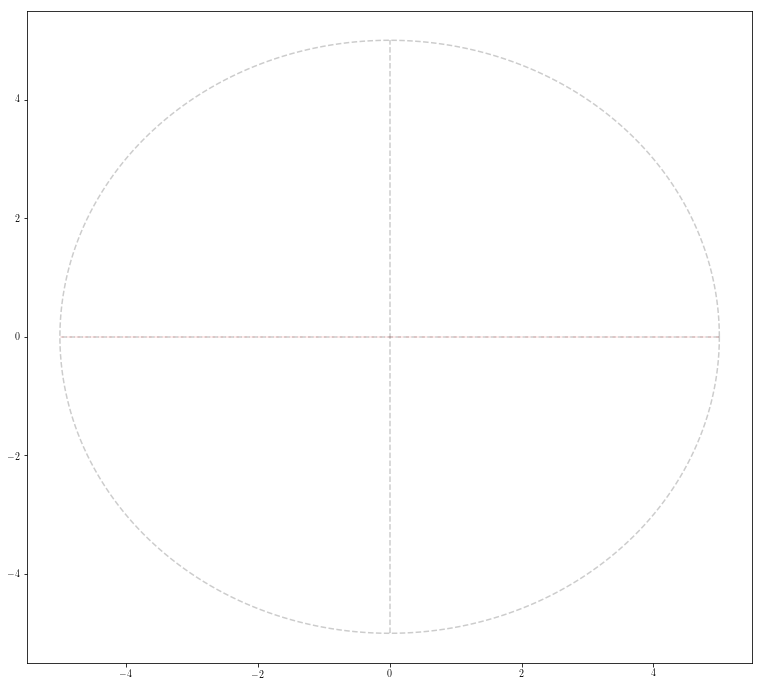

[-3.  1.  2. -3. -1. -2.]


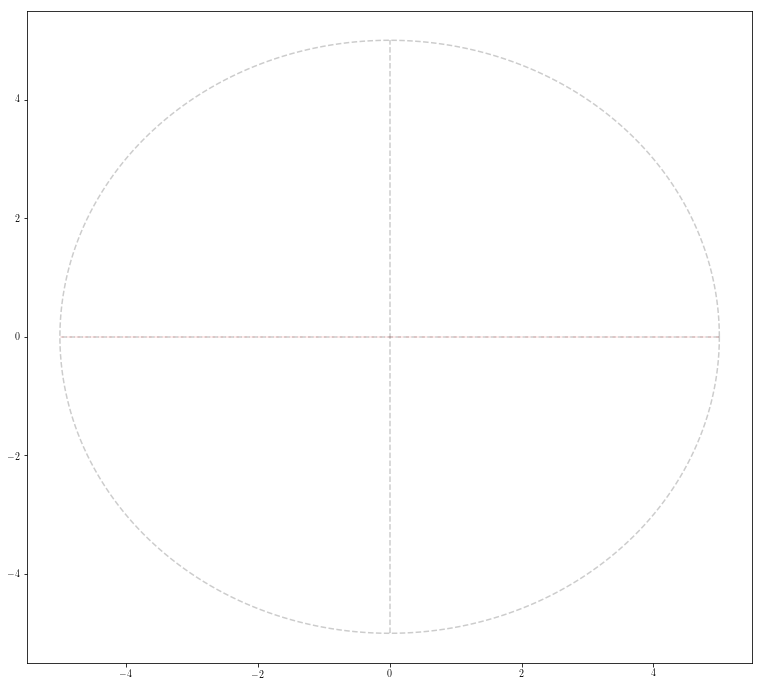

[ 2. -3. -3.  1. -1. -2.]


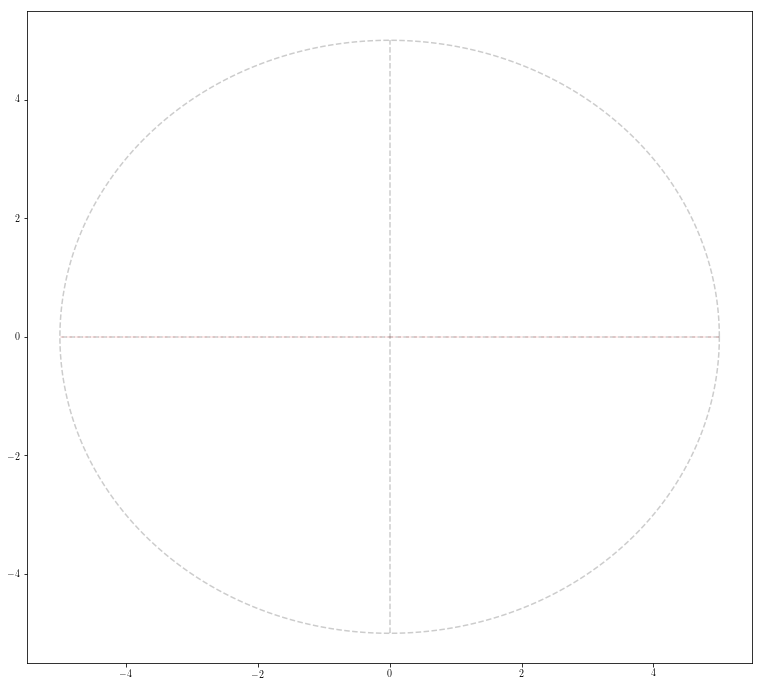

[ 3. -2. -4.  0. -1. -2.]


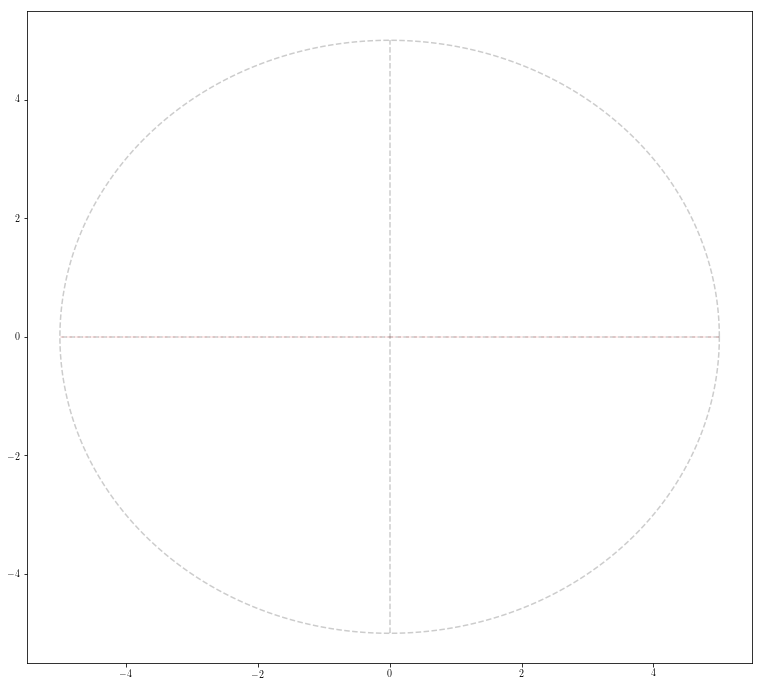

[-4.  0.  3. -1. -1. -1.]


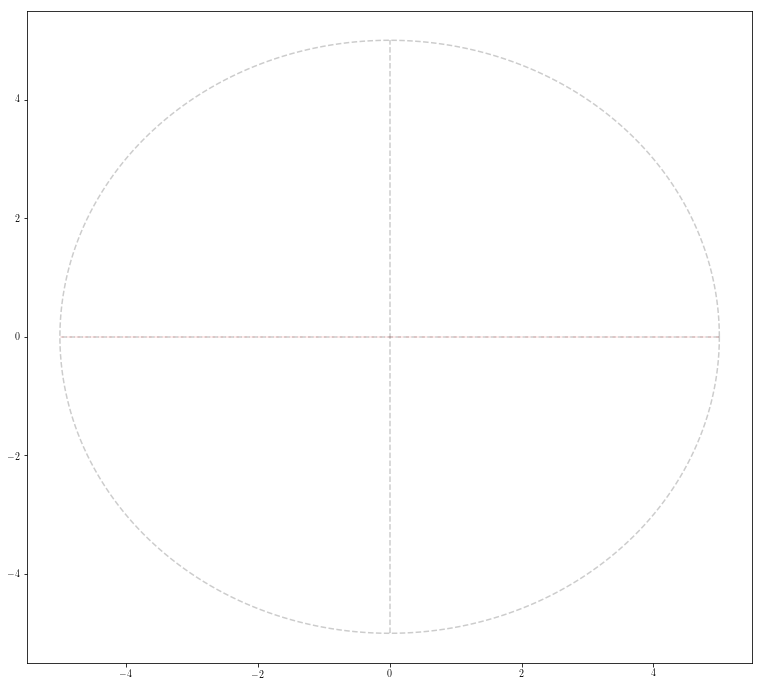

[-3.  2.  2. -3. -1. -1.]


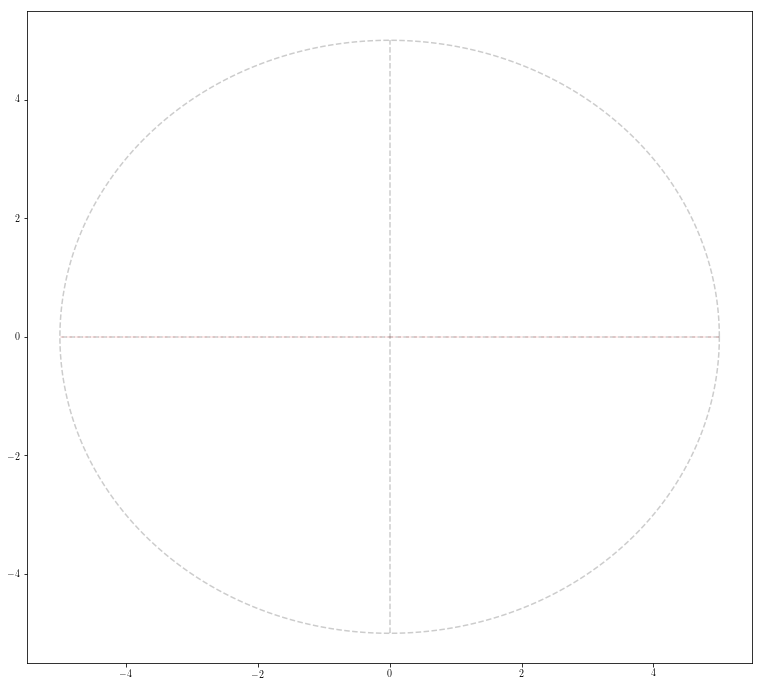

[-1.  3.  0. -4. -1. -1.]


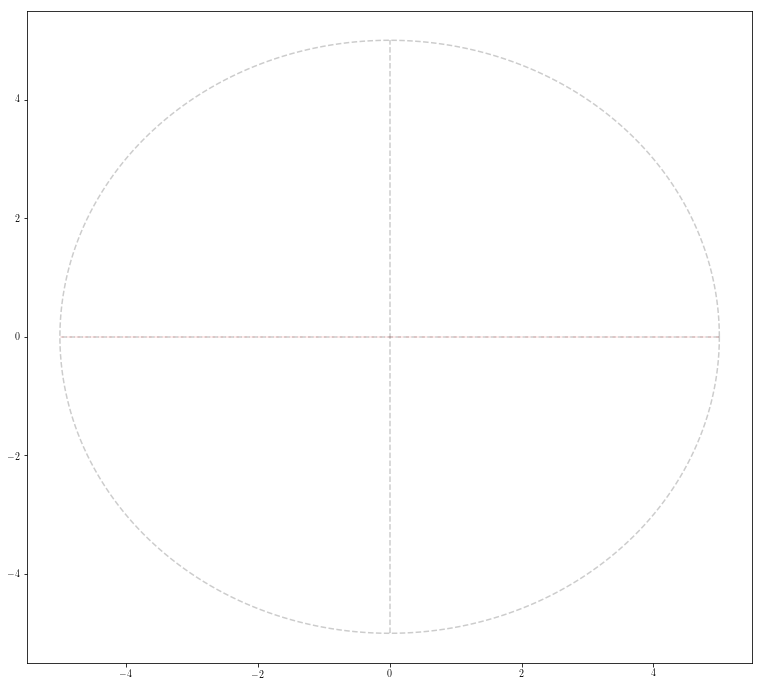

[ 0. -4. -1.  3. -1. -1.]


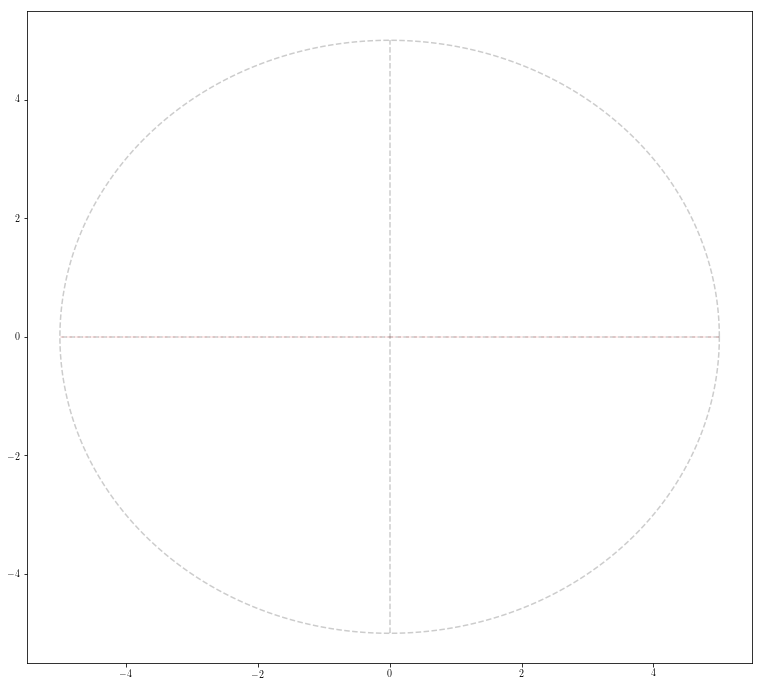

[ 2. -3. -3.  2. -1. -1.]


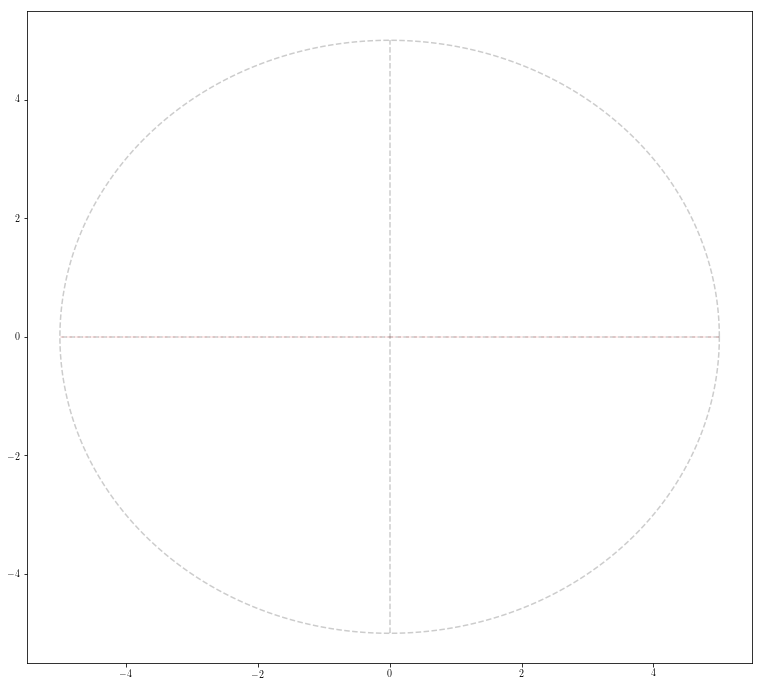

[ 3. -1. -4.  0. -1. -1.]


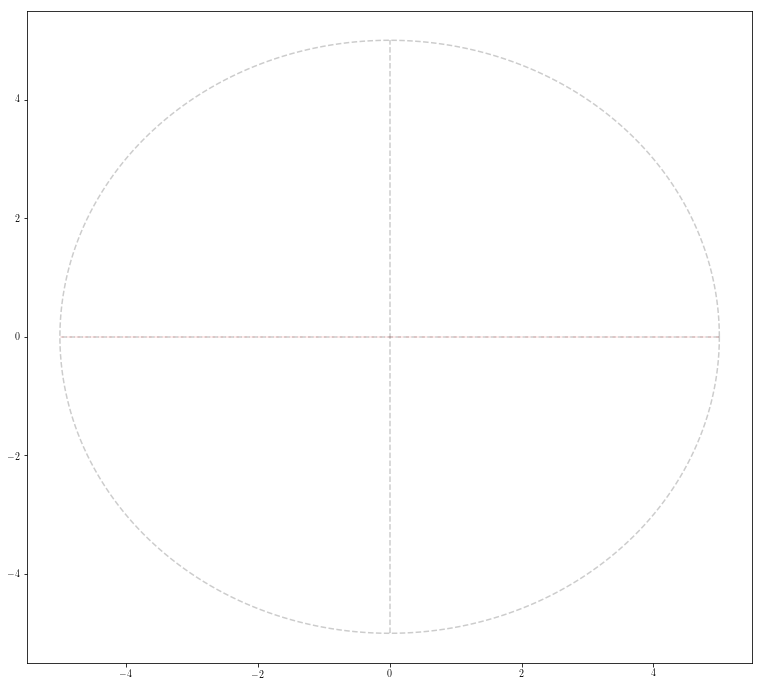

[-2. -3.  1.  3. -1.  0.]


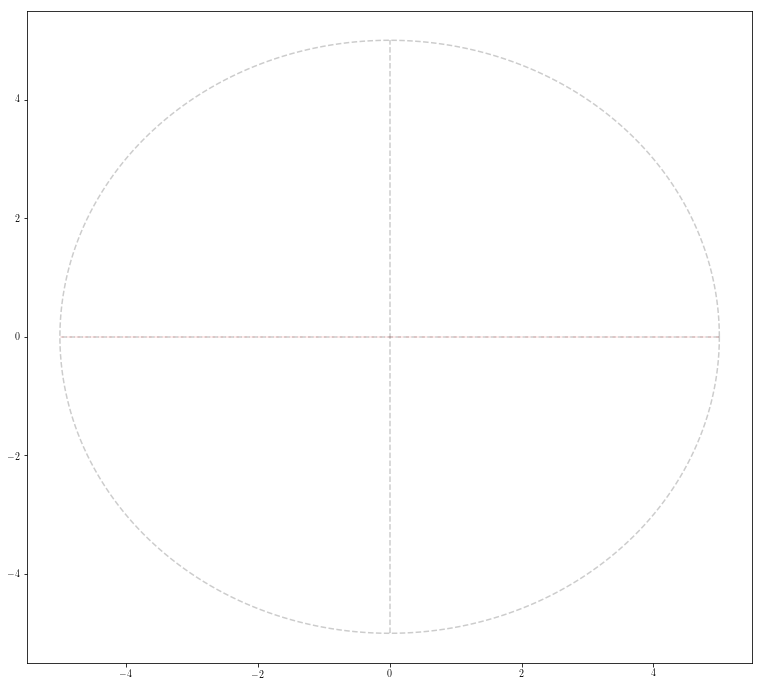

[-2.  3.  1. -3. -1.  0.]


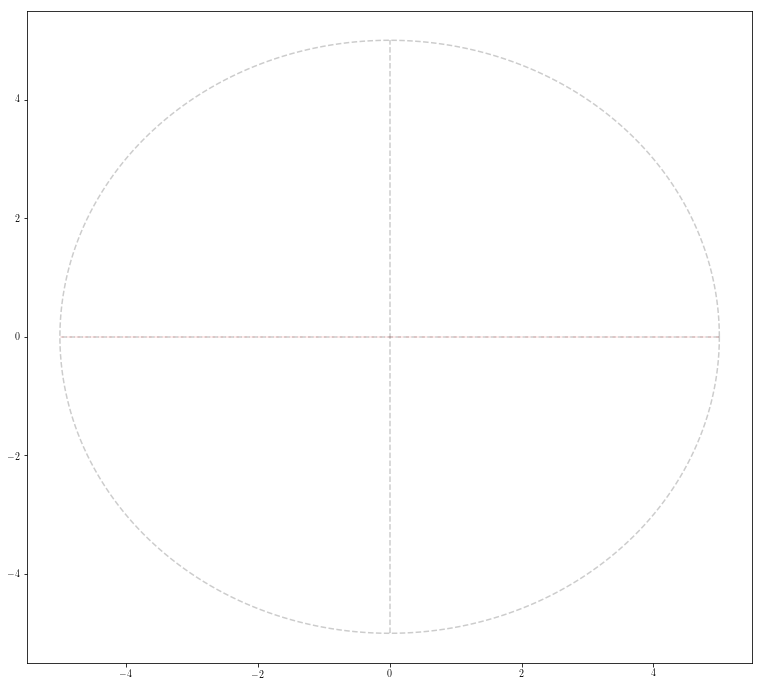

[ 1. -3. -2.  3. -1.  0.]


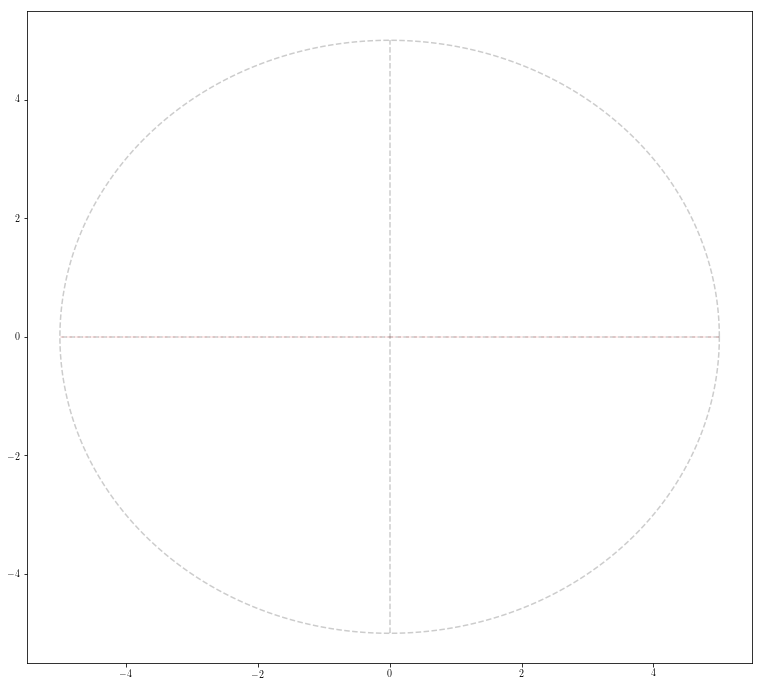

[ 1.  3. -2. -3. -1.  0.]


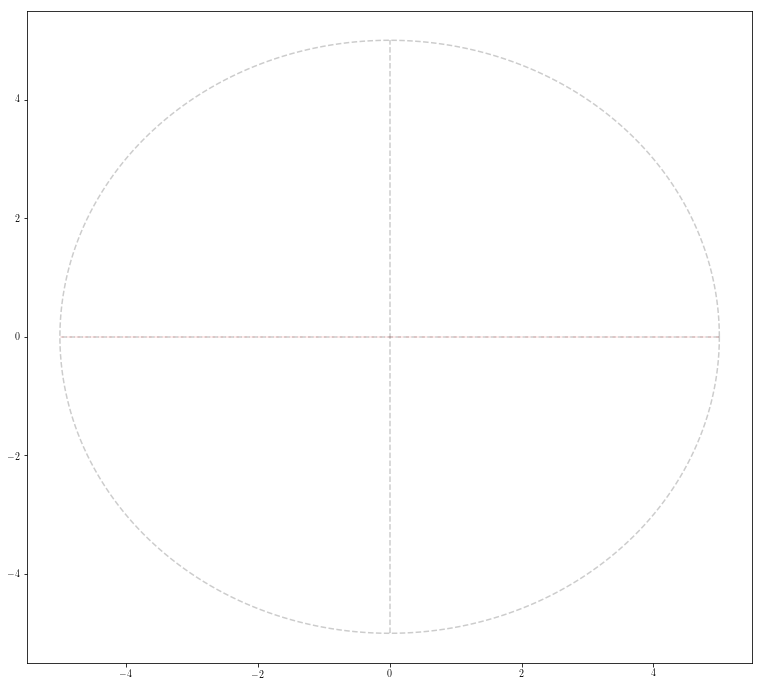

[-4.  0.  3.  1. -1.  1.]


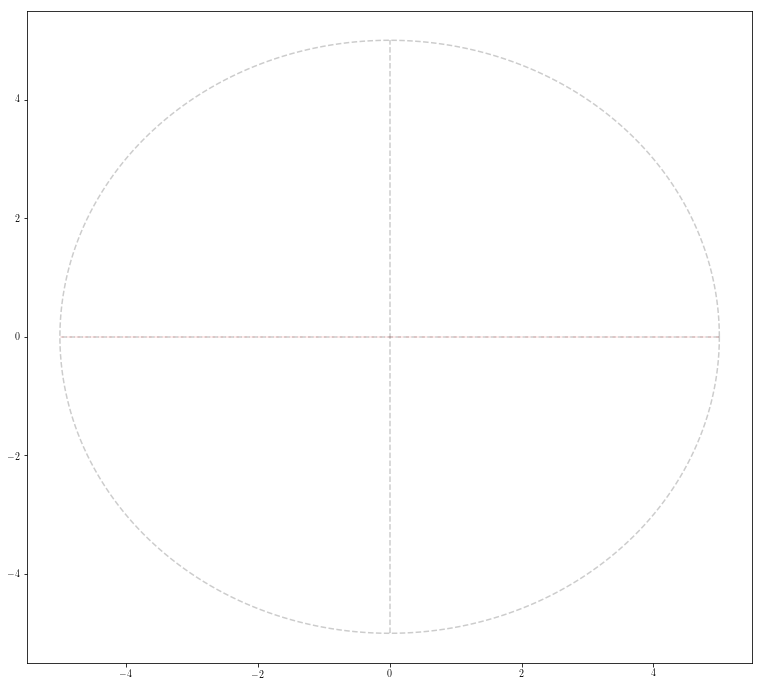

[-3. -2.  2.  3. -1.  1.]


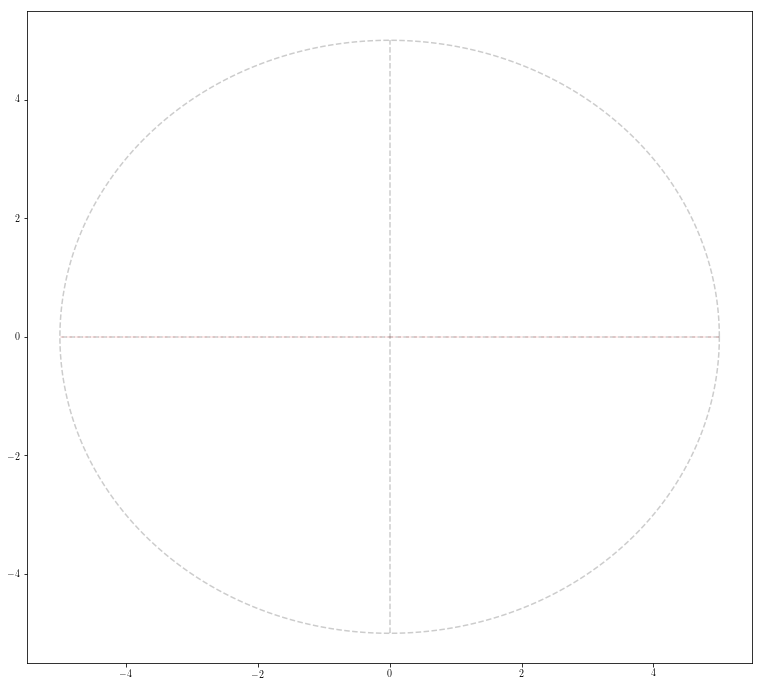

[ 2.  3. -3. -2. -1.  1.]


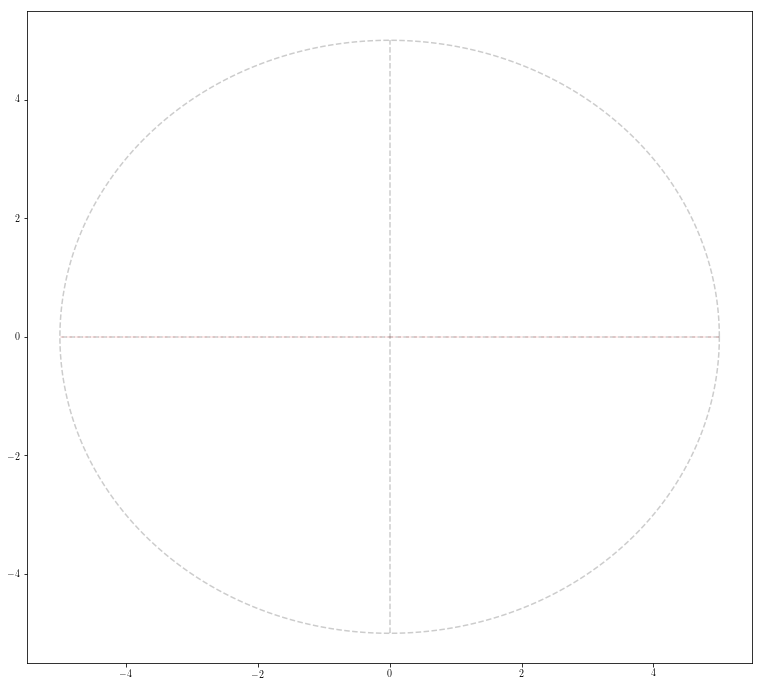

[ 3.  1. -4.  0. -1.  1.]


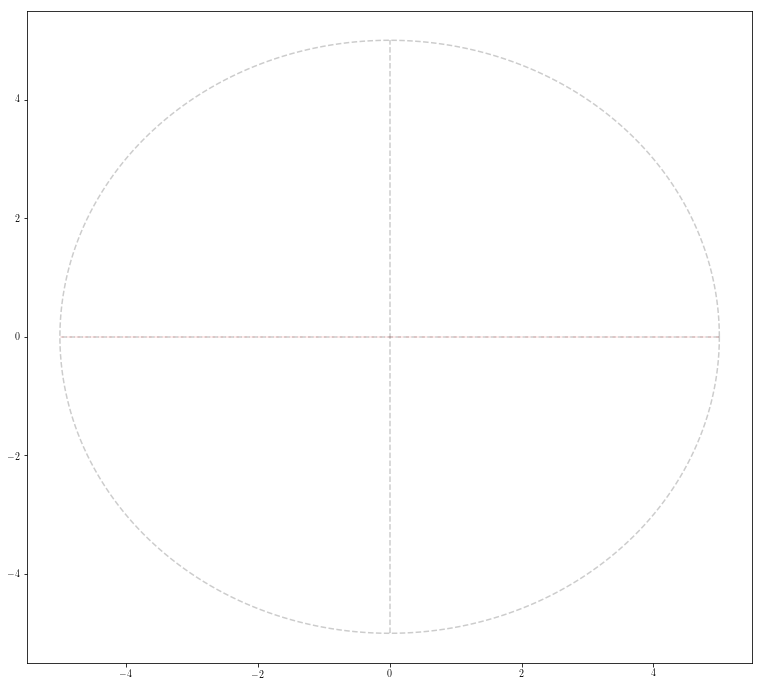

[-4.  0.  3.  2. -1.  2.]


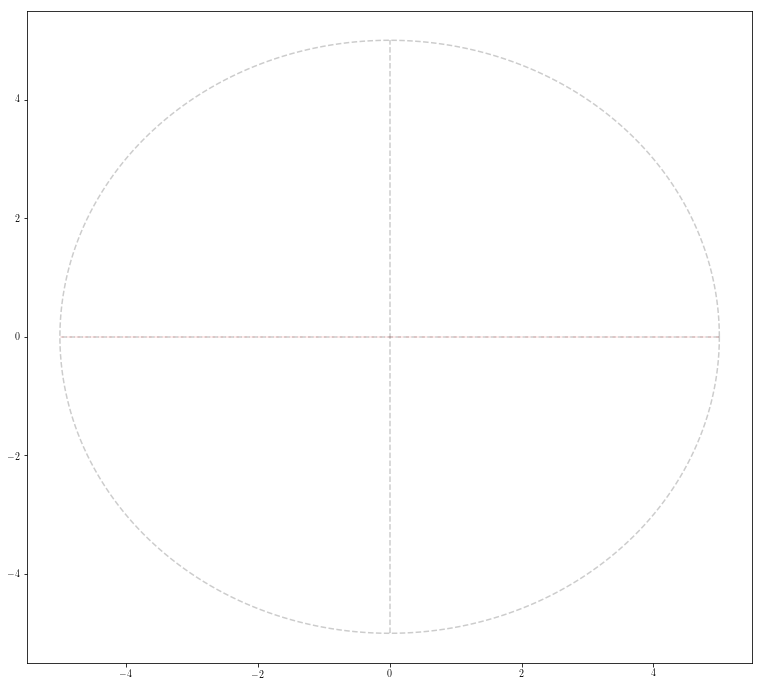

[-3. -1.  2.  3. -1.  2.]


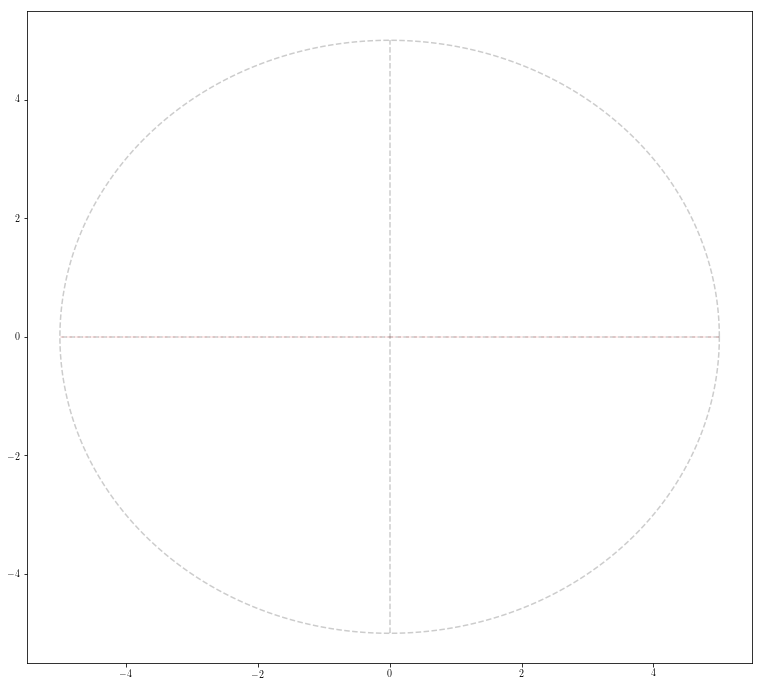

[ 2.  3. -3. -1. -1.  2.]


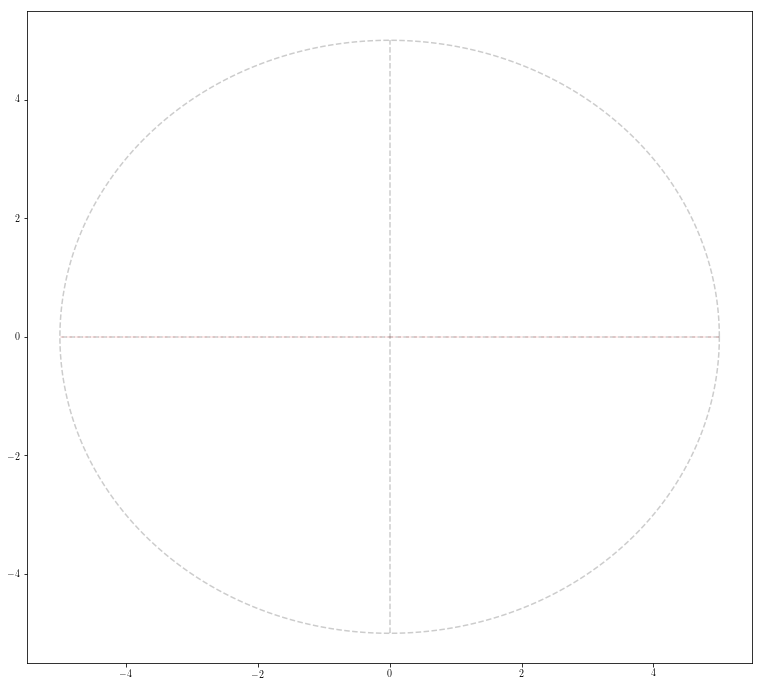

[ 3.  2. -4.  0. -1.  2.]


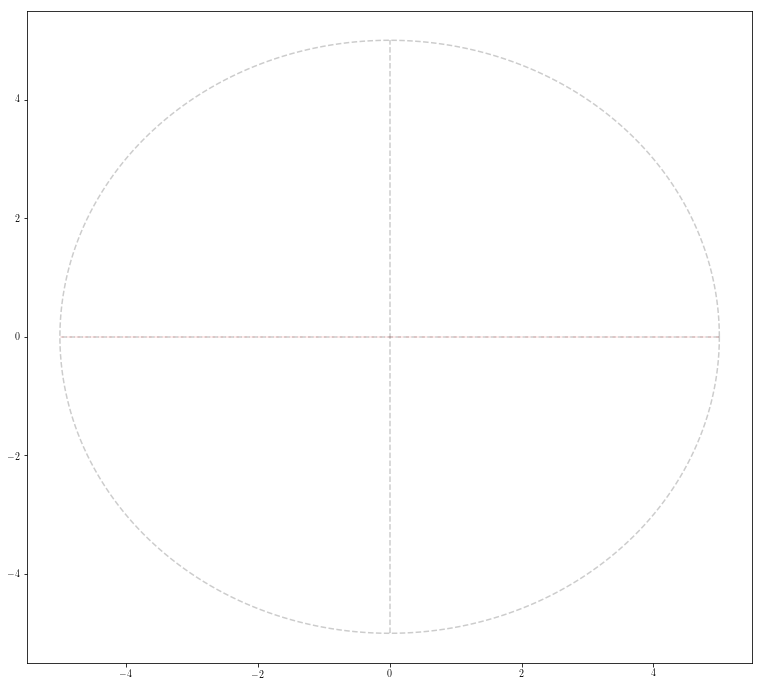

[-3. -2.  3. -1.  0. -3.]


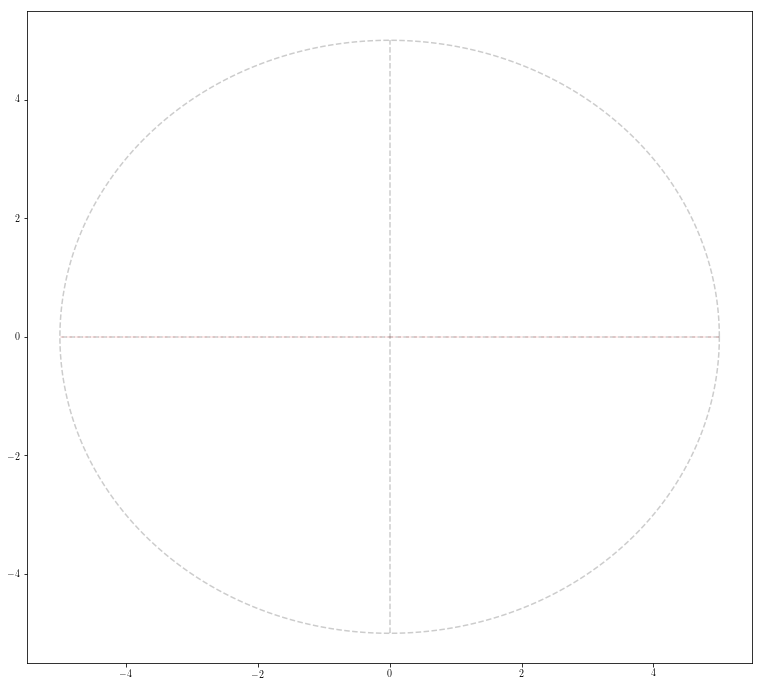

[-3. -1.  3. -2.  0. -3.]


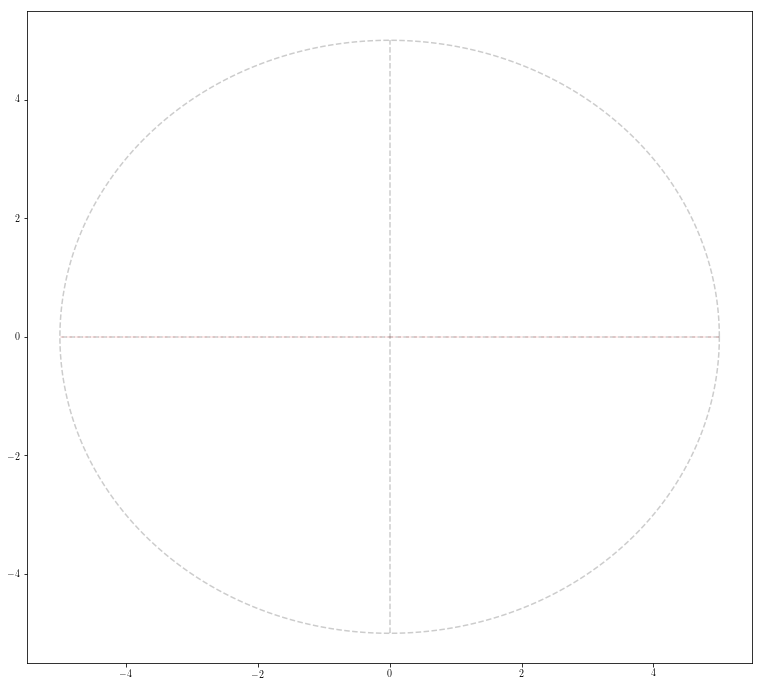

[ 3. -2. -3. -1.  0. -3.]


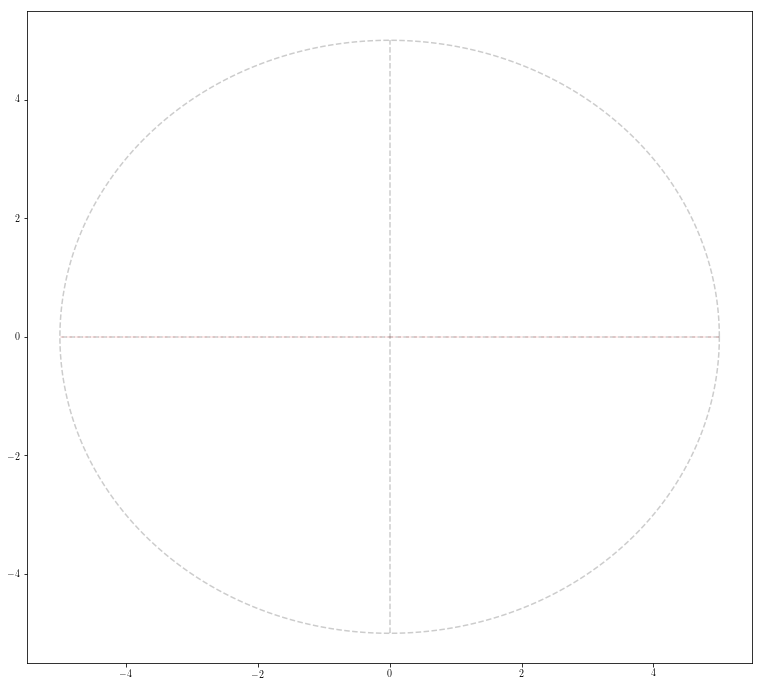

[ 3. -1. -3. -2.  0. -3.]


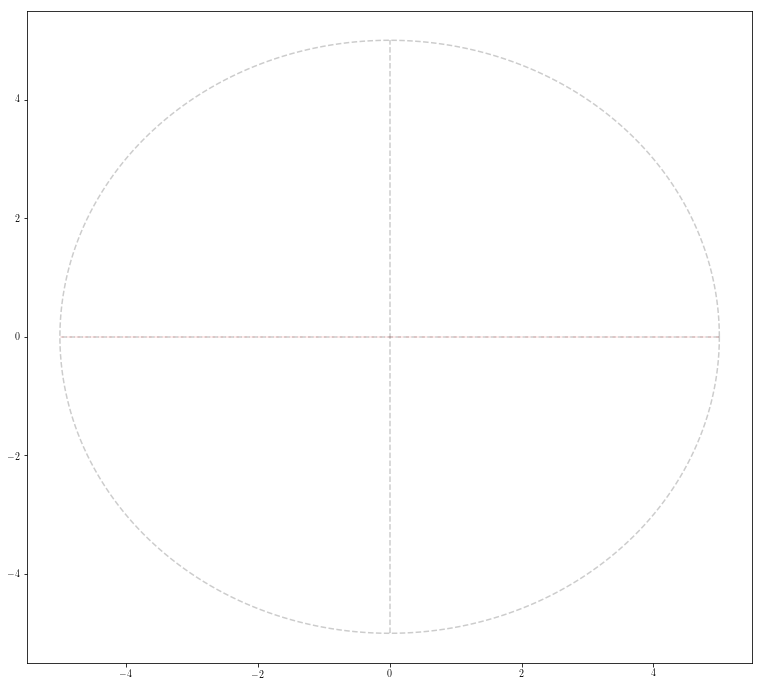

[-3. -1.  3. -1.  0. -2.]


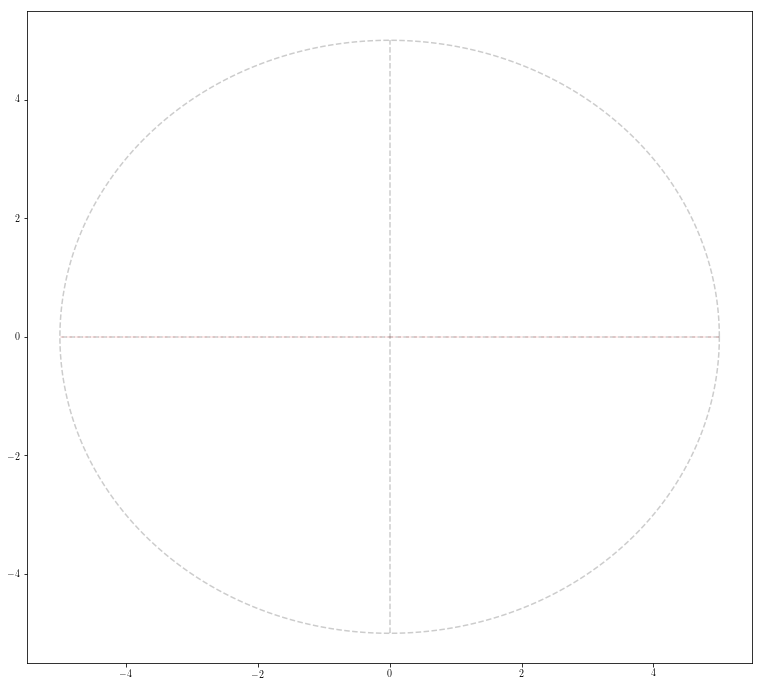

[ 3. -1. -3. -1.  0. -2.]


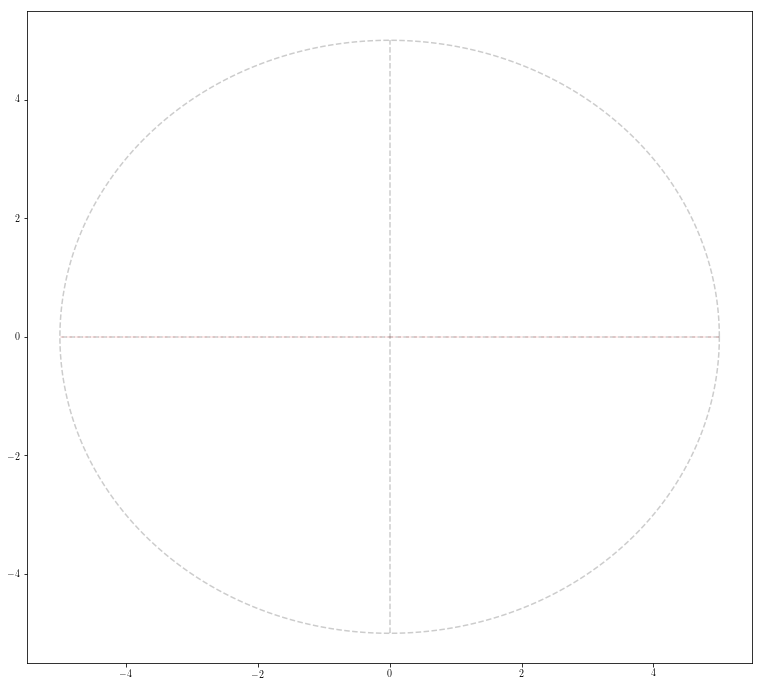

[-3. -2.  3.  1.  0. -1.]


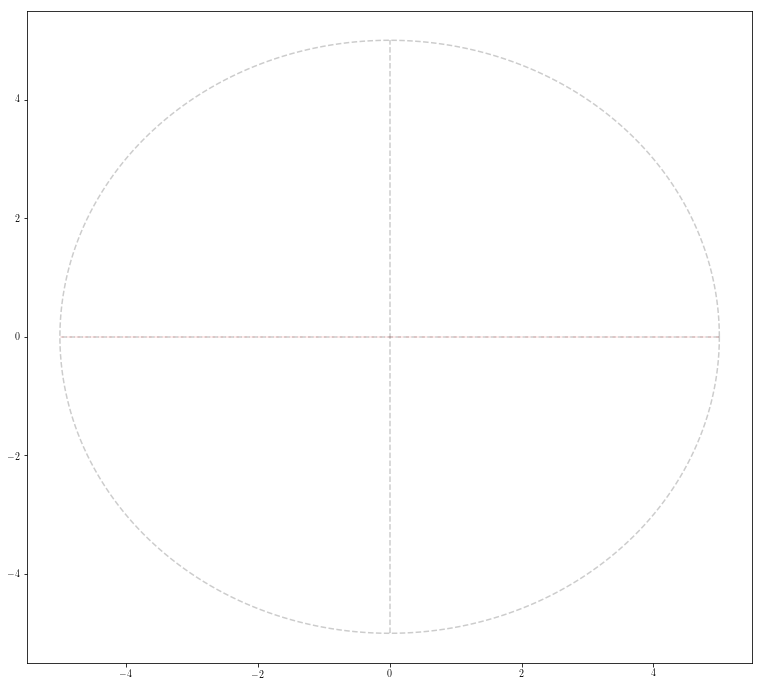

[-3.  1.  3. -2.  0. -1.]


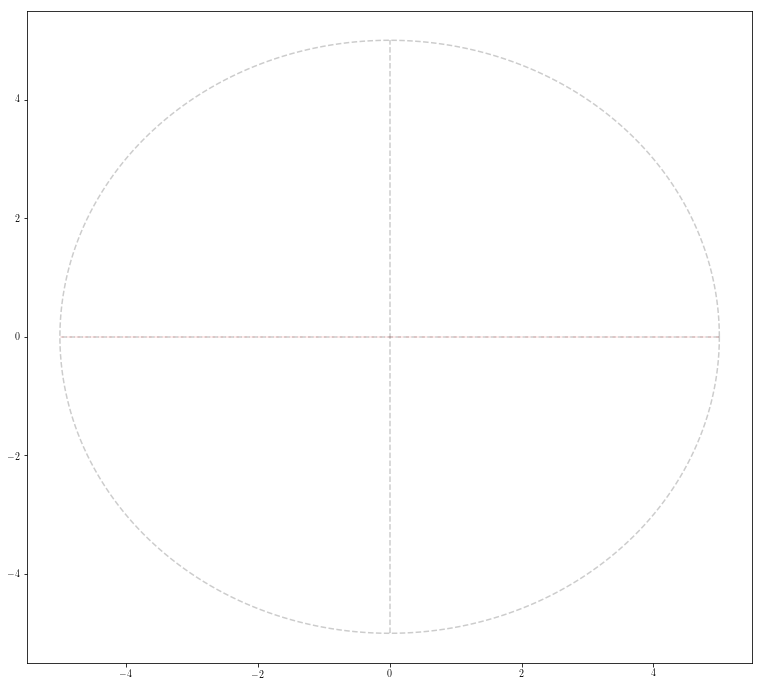

[ 3. -2. -3.  1.  0. -1.]


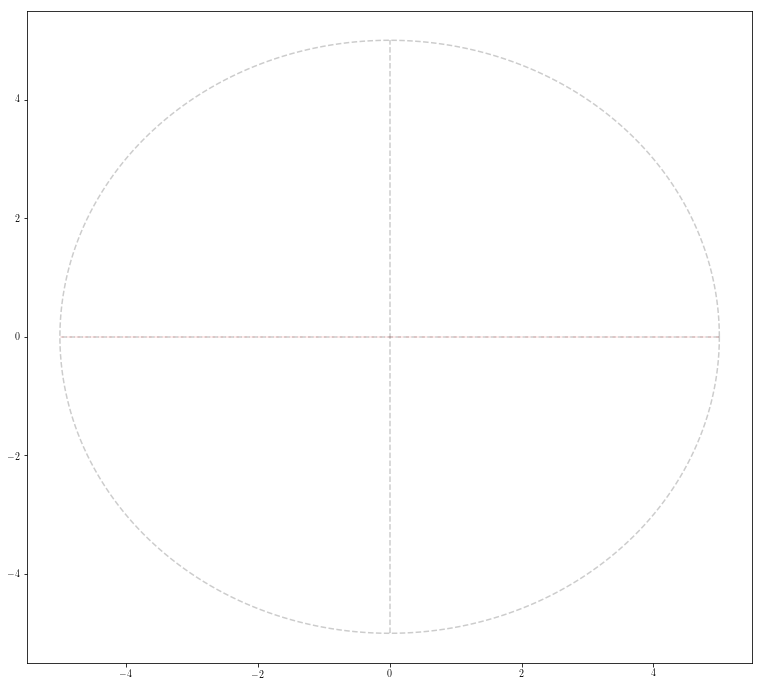

[ 3.  1. -3. -2.  0. -1.]


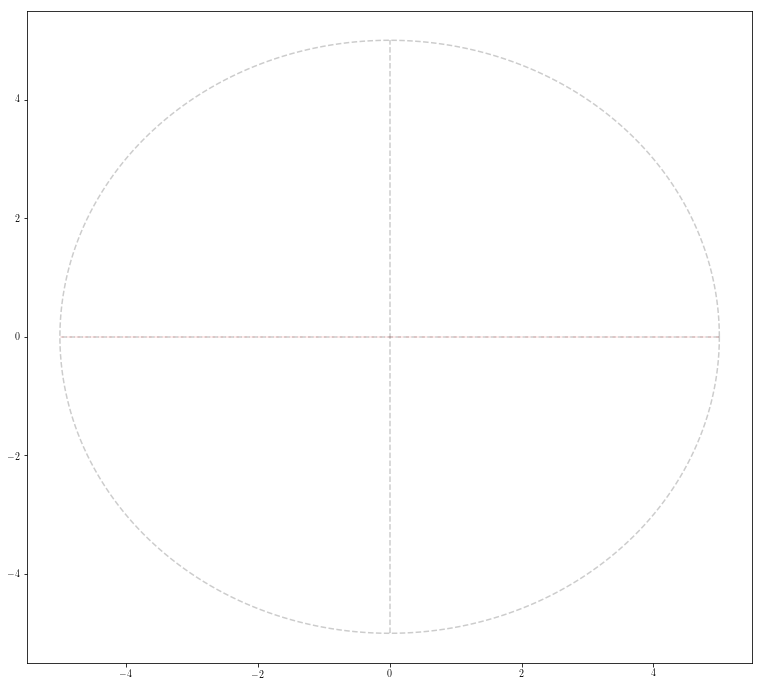

[-3. -1.  3.  2.  0.  1.]


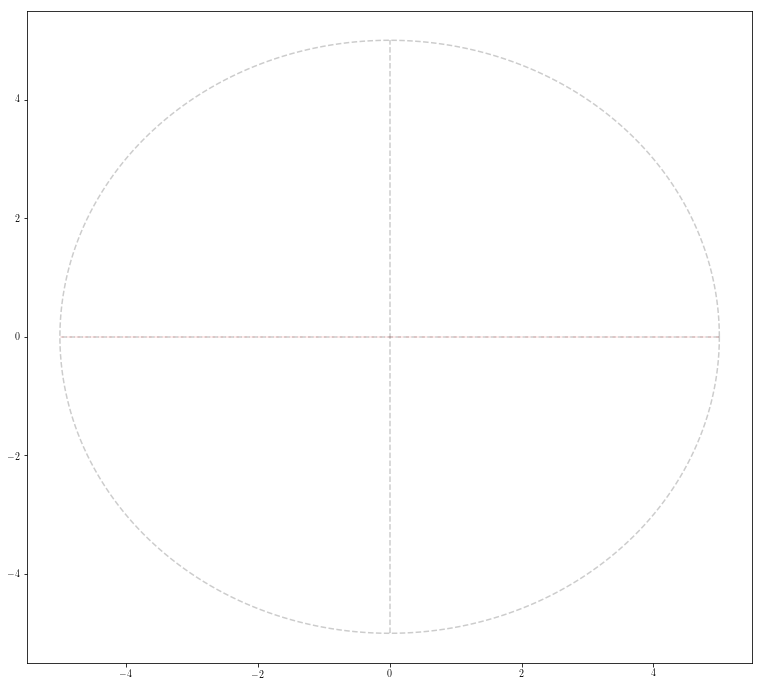

[-3.  2.  3. -1.  0.  1.]


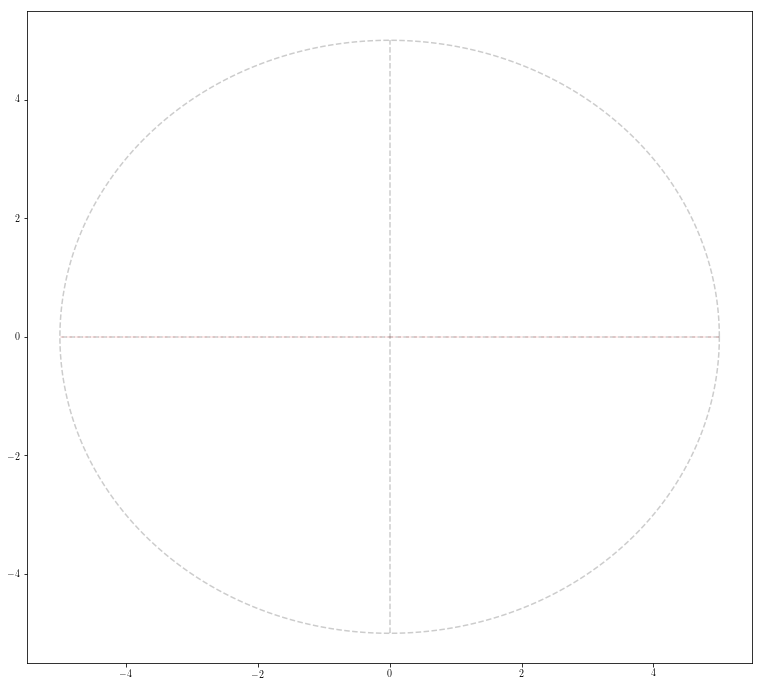

[ 3. -1. -3.  2.  0.  1.]


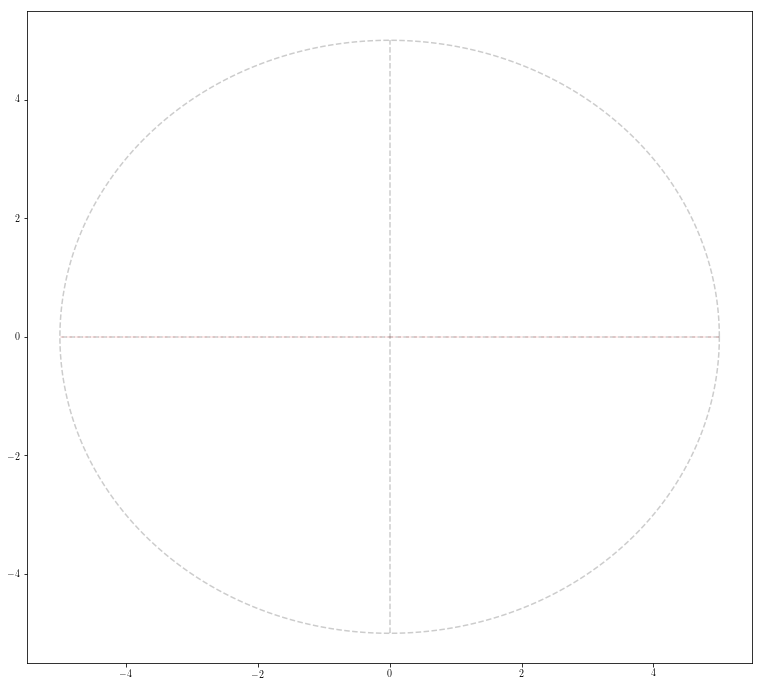

[ 3.  2. -3. -1.  0.  1.]


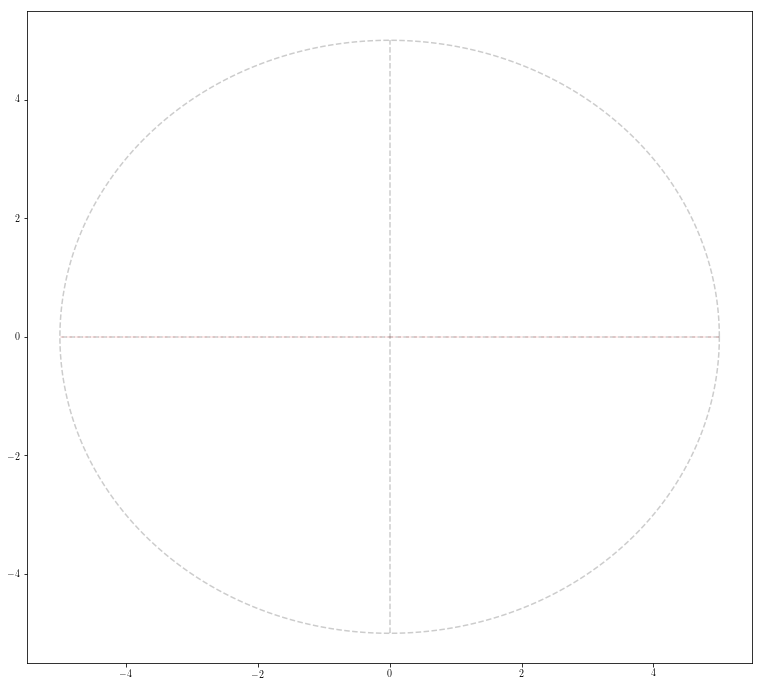

[-3.  1.  3.  1.  0.  2.]


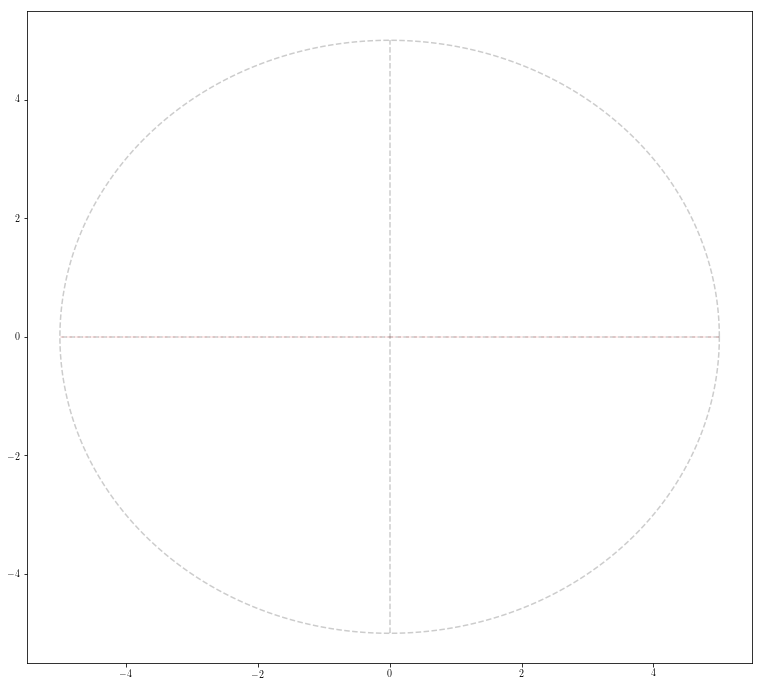

[ 3.  1. -3.  1.  0.  2.]


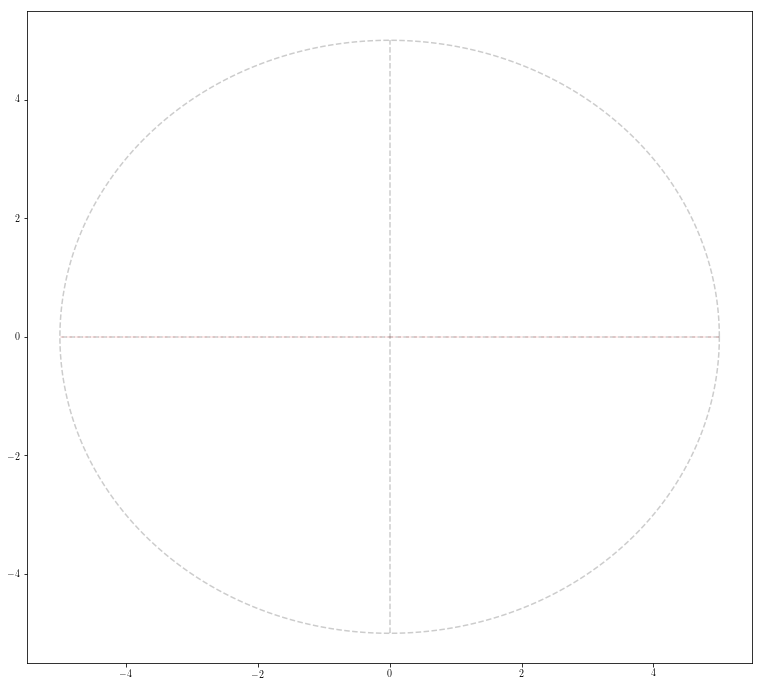

[-3.  1.  3.  2.  0.  3.]


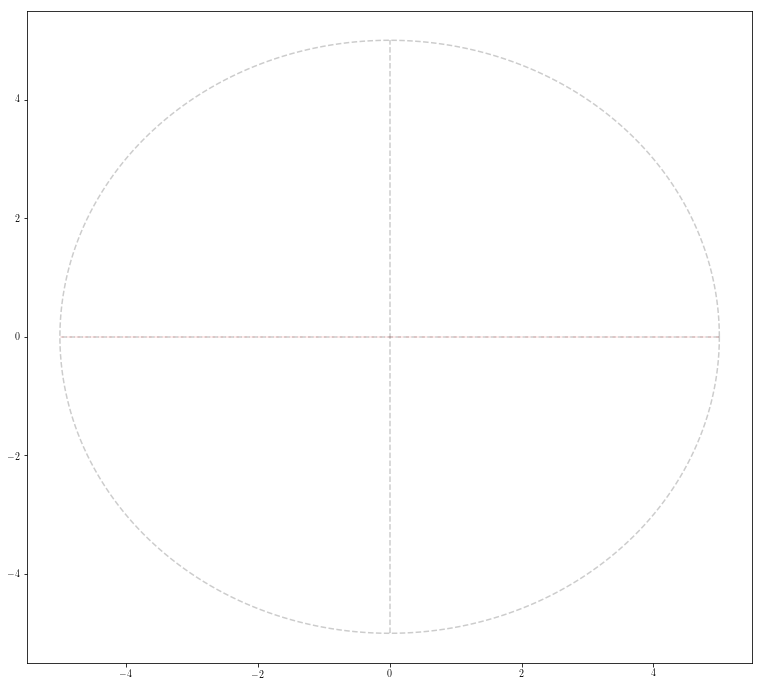

[-3.  2.  3.  1.  0.  3.]


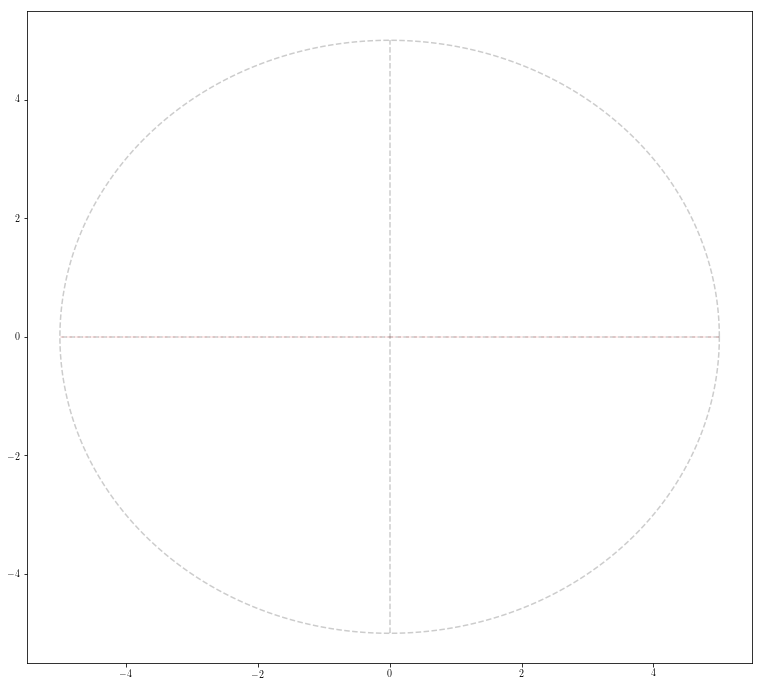

[ 3.  1. -3.  2.  0.  3.]


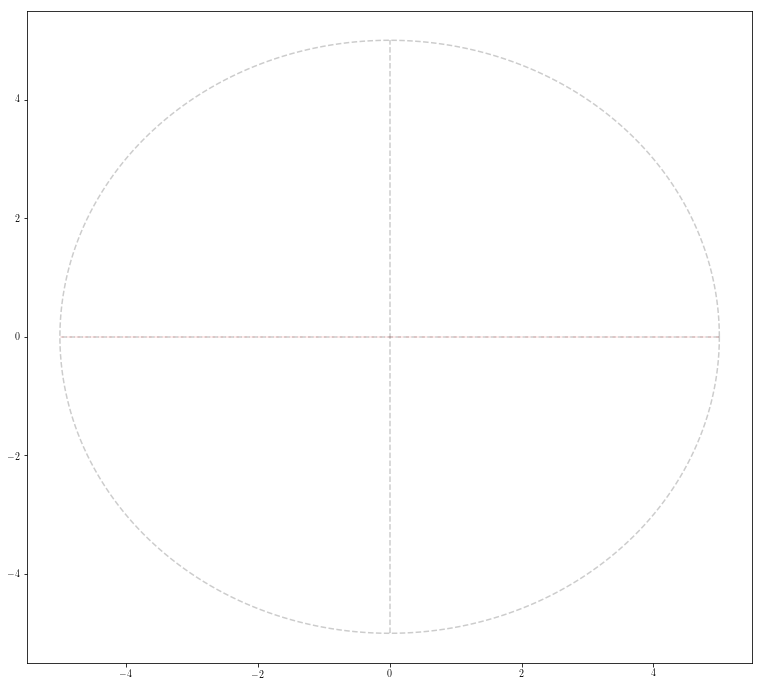

[ 3.  2. -3.  1.  0.  3.]


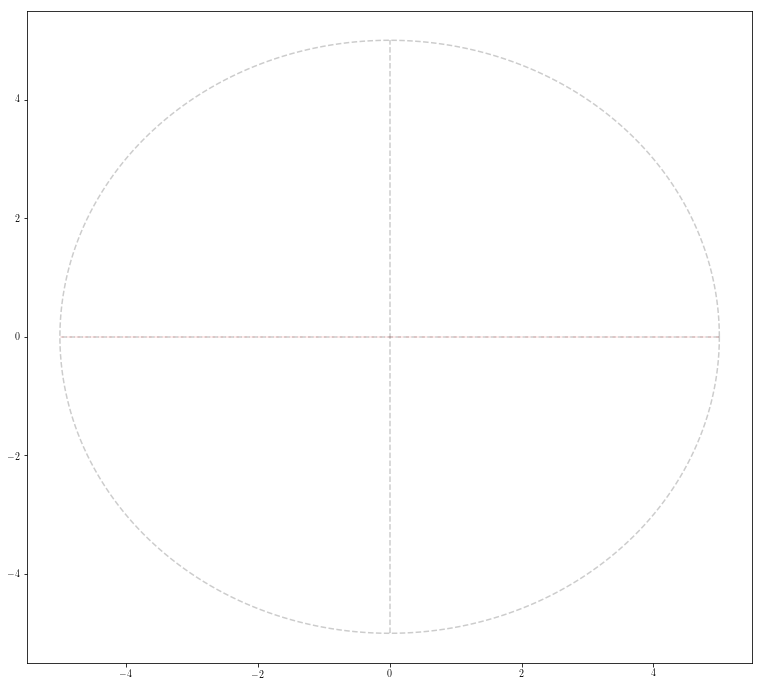

[-3. -2.  4.  0.  1. -2.]


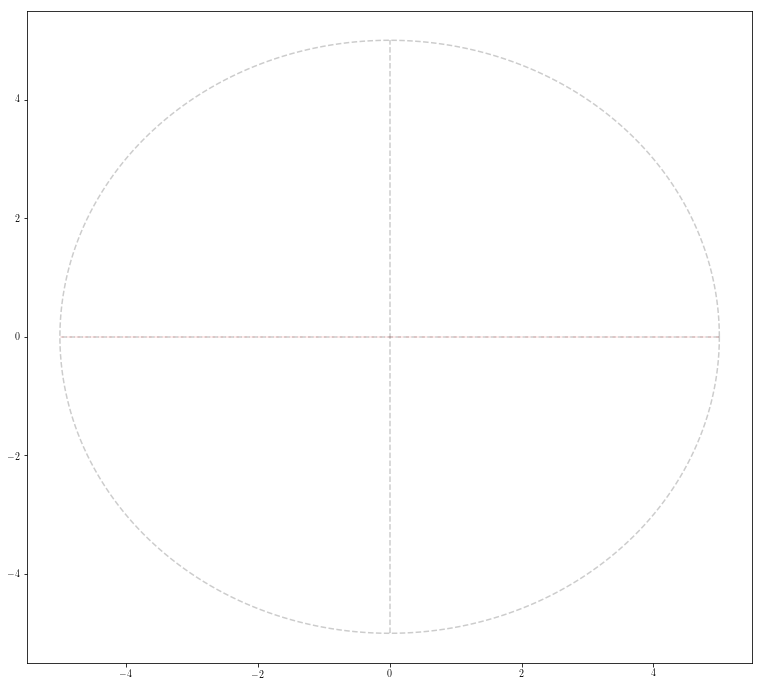

[-2. -3.  3.  1.  1. -2.]


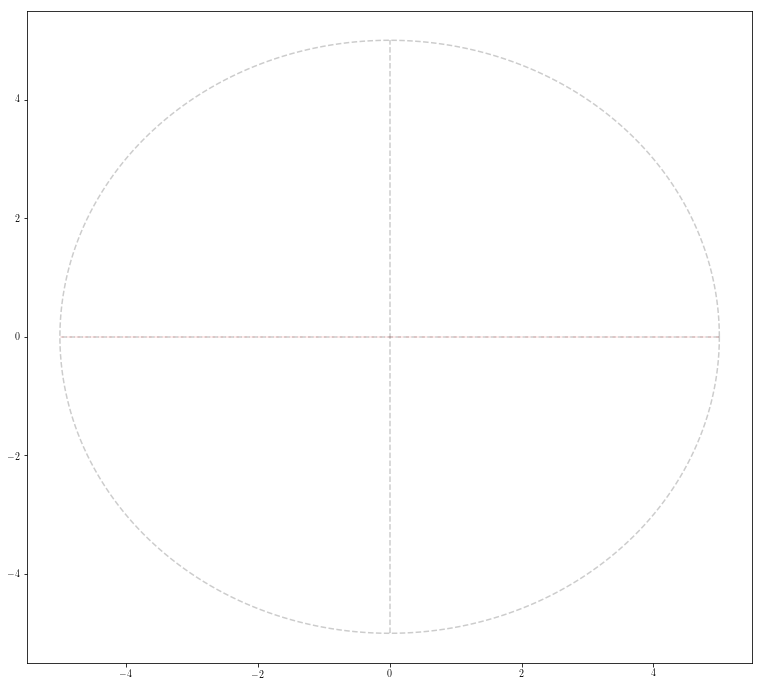

[ 3.  1. -2. -3.  1. -2.]


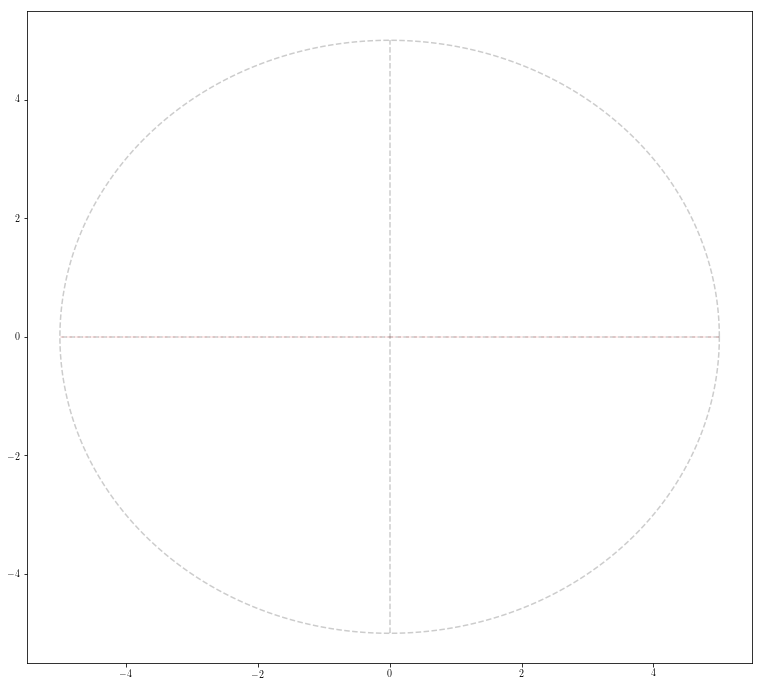

[ 4.  0. -3. -2.  1. -2.]


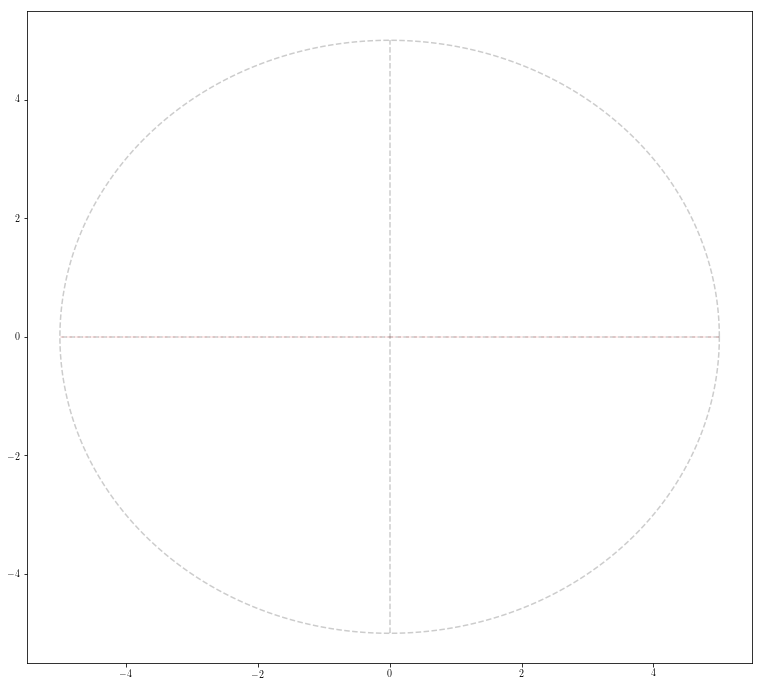

[-3. -1.  4.  0.  1. -1.]


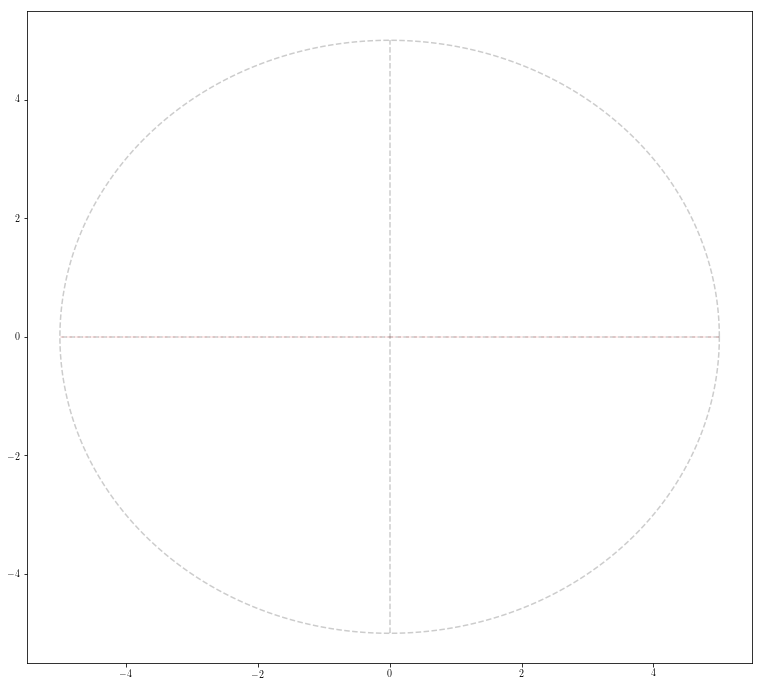

[-2. -3.  3.  2.  1. -1.]


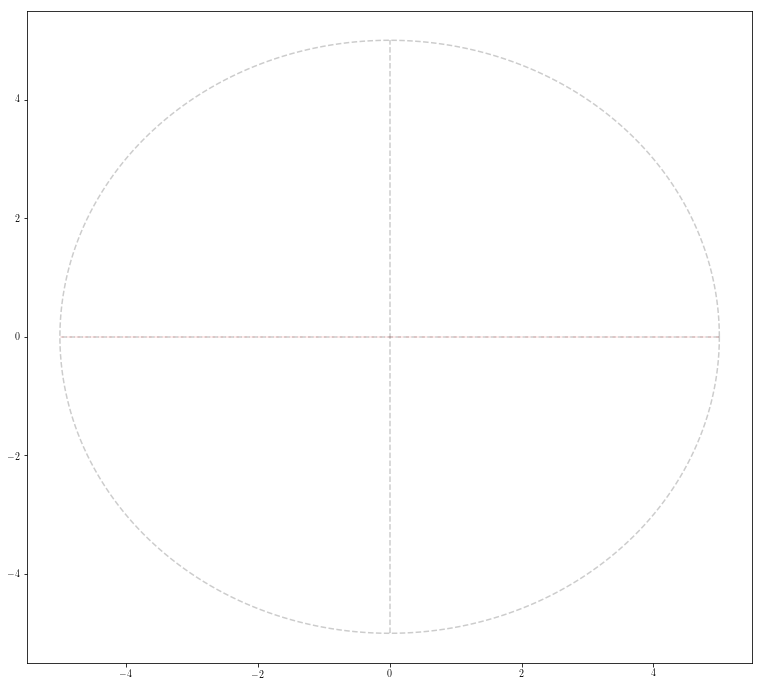

[ 3.  2. -2. -3.  1. -1.]


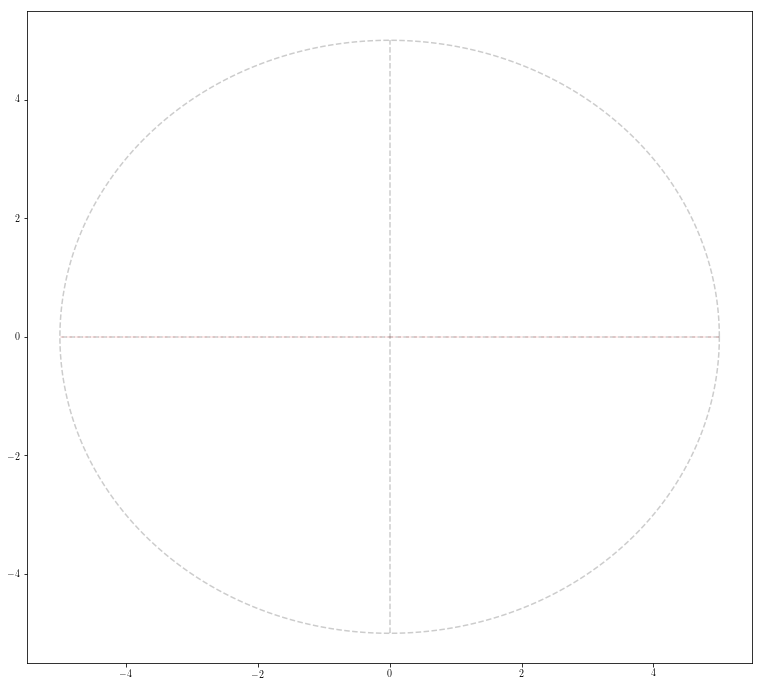

[ 4.  0. -3. -1.  1. -1.]


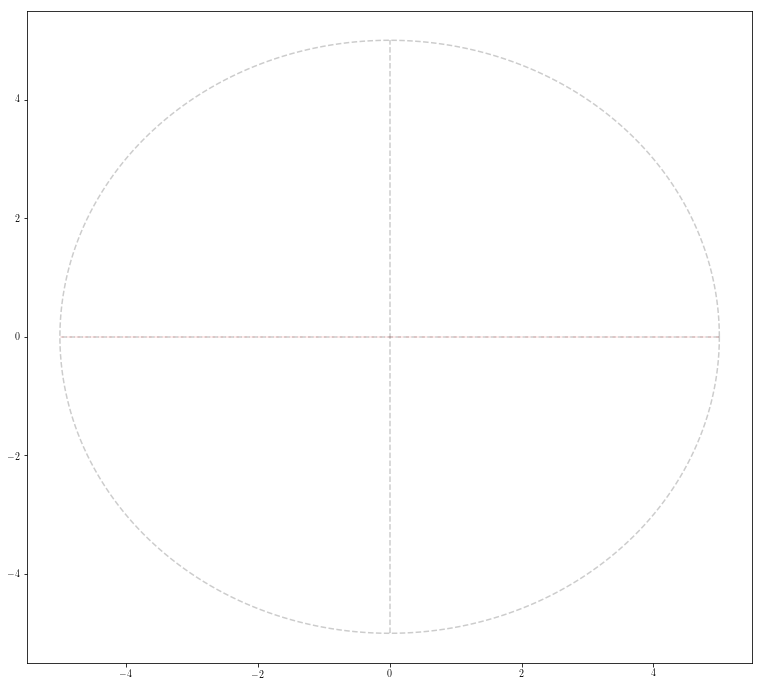

[-1. -3.  2.  3.  1.  0.]


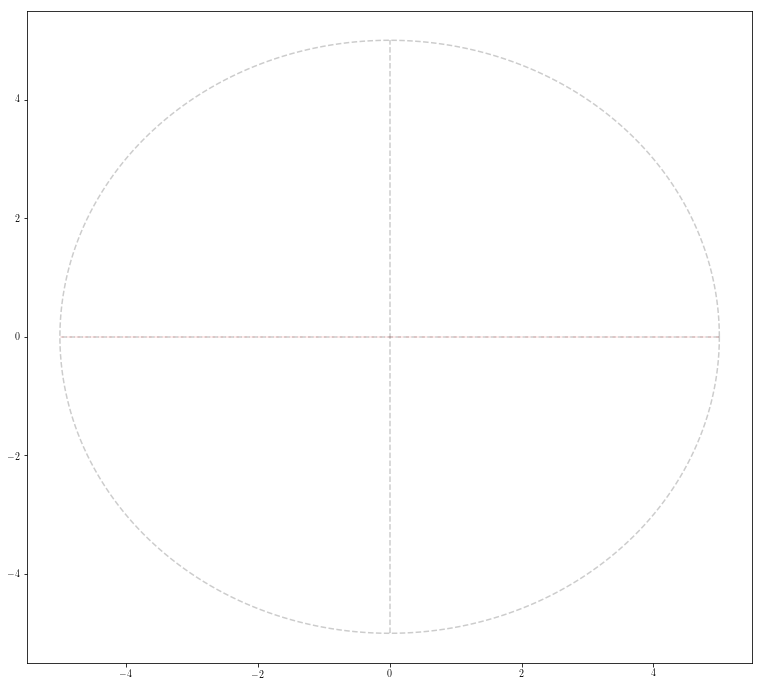

[-1.  3.  2. -3.  1.  0.]


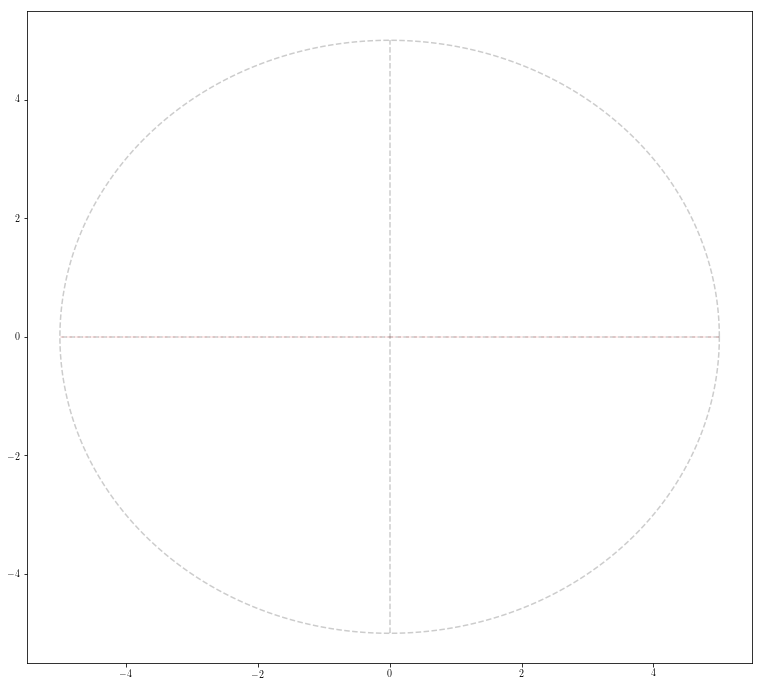

[ 2. -3. -1.  3.  1.  0.]


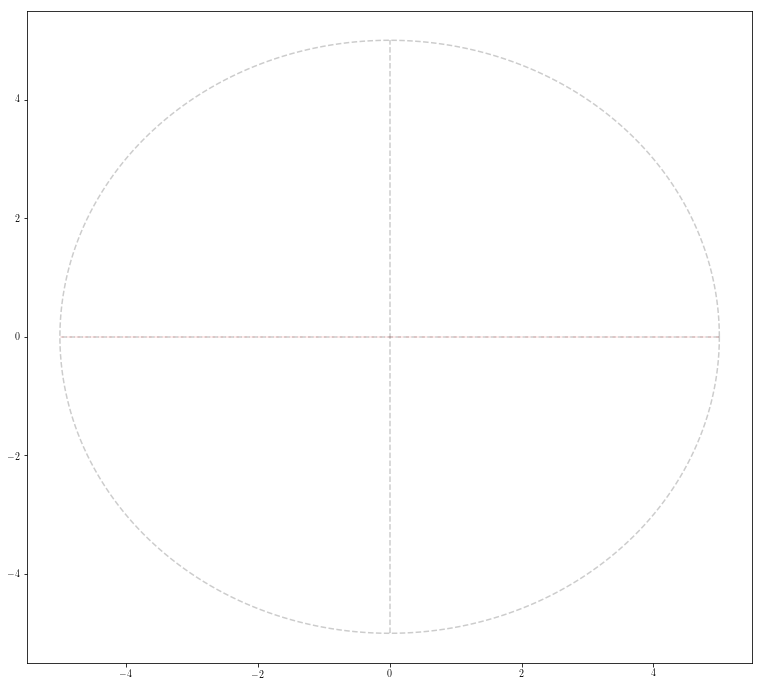

[ 2.  3. -1. -3.  1.  0.]


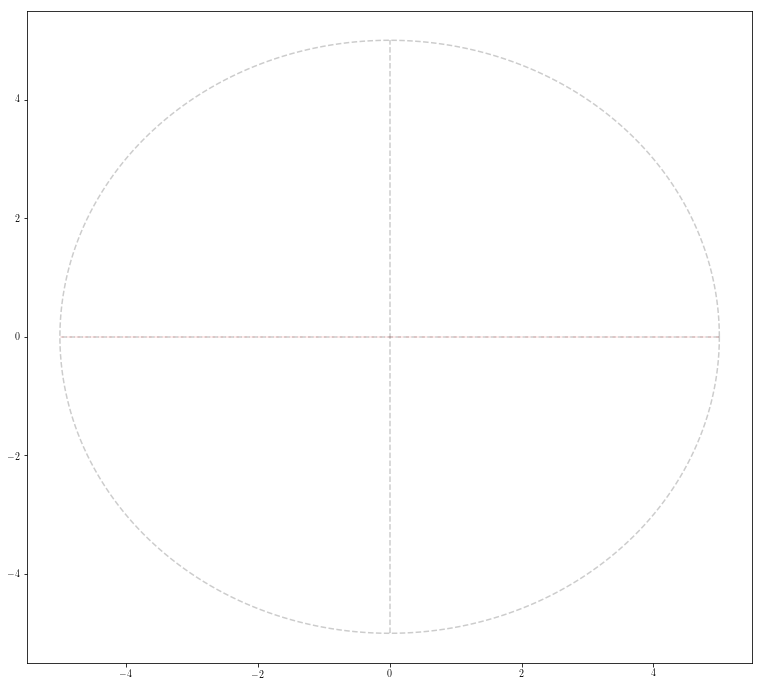

[-3.  1.  4.  0.  1.  1.]


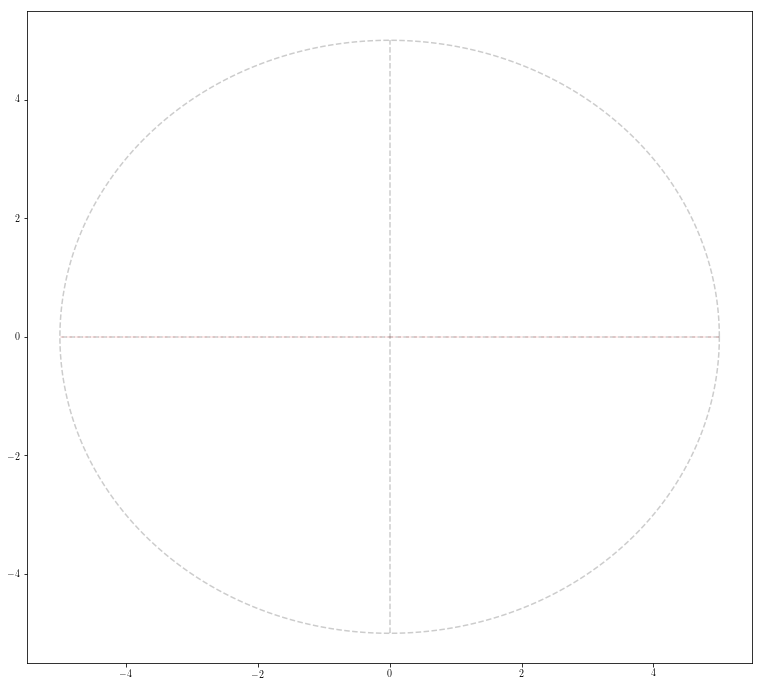

[-2.  3.  3. -2.  1.  1.]


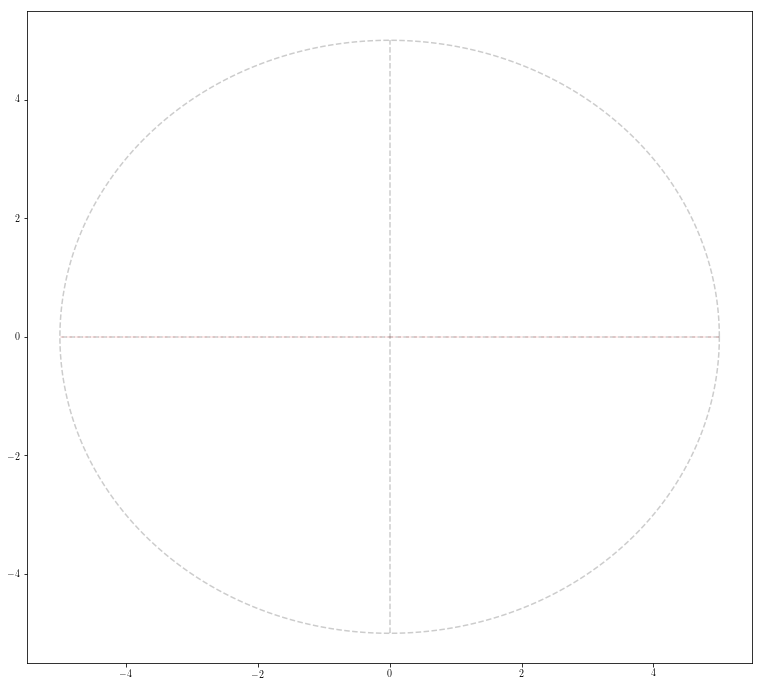

[ 0.  4.  1. -3.  1.  1.]


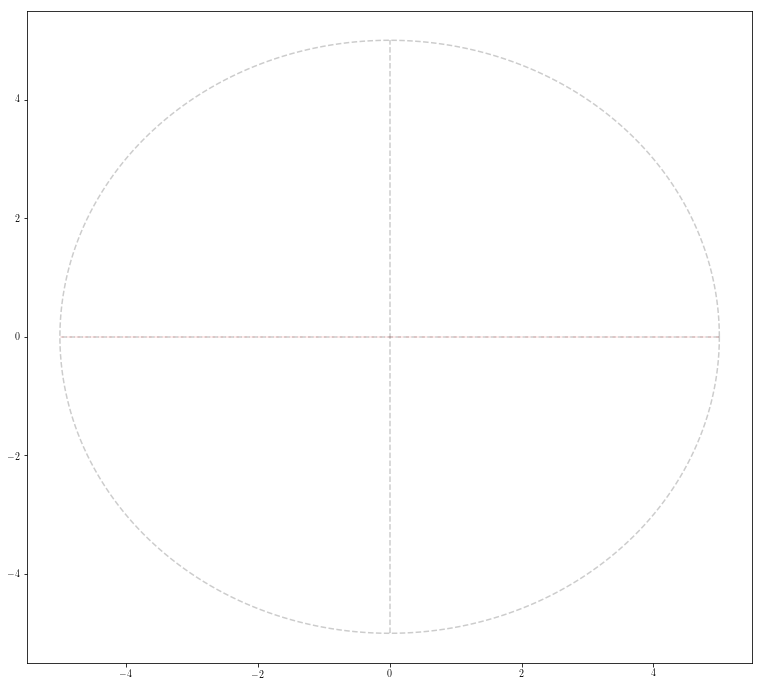

[ 1. -3.  0.  4.  1.  1.]


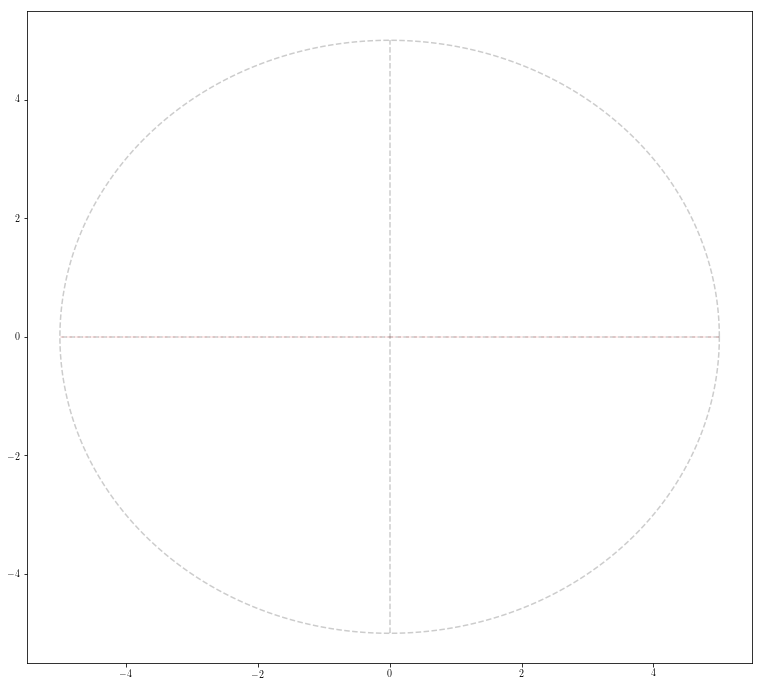

[ 3. -2. -2.  3.  1.  1.]


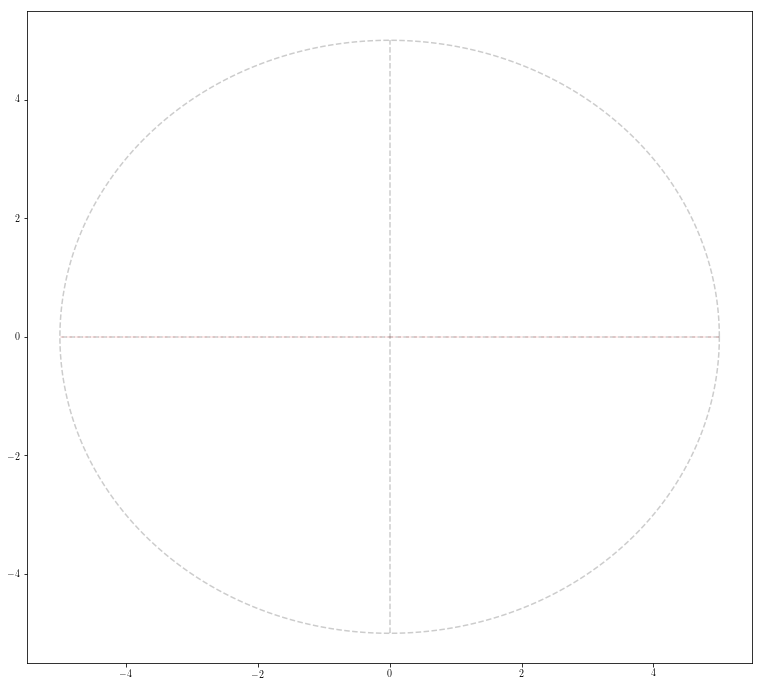

[ 4.  0. -3.  1.  1.  1.]


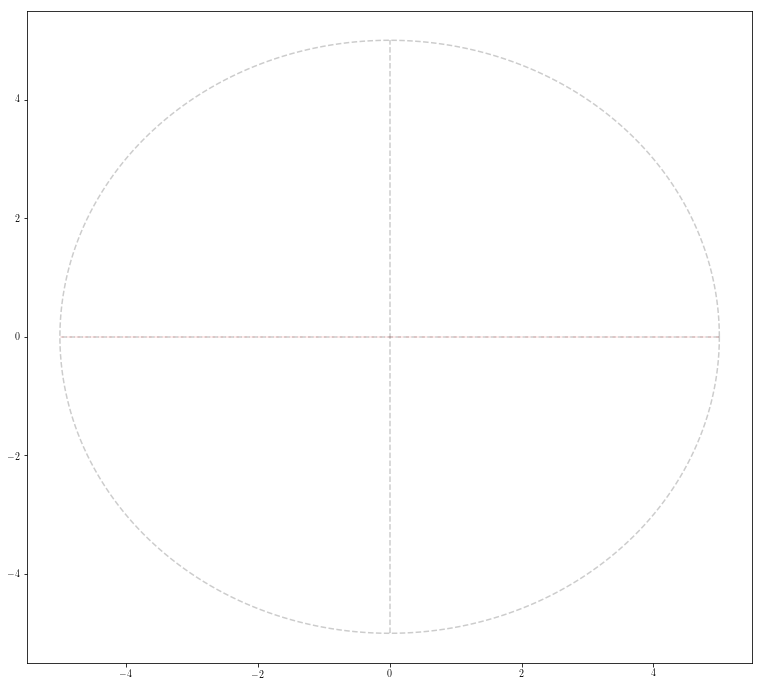

[-3.  2.  4.  0.  1.  2.]


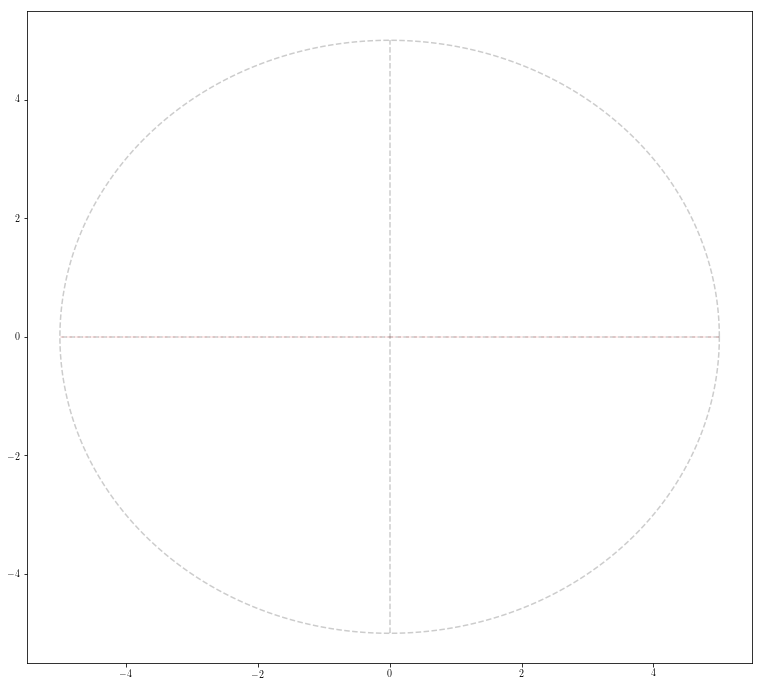

[-2.  3.  3. -1.  1.  2.]


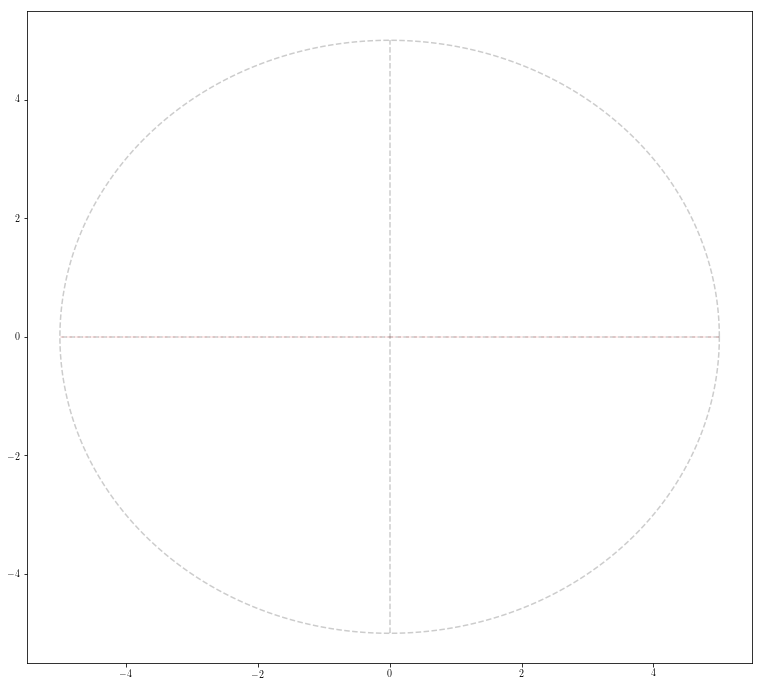

[ 3. -1. -2.  3.  1.  2.]


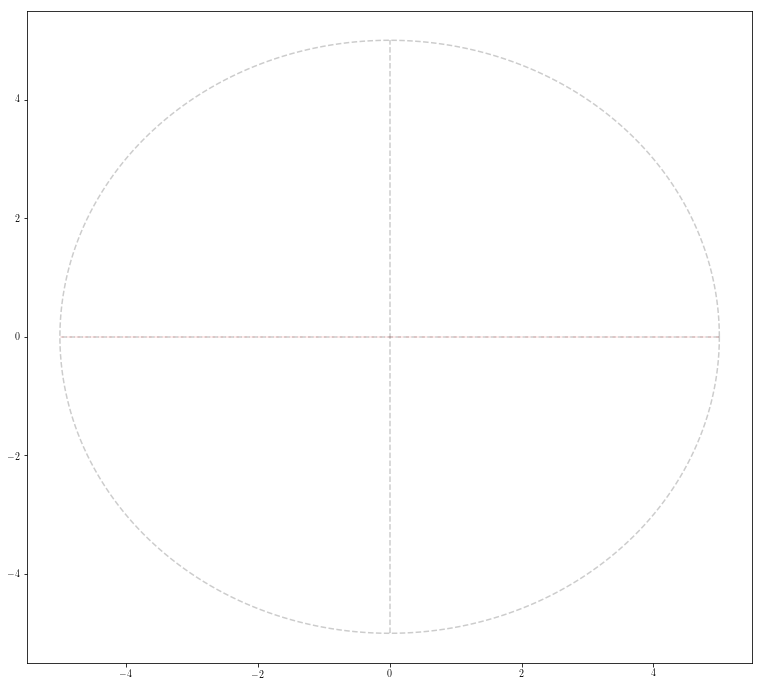

[ 4.  0. -3.  2.  1.  2.]


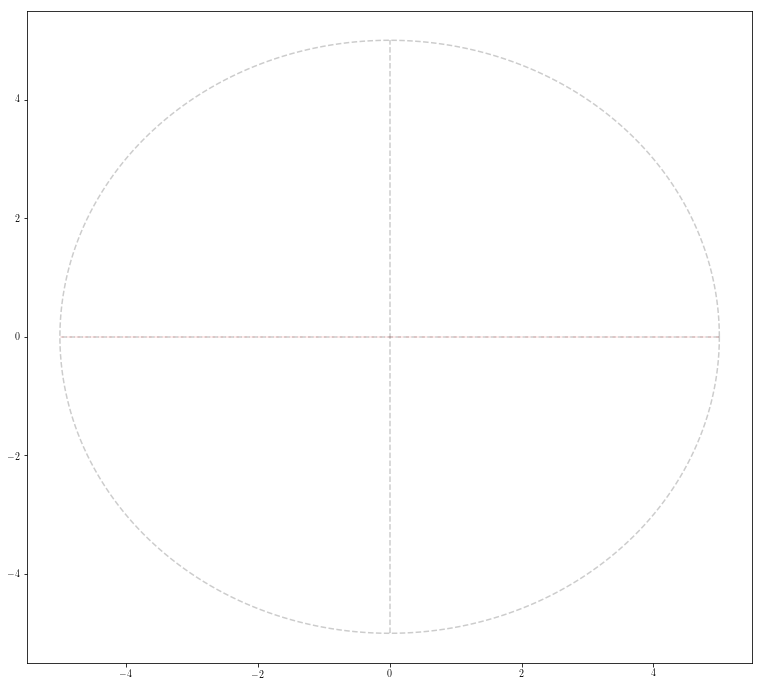

[-1. -3.  3.  1.  2. -2.]


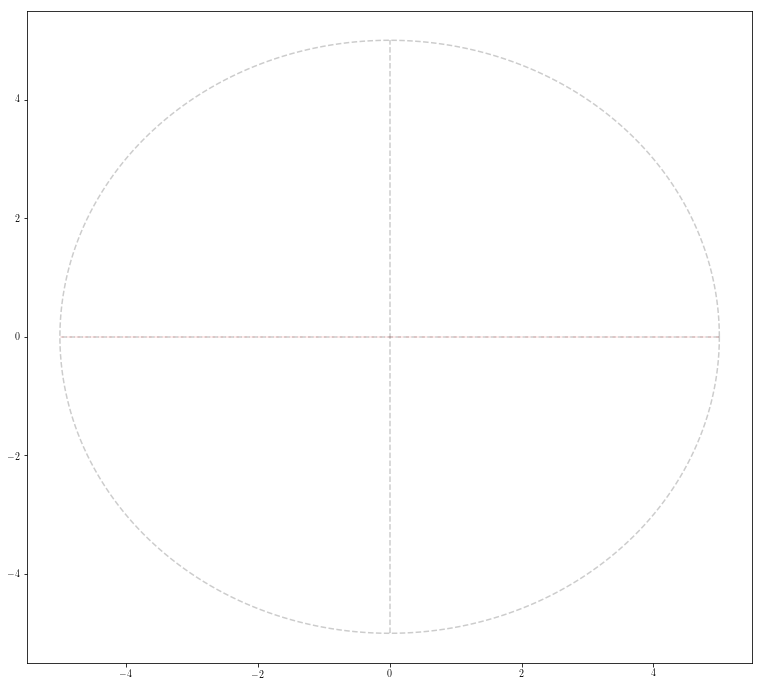

[ 3.  1. -1. -3.  2. -2.]


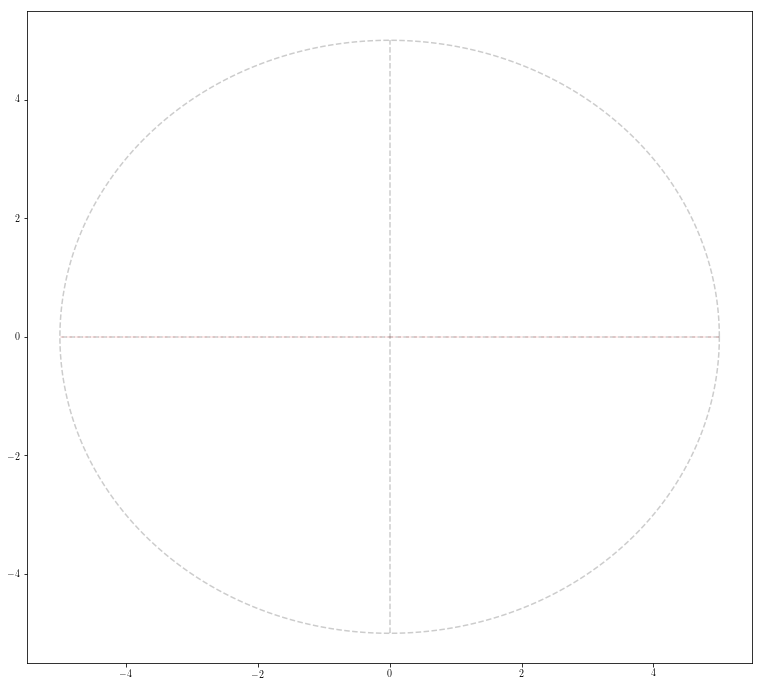

[-1. -3.  3.  2.  2. -1.]


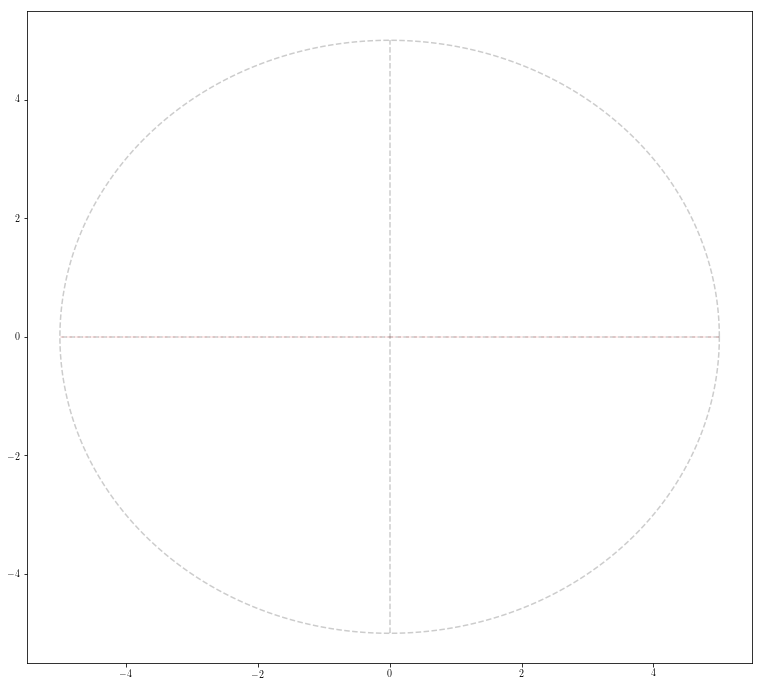

[ 3.  2. -1. -3.  2. -1.]


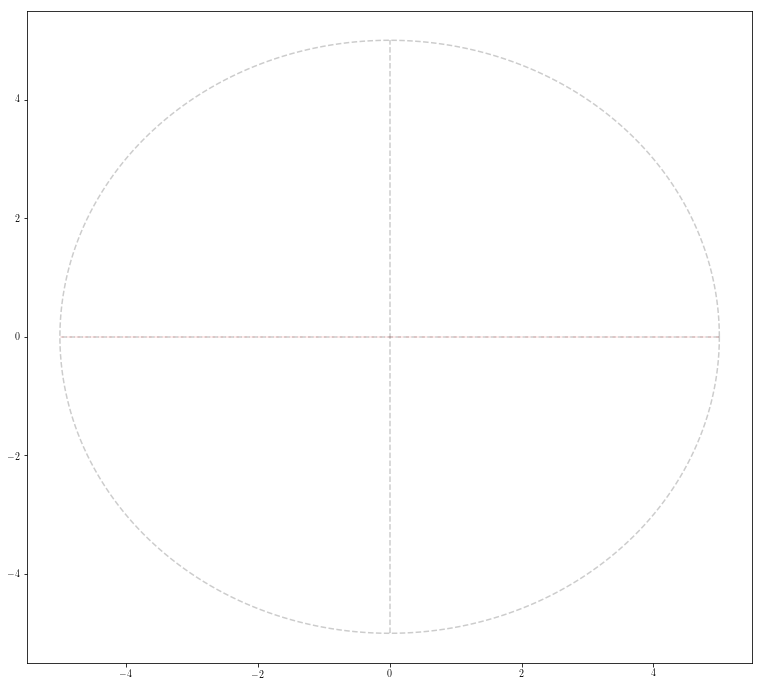

[-1.  3.  3. -2.  2.  1.]


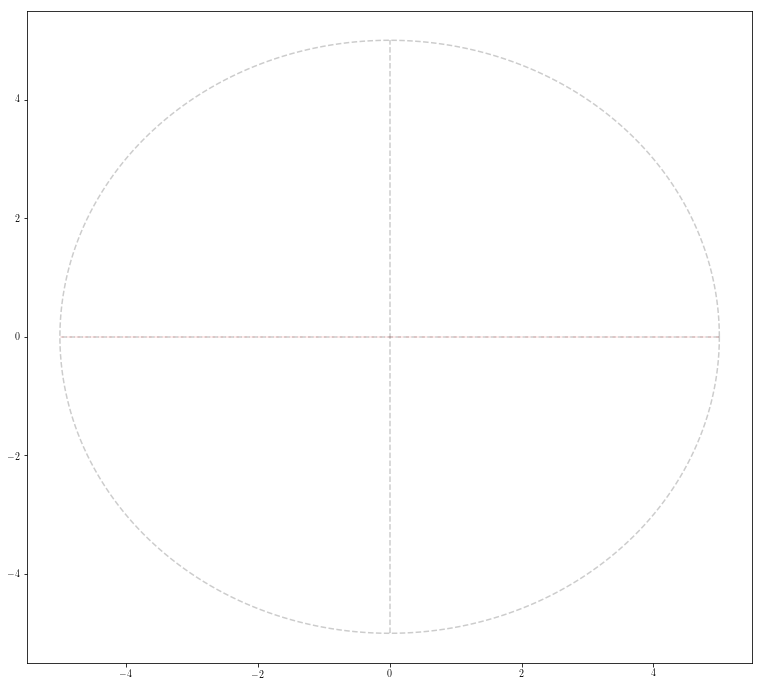

[ 0.  4.  2. -3.  2.  1.]


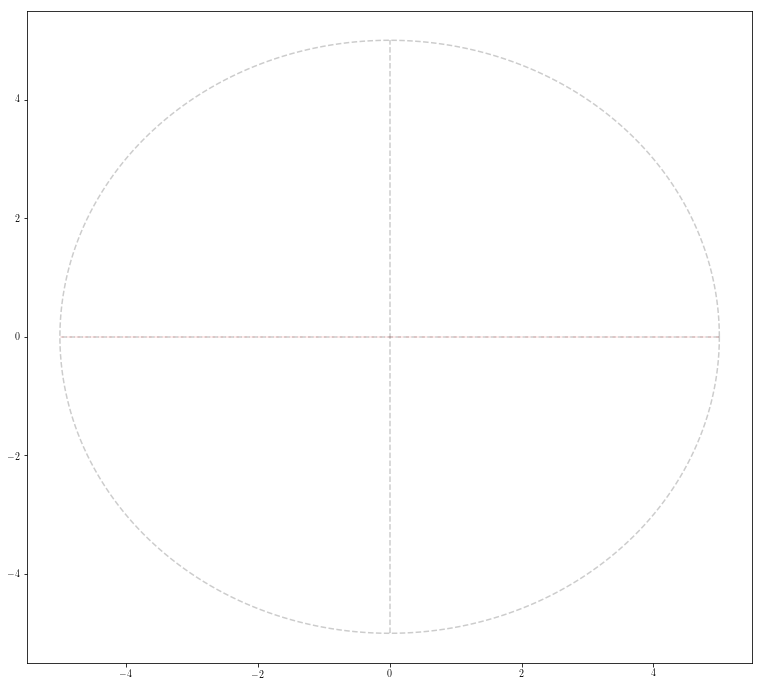

[ 2. -3.  0.  4.  2.  1.]


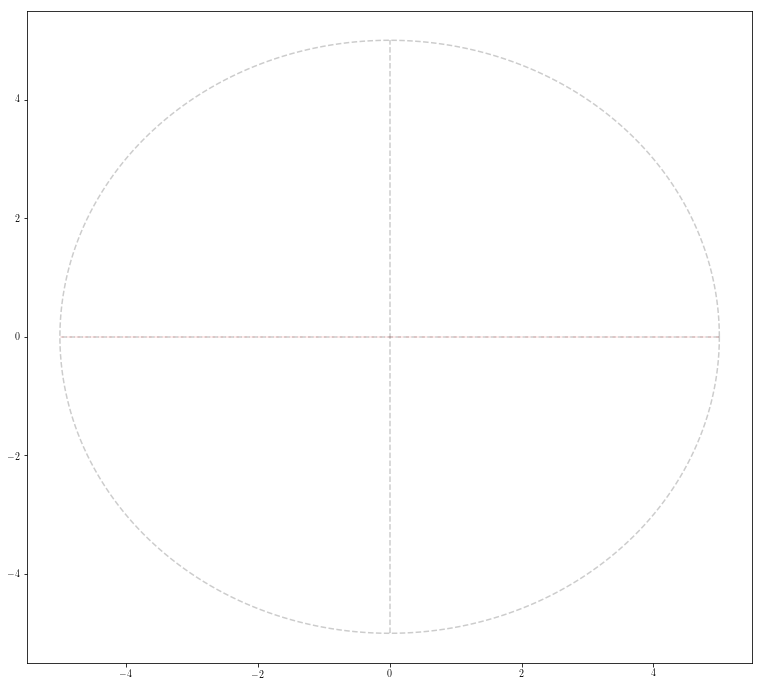

[ 3. -2. -1.  3.  2.  1.]


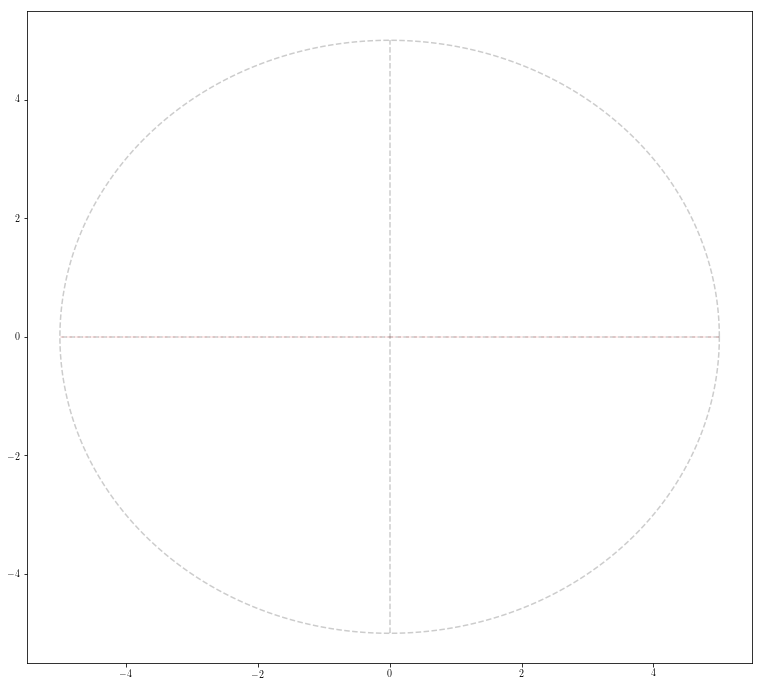

[-1.  3.  3. -1.  2.  2.]


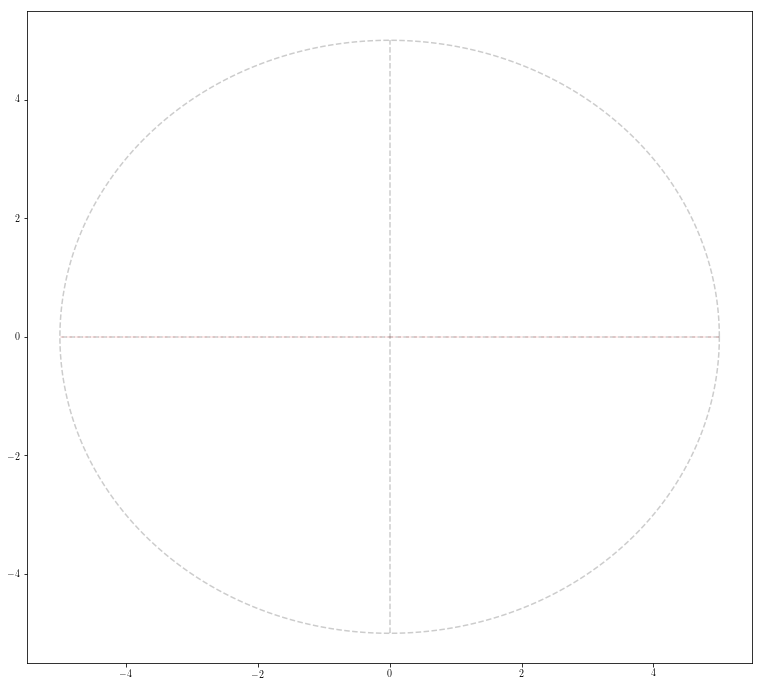

[ 3. -1. -1.  3.  2.  2.]


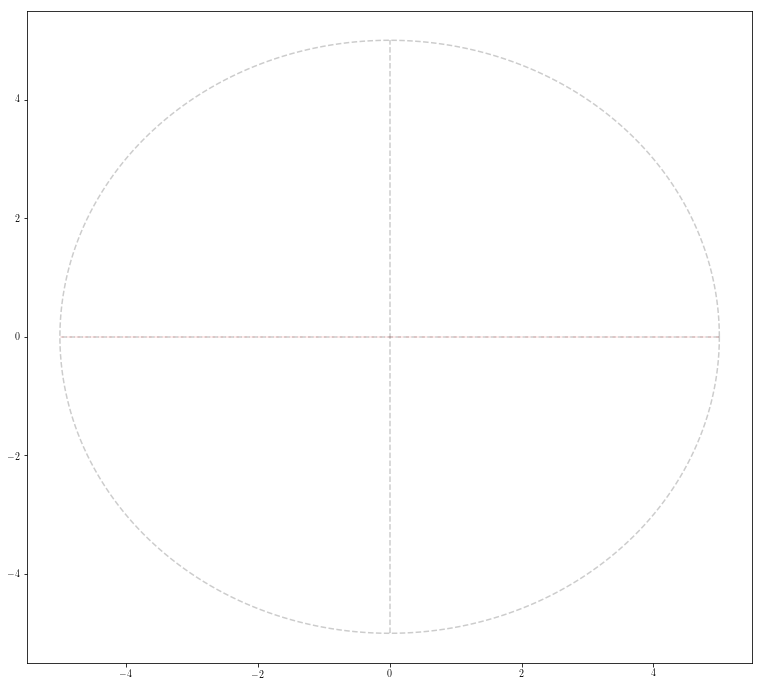

In [19]:
n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)


pos_missing = miss_first_pass


for k_vec in pos_missing:
    print(k_vec)

    plt.figure(figsize = (13, 12))
    plt.plot(x, y, 'k--', alpha = 0.2)
    plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
    plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
    for aa in range(post_data.num_sect):
        ## Plot sectors
        plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
        plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

    ## Print missing 
#     p1, = plt.plot([0, -k_vec[K1_Y]], [0, -k_vec[K1_X]], '.-', alpha = 1)
#     p2, = plt.plot([0, -k_vec[K2_Y]], [0, -k_vec[K2_X]], '.-', alpha = 1)
#     p3, = plt.plot([0, -k_vec[K3_Y]], [0, -k_vec[K3_X]], '.-', alpha = 1)
#     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
#     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
#     p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
#     p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
#     p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
#     plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
#     plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)

#     plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
#     plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
#     plt.plot([0, R*np.cos(theta[dsec + l] - dtheta/2)], [0, R*np.sin(theta[dsec + l] - dtheta/2)], '--', alpha = 0.5, color = "b")
#     plt.plot([0, R*np.cos(theta[dsec + l] + dtheta/2)], [0, R*np.sin(theta[dsec + l] + dtheta/2)], '--', alpha = 0.5, color = "b")
#     plt.plot([0, R*np.cos(theta[dsec + 5] - dtheta/2)], [0, R*np.sin(theta[dsec + 5] - dtheta/2)], '--', alpha = 0.5, color = "b")
#     plt.plot([0, R*np.cos(theta[dsec + 5] + dtheta/2)], [0, R*np.sin(theta[dsec + 5] + dtheta/2)], '--', alpha = 0.5, color = "b")
    plt.show()

In [ ]:
print(pos_missing_indices[1])
print(wv[dsec][1][-1, pos_missing_indices[1][0]])
print(wv[dsec][1][:, pos_missing_indices[1][0]])
print(wv[dsec][1][K3_ANGLE, pos_missing_indices[1][0]])
print(theta[sec])
print(theta[dsec])
# print(np.arctan2(1, 0))
# print(np.arctan2(-1, -0))
# print(np.arctan2(-2, -4))
# print(np.arctan2(-1, -4))
print(kmax**2)

In [101]:
n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

for l in range(post_data.num_k1_sects):
    print("\n\nl = {}".format(l))
    for k_vec in pos_missing[l]:

        plt.figure(figsize = (13, 12))
        plt.plot(x, y, 'k--', alpha = 0.2)
        plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
        plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
        for aa in range(post_data.num_sect):
            ## Plot sectors
            plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
            plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

        ## Print missing 
#         p1, = plt.plot([0, -k_vec[K1_Y]], [0, -k_vec[K1_X]], '.-', alpha = 1)
#         p2, = plt.plot([0, -k_vec[K2_Y]], [0, -k_vec[K2_X]], '.-', alpha = 1)
#         p3, = plt.plot([0, -k_vec[K3_Y]], [0, -k_vec[K3_X]], '.-', alpha = 1)
    #     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
    #     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
    #     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
        p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
        p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
        p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
        plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
        plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
        plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)
        
        plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
        plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
        plt.plot([0, R*np.cos(theta[dsec + l] - dtheta/2)], [0, R*np.sin(theta[dsec + l] - dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + l] + dtheta/2)], [0, R*np.sin(theta[dsec + l] + dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + 5] - dtheta/2)], [0, R*np.sin(theta[dsec + 5] - dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + 5] + dtheta/2)], [0, R*np.sin(theta[dsec + 5] + dtheta/2)], '--', alpha = 0.5, color = "b")
        print(k_vec)
        plt.show()



l = 0


In [561]:
def check_list(in_list):
    for i in range(num_wave_vec_sec1[0, 0]):
        if in_list in sec_data[:6, i]:
            return True
        else:
            return False

In [562]:
sec_data = wave_vec_data_a0_l0_sec1[:6, :]
true_data = post_data.wave_vec_data_test

n = 0
for i in range(post_data.num_triads_test[0]):
    if check_list(true_data[:, i]) == True:
        continue
    else:
        n+=1
        print(i, true_data[:, i])
#     print(np.isin(sec_data[:6, i], true_data, a))
print(n)

1 [-3. -2. -2.  2. -5.  0.]
2 [-3. -1. -2.  1. -5.  0.]
3 [-3.  0. -2.  0. -5.  0.]
5 [-3.  2. -2. -2. -5.  0.]
6 [-2. -2. -3.  2. -5.  0.]
7 [-2. -1. -3.  1. -5.  0.]
8 [-2.  0. -3.  0. -5.  0.]
10 [-2.  2. -3. -2. -5.  0.]
11 [-1.  0. -4.  0. -5.  0.]
14 [-3. -1. -1. -2. -4. -3.]
15 [-3.  0. -1. -3. -4. -3.]
18 [-2. -1. -2. -2. -4. -3.]
19 [-2.  0. -2. -3. -4. -3.]
22 [-1. -1. -3. -2. -4. -3.]
25 [-3. -2. -1.  0. -4. -2.]
27 [-3.  0. -1. -2. -4. -2.]
28 [-3.  1. -1. -3. -4. -2.]
30 [-2. -2. -2.  0. -4. -2.]
32 [-2.  0. -2. -2. -4. -2.]
33 [-2.  1. -2. -3. -4. -2.]
35 [-1. -2. -3.  0. -4. -2.]
37 [-1.  0. -3. -2. -4. -2.]
38 [ 0. -2. -4.  0. -4. -2.]
40 [-3. -2. -1.  1. -4. -1.]
41 [-3. -1. -1.  0. -4. -1.]
43 [-3.  1. -1. -2. -4. -1.]
44 [-3.  2. -1. -3. -4. -1.]
46 [-2. -2. -2.  1. -4. -1.]
47 [-2. -1. -2.  0. -4. -1.]
49 [-2.  1. -2. -2. -4. -1.]
50 [-2.  2. -2. -3. -4. -1.]
52 [-1. -2. -3.  1. -4. -1.]
53 [-1. -1. -3.  0. -4. -1.]
55 [-1.  1. -3. -2. -4. -1.]
56 [ 0. -1. -4.  0. -

In [563]:
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[8]_KFRAC[0.75].h5') as f:
    num_wave_vec_sec2 = f["NumWavevectors"]
    wave_vec_data_a0_l0_sec2 = f["WavevectorData_a[0]_l[0]"][:, :]
    wave_vec_data_a0_l1_sec2 = f["WavevectorData_a[0]_l[1]"][:, :]    
    wave_vec_data_a1_l0_sec2 = f["WavevectorData_a[1]_l[0]"][:, :]    
    wave_vec_data_a1_l1_sec2 = f["WavevectorData_a[1]_l[1]"][:, :]  
    
print(wave_vec_data_a0_l0_sec2.shape)
print(wave_vec_data_a0_l1_sec2.shape)
print(wave_vec_data_a1_l0_sec2.shape)
print(wave_vec_data_a1_l1_sec2.shape)

print()
print("First Sec: {}\tSecond Sec: {}\tMatch: {}\tSum: {}\tSum Match: {}".format(wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1], 
                                                                                wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1], 
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] == wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1],
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] + wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1],
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] + wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1] == num_wave_vec_sec1[0, 0]))
print()
# print(wave_vec_data_a0_l0_sec2[-1, :])


print()
print()
t = np.arange(-np.pi, np.pi + 0.5, 2.0 * np.pi/2)
for i in range(2):
    for j in range(2):
        print(t[i], t[np.mod(i + j, 2)])


OSError: Unable to open file (unable to open file: name = '/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[8]_KFRAC[0.75].h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# for i in range(wave_vec_data_a0_l0_sec1.shape[1]):
#     print(i, np.all(np.isin(wave_vec_data_a0_l0_sec2[:6, i], wave_vec_data_a0_l1_sec2[:6, i])))
joined_list = np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = 1)
combined = np.append(wave_vec_data_a0_l0_sec1[:6, :], joined_list, axis = 1)
np.unique(combined, axis = 0).shape
# print(wave_vec_data_a0_l0_sec1[:6, -i], np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1)[:6, -i], np.all(wave_vec_data_a0_l0_sec1[:6, -i] == np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1)[:6, -i]))
# np.all(np.isin(wave_vec_data_a0_l0_sec1, wave_vec_data_a1_l0_sec2))
# print(np.all(np.isin(wave_vec_data_a0_l0_sec1, np.append(wave_vec_data_a0_l0_sec2, wave_vec_data_a0_l1_sec2))))
# print(np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1))

## Enstorphy Flux Compare: Nonlinear Term vs Simple Sectors

In [9]:
const_fac_sector = 4.0 * np.pi**2 
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

theta = 0 #int(post_data.num_sect // 2)
print(theta)

0


In [182]:
print("Test Type 0")
print((np.sum(post_data.enst_flux_per_sec[:, 0, :],axis = -1)  * const_fac_sector * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))

for i in range(1, 5):
    print()
    triad_type = i
    print("Specific Triad Type = {}".format(triad_type))
    print((post_data.enst_flux_per_sec[:, triad_type, theta]) / (post_data.enst_flux_test[:, triad_type]))

print()
print(post_data.enst_flux_per_sec[:, :, :].shape)

Test Type 0
[   23.48899477    23.58604228    23.68189289    23.77704375
    23.87192192    23.96690004    24.0623083     24.15844377
    24.25557763    24.35396107    24.45382992    24.55540857
    24.65891318    24.76455447    24.87254001    24.98307642
    25.09637117    25.21263437    25.33208036    25.45492927
    25.58140858    25.71175457    25.84621393    25.98504527
    26.12852082    26.27692814    26.43057198    26.58977629
    26.7548864     26.92627133    27.10432647    27.28947639
    27.48217806    27.68292438    27.89224817    28.1107266
    28.33898624    28.57770871    28.82763713    29.08958343
    29.36443672    29.65317286    29.95686548    30.27669866
    30.61398168    30.97016607    31.34686564    31.74587982
    32.16922124    32.61914831    33.09820398    33.609262
    34.15558256    34.74087947    35.36940195    36.04603463
    36.77642091    37.56711623    38.42578       39.3614181
    40.38469229    41.50831904    42.74758943    44.12105535
    45.65144753 

0


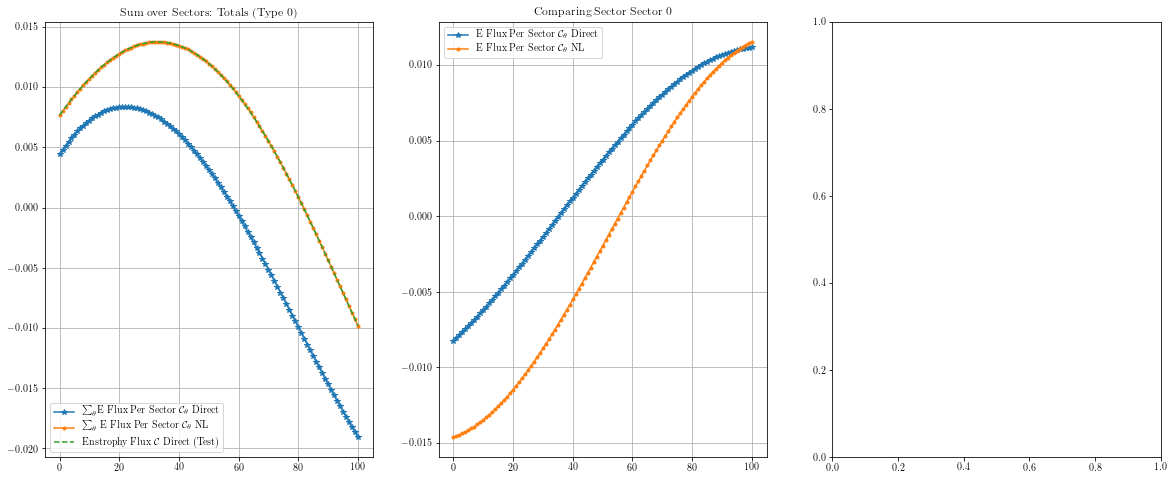

In [117]:
const_fac_sector = 4.0 * np.pi**2 
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

theta = 0 #int(post_data.num_sect // 2)
print(theta)

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 3)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, '*-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) * 2, '.-')
ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '--')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$ Direct (Test)"])

theta = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac_sector * norm_fac, '*-')
ax1.plot(post_data.enst_flux_C_theta[:, theta], '.-')
ax1.set_title(r"Comparing Sector Sector {}".format(theta))
ax1.grid()
ax1.legend([r"E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$"])


ax3 = fig.add_subplot(gs[0, 2])
# ax3.plot(post_data.enst_flux_per_sec[:, 0, 0] * const_fac_sector * norm_fac, '*-')
# ax3.plot(post_data.enst_flux_per_sec[:, 0, 1] * const_fac_sector * norm_fac, '*-')
# ax3.legend([r"Bottom", r"Top"])
# print(post_data.enst_flux_per_sec[:, 0, 0] / post_data.enst_flux_per_sec[:, 0, 1])
plt.show()

#### Triad Types Compare: Sectors vs All

[8.60721406e+11 8.44821201e+11 8.31225249e+11 8.19574876e+11
 8.09582267e+11 8.01013748e+11 7.93677584e+11 7.87414941e+11
 7.82093076e+11 7.77600159e+11 7.73841276e+11 7.70735313e+11
 7.68212503e+11 7.66212478e+11 7.64682708e+11 7.63577235e+11
 7.62855650e+11 7.62482249e+11 7.62425341e+11 7.62656669e+11
 7.63150928e+11 7.63885365e+11 7.64839436e+11 7.65994517e+11
 7.67333659e+11 7.68841375e+11 7.70503463e+11 7.72306847e+11
 7.74239443e+11 7.76290040e+11 7.78448199e+11 7.80704164e+11
 7.83048781e+11 7.85473428e+11 7.87969956e+11 7.90530634e+11
 7.93148097e+11 7.95815307e+11 7.98525513e+11 8.01272212e+11
 8.04049125e+11 8.06850162e+11 8.09669400e+11 8.12501060e+11
 8.15339484e+11 8.18179115e+11 8.21014482e+11 8.23840184e+11
 8.26650873e+11 8.29441243e+11 8.32206013e+11 8.34939923e+11
 8.37637716e+11 8.40294135e+11 8.42903909e+11 8.45461748e+11
 8.47962333e+11 8.50400312e+11 8.52770293e+11 8.55066836e+11
 8.57284454e+11 8.59417600e+11 8.61460670e+11 8.63407999e+11
 8.65253852e+11 8.669924

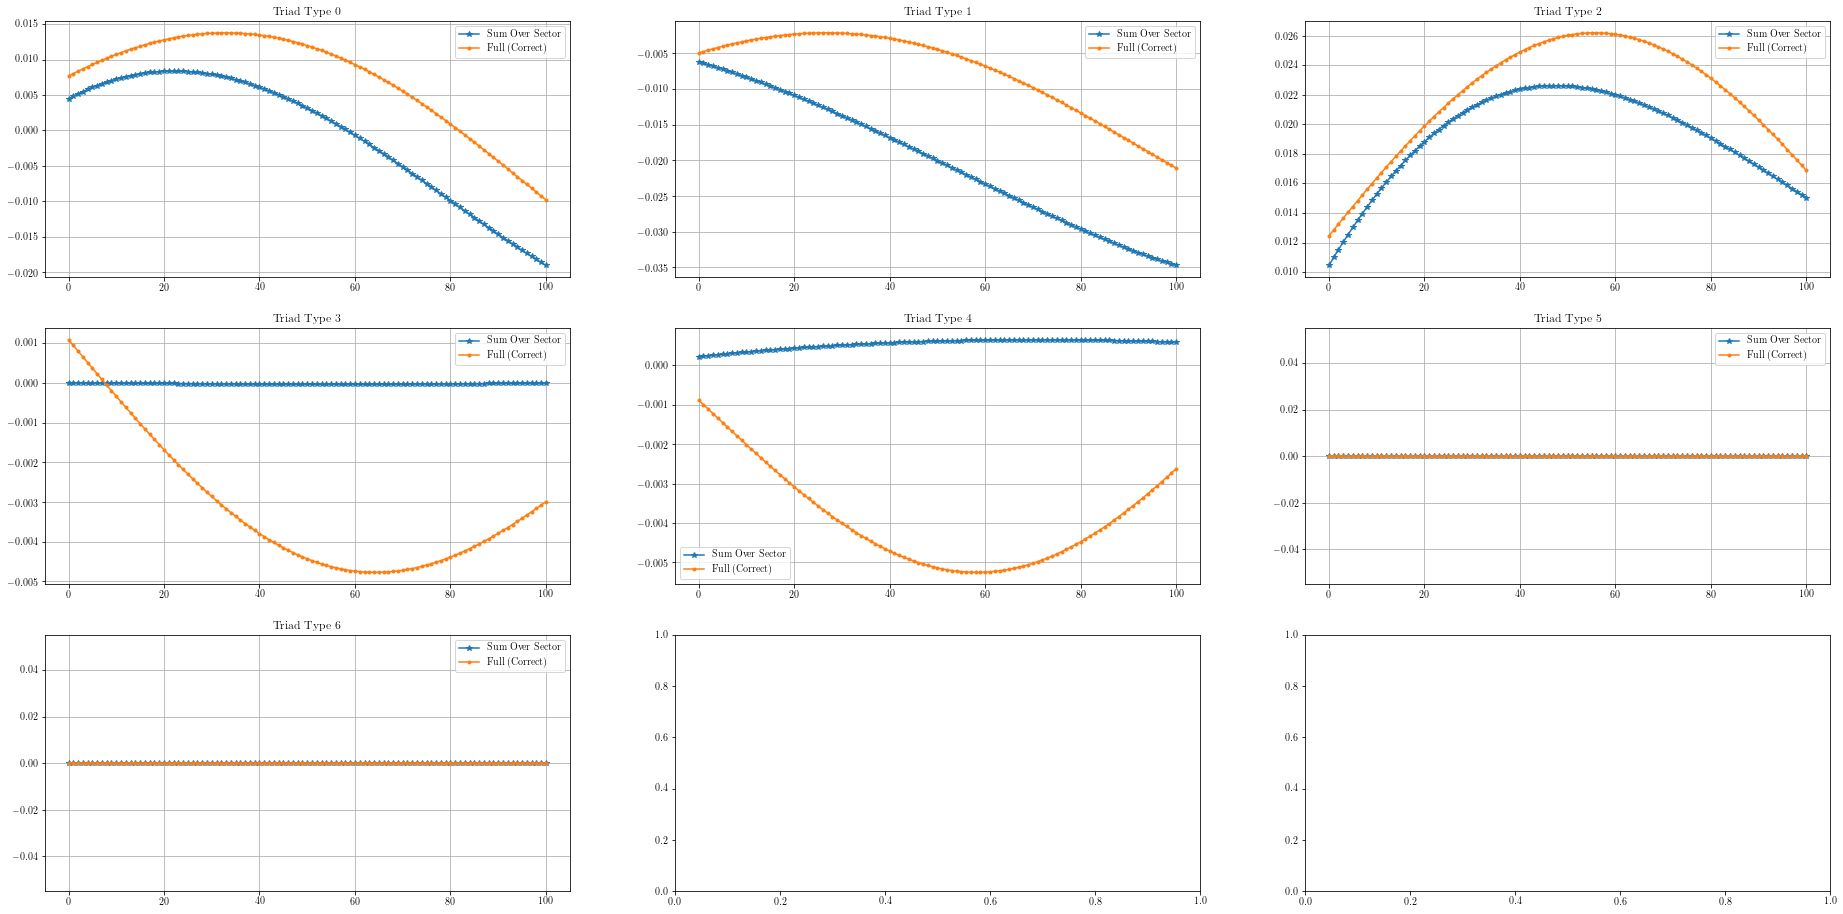

In [118]:
fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(3, 3)
ax1 = []
for i in range(3):
    for j in range(3):
        ax1.append(fig.add_subplot(gs[i, j]))
for i in range(post_data.enst_flux_per_sec.shape[1]):
    ax1[i].plot(np.sum(post_data.enst_flux_per_sec[:, i, :], axis = -1) * const_fac * norm_fac, '*-')
    ax1[i].plot(post_data.enst_flux_test[:, i] * const_fac * norm_fac, '.-')
    ax1[i].set_title(r"Triad Type {}".format(i))
#     ax1[i].set_xlim(-1, 20)
    ax1[i].legend([r"Sum Over Sector", r"Full (Correct)"])
    ax1[i].grid()
    if i == 2:
        print(1 / (np.sum(post_data.enst_flux_per_sec[:, i, :], axis = -1) * const_fac * norm_fac / post_data.enst_flux_test[:, i] * const_fac * norm_fac))
plt.show()


#### Compare Individual Sectors: Direct vs NL

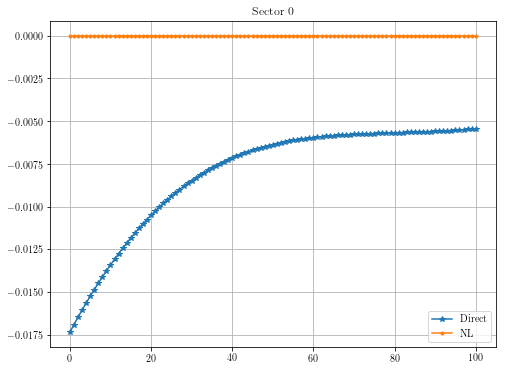

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


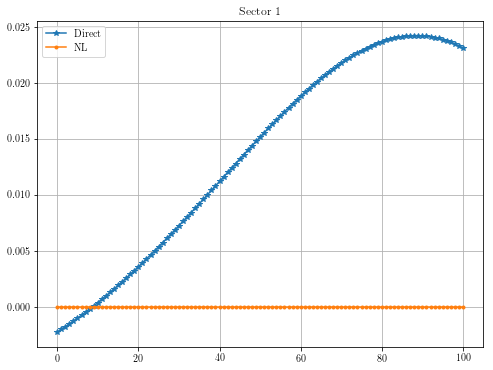

[-inf -inf -inf -inf -inf -inf -inf -inf -inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf]


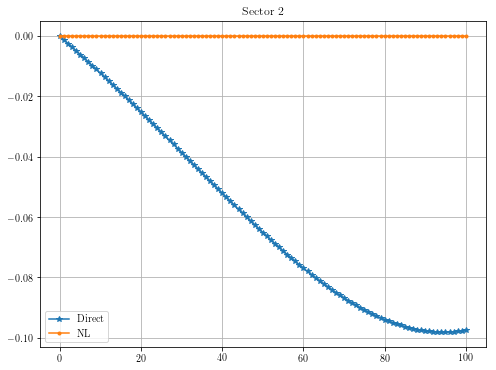

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


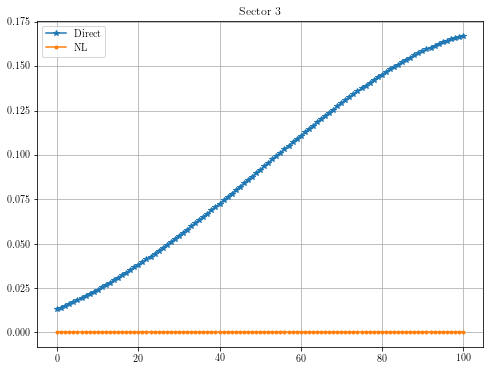

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf]


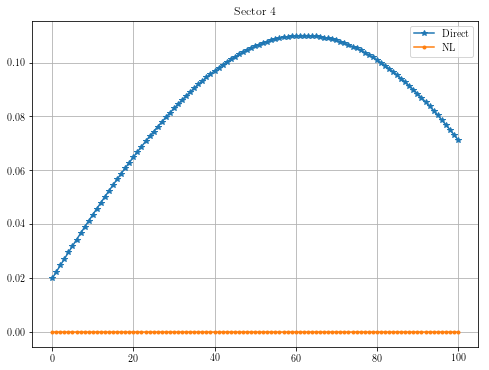

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf]


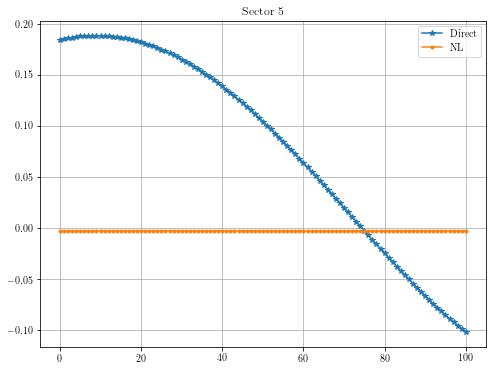

[-62.04601217 -62.46240073 -62.84266097 -63.18580861 -63.49088574
 -63.75696618 -63.98316088 -64.16862337 -64.31255517 -64.41421111
 -64.47290456 -64.48801247 -64.45898019 -64.38532607 -64.2666457
 -64.10261575 -63.89299752 -63.63763992 -63.33648203 -62.98955512
 -62.5969841  -62.15898843 -61.67588239 -61.1480748  -60.57606809
 -59.96045675 -59.30192527 -58.60124538 -57.85927283 -57.07694356
 -56.25526947 -55.39533365 -54.49828526 -53.565334   -52.59774434
 -51.59682941 -50.5639448  -49.50048211 -48.40786249 -47.28753011
 -46.14094569 -44.96958004 -43.77490781 -42.55840134 -41.3215247
 -40.06572806 -38.79244225 -37.50307363 -36.1989993  -34.88156268
 -33.55206934 -32.21178329 -30.86192356 -29.50366118 -28.13811647
 -26.7663567  -25.38939412 -24.00818423 -22.62362438 -21.23655271
 -19.84774726 -18.45792541 -17.06774346 -15.67779643 -14.28861809
 -12.90068102 -11.51439692 -10.13011687  -8.74813181  -7.36867296
  -5.99191229  -4.61796302  -3.24688003  -1.8786603   -0.51324318
   0.8494893

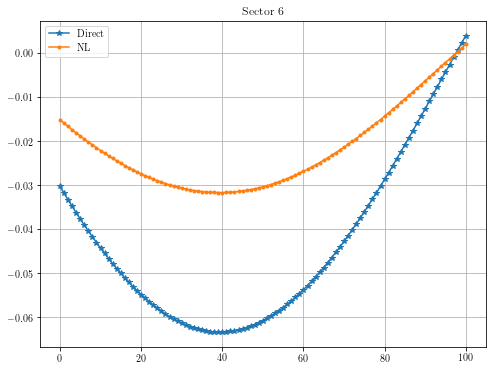

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2.]


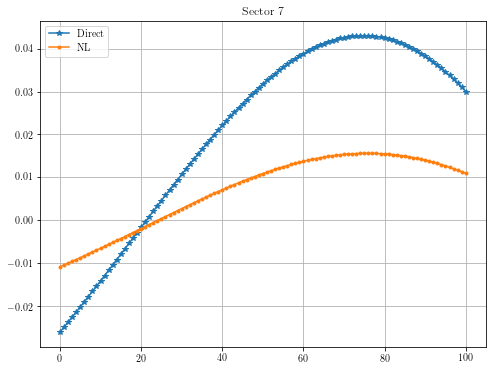

[  2.40735694   2.39108318   2.3736256    2.35481123   2.33443286
   2.31224007   2.28792735   2.26111807   2.23134249   2.19800703
   2.16035065   2.11738123   2.06778064   2.00975887   1.94082201
   1.85738862   1.75412421   1.62271913   1.4494783    1.21011484
   0.85705574   0.28273518  -0.81851633  -3.7956899  -41.38627423
  11.80697641   6.80274829   5.33616116   4.6348617    4.22334922
   3.95247395   3.76046037   3.6170991    3.50586861   3.41697164
   3.34423018   3.28355551   3.23213389   3.18796556   3.14959024
   3.11591674   3.08611329   3.05953479   3.03567323   3.01412315
   2.99455701   2.97670732   2.96035354   2.9453122    2.93142945
   2.9185753    2.90663924   2.89552668   2.88515623   2.87545747
   2.8663692    2.85783797   2.84981692   2.84226482   2.83514523
   2.82842589   2.8220781    2.81607633   2.81039773   2.80502187
   2.79993044   2.79510696   2.79053665   2.78620618   2.78210354
   2.77821794   2.77453964   2.7710599    2.76777086   2.7646655
   2.761737

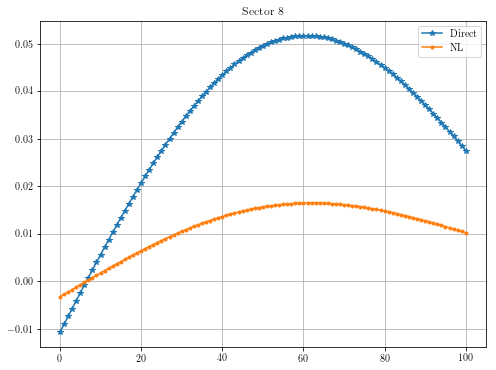

[3.27526708 3.2738409  3.27313182 3.27368562 3.27692337 3.28804473
 3.35327513 3.14359187 3.21160722 3.22318642 3.22685039 3.22791889
 3.22783598 3.2271547  3.22613164 3.22490151 3.22354134 3.22209794
 3.22060111 3.2190704  3.21751892 3.21595557 3.21438637 3.21281536
 3.21124514 3.20967724 3.2081124  3.20655077 3.20499199 3.20343533
 3.20187975 3.20032391 3.19876628 3.19720509 3.19563842 3.19406415
 3.19248002 3.19088359 3.1892723  3.18764339 3.185994   3.18432106
 3.18262138 3.18089156 3.17912805 3.1773271  3.17548476 3.17359689
 3.17165911 3.16966681 3.16761513 3.16549894 3.16331283 3.16105109
 3.15870768 3.15627622 3.15374995 3.15112173 3.14838398 3.14552868
 3.14254731 3.13943085 3.13616971 3.13275371 3.12917202 3.12541313
 3.12146479 3.11731397 3.11294678 3.10834842 3.10350312 3.09839403
 3.0930032  3.08731144 3.08129825 3.07494174 3.06821847 3.06110337
 3.05356963 3.0455885  3.0371292  3.02815873 3.01864169 3.00854013
 2.99781327 2.98641734 2.97430533 2.96142668 2.94772705 2.9331

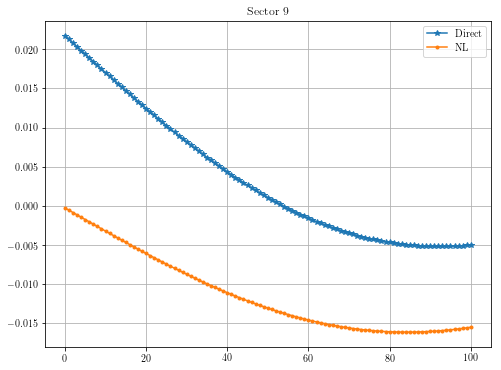

[-7.31346018e+01 -3.57258407e+01 -2.32760845e+01 -1.70566107e+01
 -1.33277346e+01 -1.08437351e+01 -9.07093776e+00 -7.74257304e+00
 -6.71046257e+00 -5.88571157e+00 -5.21175679e+00 -4.65089281e+00
 -4.17701786e+00 -3.77148911e+00 -3.42063598e+00 -3.11420616e+00
 -2.84436010e+00 -2.60500071e+00 -2.39131482e+00 -2.19945211e+00
 -2.02629590e+00 -1.86929635e+00 -1.72634726e+00 -1.59569363e+00
 -1.47586141e+00 -1.36560348e+00 -1.26385762e+00 -1.16971350e+00
 -1.08238646e+00 -1.00119663e+00 -9.25551954e-01 -8.54934538e-01
 -7.88889371e-01 -7.27015096e-01 -6.68956344e-01 -6.14397351e-01
 -5.63056604e-01 -5.14682340e-01 -4.69048731e-01 -4.25952646e-01
 -3.85210883e-01 -3.46657802e-01 -3.10143279e-01 -2.75530950e-01
 -2.42696683e-01 -2.11527248e-01 -1.81919159e-01 -1.53777665e-01
 -1.27015855e-01 -1.01553879e-01 -7.73182575e-02 -5.42412686e-02
 -3.22604077e-02 -1.13179060e-02  8.63969866e-03  2.76619448e-02
  4.57947902e-02  6.30809188e-02  7.95600169e-02  9.52690219e-02
  1.10242346e-01  1.24512

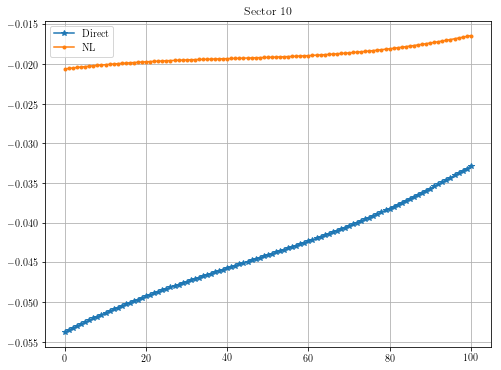

[2.60863893 2.60406574 2.59938054 2.59458558 2.58968319 2.58467585
 2.57956613 2.57435671 2.56905036 2.56364994 2.55815839 2.55257874
 2.54691407 2.54116753 2.53534233 2.52944173 2.523469   2.51742747
 2.51132048 2.5051514  2.4989236  2.49264044 2.48630531 2.47992154
 2.47349249 2.46702145 2.46051171 2.45396651 2.44738904 2.44078245
 2.43414984 2.42749423 2.4208186  2.41412583 2.40741877 2.40070016
 2.39397268 2.3872389  2.38050133 2.37376239 2.36702439 2.36028959
 2.35356011 2.346838   2.34012522 2.33342361 2.32673495 2.3200609
 2.31340302 2.3067628  2.30014161 2.29354074 2.2869614  2.28040467
 2.27387159 2.26736308 2.26087997 2.25442304 2.24799294 2.2415903
 2.23521561 2.22886932 2.2225518  2.21626336 2.21000423 2.20377456
 2.19757446 2.19140398 2.1852631  2.17915175 2.1730698  2.16701708
 2.16099338 2.15499842 2.1490319  2.14309348 2.13718276 2.13129934
 2.12544277 2.11961256 2.11380821 2.10802919 2.10227496 2.09654494
 2.09083854 2.08515517 2.07949422 2.07385505 2.06823705 2.062639

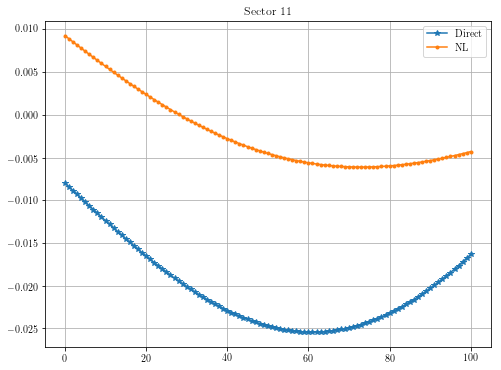

[  -0.86181626   -0.9478329    -1.04105746   -1.14234394   -1.25268757
   -1.37325527   -1.5054242    -1.65083136   -1.81143775   -1.98961269
   -2.18824581   -2.41089805   -2.66200854   -2.94718298   -3.27360357
   -3.65062501   -4.0906629    -4.61055687   -5.23373357   -5.99377604
   -6.94059628   -8.15173242   -9.75453113  -11.97379264  -15.24704487
  -20.55414538  -30.63488405  -57.16044425 -317.42647842   95.75556815
   42.85473187   28.11491613   21.19312547   17.17543992   14.55272379
   12.70711339   11.33870142   10.28432314    9.44759671    8.76792765
    8.20530982    7.73226611    7.32930005    6.98219468    6.68033898
    6.41565295    6.18187557    5.97408034    5.78833782    5.62147564
    5.47090467    5.33449094    5.21045994    5.09732406    4.99382694
    4.89890029    4.81163003    4.7312295     4.65701808    4.58840393
    4.52487005    4.46596289    4.4112829     4.36047682    4.31323119
    4.26926697    4.22833496    4.19021196    4.15469753    4.12161119
    4.

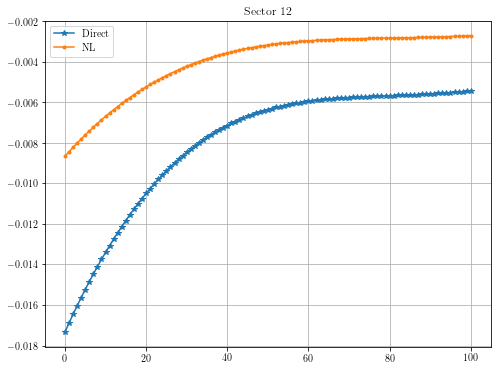

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2.]


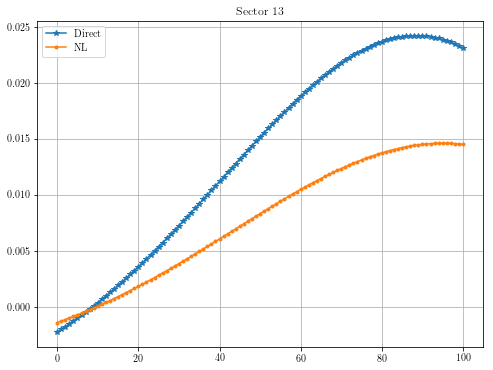

[ 1.61867454  1.60054987  1.57717535  1.54613787  1.50325676  1.44060285
  1.34108331  1.15982557  0.72911928 -1.57329887  4.67386376  2.80247771
  2.40585569  2.2337296   2.1376807   2.07647502  2.03410276  2.00304873
  1.97931819  1.96059153  1.9454295   1.93289175  1.92233784  1.91331653
  1.90550064  1.89864717  1.89257183  1.8871323   1.88221688  1.87773669
  1.87362006  1.86980858  1.86625411  1.8629166   1.85976245  1.85676323
  1.8538947   1.85113605  1.84846928  1.84587872  1.84335066  1.84087299
  1.83843502  1.83602717  1.83364087  1.83126839  1.82890271  1.82653743
  1.82416668  1.82178502  1.81938743  1.81696919  1.8145259   1.81205338
  1.80954765  1.80700494  1.80442159  1.80179408  1.799119    1.79639298
  1.79361275  1.79077506  1.78787669  1.78491443  1.78188506  1.77878538
  1.7756121   1.77236195  1.76903156  1.76561752  1.76211633  1.75852442
  1.75483811  1.75105359  1.74716695  1.74317414  1.73907094  1.734853
  1.73051575  1.72605447  1.7214642   1.71673978  1.7

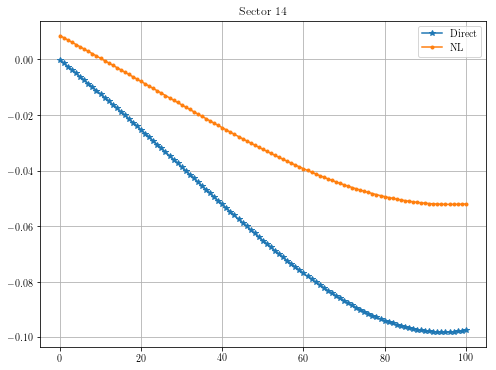

[-2.92439768e-02 -1.85166166e-01 -3.78311568e-01 -6.23580658e-01
 -9.45039283e-01 -1.38424726e+00 -2.01968600e+00 -3.01946830e+00
 -4.82043351e+00 -9.02250681e+00 -2.99653617e+01  3.32682802e+01
  1.20623433e+01  7.83930806e+00  6.03267496e+00  5.03068134e+00
  4.39425353e+00  3.95461340e+00  3.63302514e+00  3.38781455e+00
  3.19485817e+00  3.03922389e+00  2.91117394e+00  2.80408674e+00
  2.71330258e+00  2.63544702e+00  2.56801620e+00  2.50911302e+00
  2.45727377e+00  2.41135096e+00  2.37043228e+00  2.33378318e+00
  2.30080559e+00  2.27100756e+00  2.24398070e+00  2.21938312e+00
  2.19692641e+00  2.17636552e+00  2.15749095e+00  2.14012245e+00
  2.12410408e+00  2.10930027e+00  2.09559256e+00  2.08287695e+00
  2.07106179e+00  2.06006599e+00  2.04981750e+00  2.04025211e+00
  2.03131239e+00  2.02294684e+00  2.01510909e+00  2.00775734e+00
  2.00085375e+00  1.99436401e+00  1.98825694e+00  1.98250412e+00
  1.97707959e+00  1.97195963e+00  1.96712247e+00  1.96254812e+00
  1.95821819e+00  1.95411

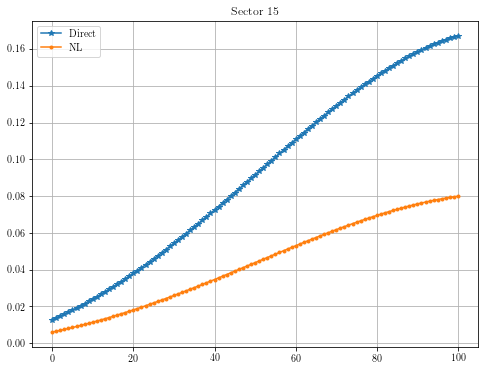

[2.12956395 2.1258966  2.12267272 2.11982308 2.11729164 2.11503259
 2.11300815 2.11118697 2.10954276 2.10805342 2.10670019 2.10546711
 2.1043405  2.1033086  2.10236123 2.10148957 2.10068595 2.09994365
 2.09925678 2.09862016 2.09802923 2.09747994 2.09696872 2.09649237
 2.09604806 2.09563325 2.09524566 2.09488326 2.09454422 2.09422688
 2.09392976 2.09365151 2.0933909  2.09314683 2.09291829 2.09270436
 2.09250419 2.09231703 2.09214216 2.09197894 2.09182678 2.09168513
 2.09155348 2.09143136 2.09131833 2.091214   2.09111799 2.09102994
 2.09094953 2.09087644 2.09081039 2.0907511  2.09069832 2.0906518
 2.09061132 2.09057664 2.09054757 2.09052391 2.09050546 2.09049204
 2.09048348 2.09047961 2.09048027 2.0904853  2.09049456 2.09050791
 2.0905252  2.09054629 2.09057107 2.09059941 2.09063117 2.09066626
 2.09070455 2.09074594 2.09079033 2.0908376  2.09088767 2.09094045
 2.09099583 2.09105375 2.09111412 2.09117687 2.09124192 2.09130921
 2.09137867 2.09145026 2.09152392 2.0915996  2.09167727 2.09175

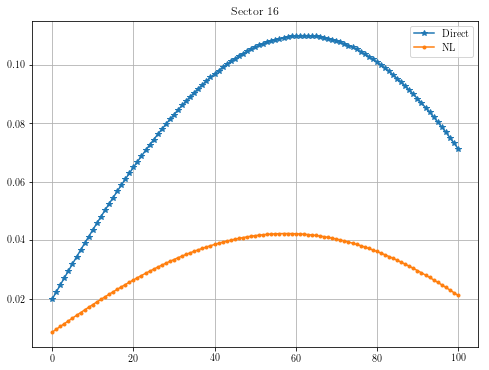

[2.31141812 2.3319111  2.34855156 2.36234041 2.37396389 2.38390837
 2.39252819 2.40008772 2.40678827 2.41278587 2.41820341 2.42313904
 2.42767213 2.43186765 2.43577929 2.4394519  2.44292326 2.44622545
 2.44938599 2.45242858 2.45537386 2.45823989 2.46104258 2.46379608
 2.466513   2.46920471 2.47188148 2.4745527  2.47722696 2.47991221
 2.48261583 2.48534474 2.48810546 2.49090417 2.49374678 2.49663897
 2.49958624 2.50259395 2.50566734 2.5088116  2.51203185 2.51533323
 2.51872087 2.52219995 2.52577572 2.52945352 2.5332388  2.53713717
 2.54115437 2.54529637 2.54956935 2.55397971 2.55853416 2.5632397
 2.56810365 2.57313374 2.57833806 2.58372519 2.58930417 2.59508459
 2.60107663 2.60729109 2.61373949 2.62043411 2.62738807 2.6346154
 2.64213115 2.64995147 2.65809372 2.66657661 2.67542031 2.68464662
 2.69427912 2.70434341 2.71486726 2.72588092 2.73741734 2.74951254
 2.76220595 2.77554079 2.78956463 2.80432983 2.81989428 2.83632207
 2.85368434 2.87206035 2.89153859 2.9122182  2.93421061 2.957641

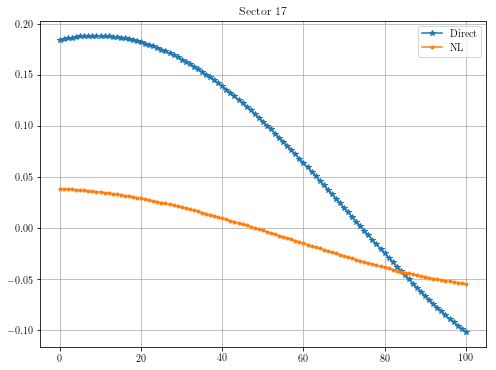

[ 4.79918868e+00  4.84728997e+00  4.89708208e+00  4.94868415e+00
  5.00222570e+00  5.05784787e+00  5.11570482e+00  5.17596536e+00
  5.23881480e+00  5.30445709e+00  5.37311730e+00  5.44504450e+00
  5.52051508e+00  5.59983674e+00  5.68335304e+00  5.77144886e+00
  5.86455692e+00  5.96316545e+00  6.06782748e+00  6.17917201e+00
  6.29791756e+00  6.42488879e+00  6.56103683e+00  6.70746465e+00
  6.86545859e+00  7.03652822e+00  7.22245701e+00  7.42536746e+00
  7.64780575e+00  7.89285305e+00  8.16427390e+00  8.46671685e+00
  8.80599016e+00  9.18944764e+00  9.62653940e+00  1.01296162e+01
  1.07151350e+01  1.14055200e+01  1.22321376e+01  1.32402464e+01
  1.44976470e+01  1.61107125e+01  1.82563665e+01  2.12521999e+01
  2.57309525e+01  3.31603925e+01  4.78990356e+01  9.12154680e+01
  2.92986322e+03 -9.03181698e+01 -4.27815392e+01 -2.72620823e+01
 -1.95594509e+01 -1.49543068e+01 -1.18898703e+01 -9.70290543e+00
 -8.06308370e+00 -6.78739645e+00 -5.76626600e+00 -4.93007362e+00
 -4.23246690e+00 -3.64138

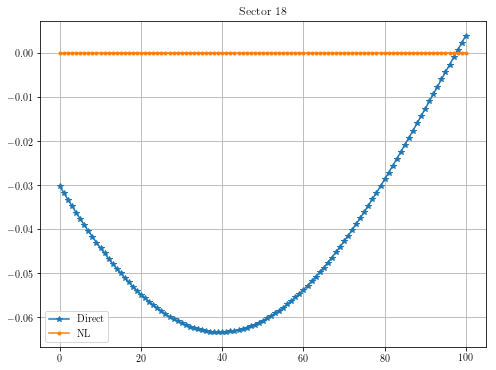

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  inf  inf  inf]


/home/ecarroll/ecpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


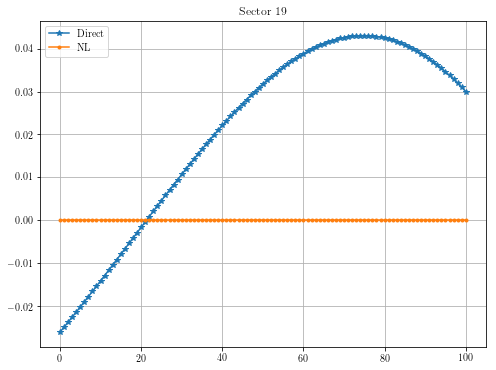

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf]


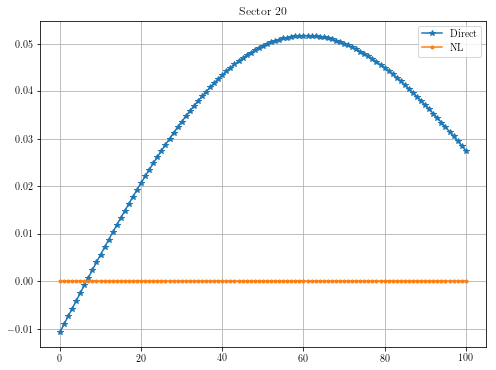

[-inf -inf -inf -inf -inf -inf -inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf]


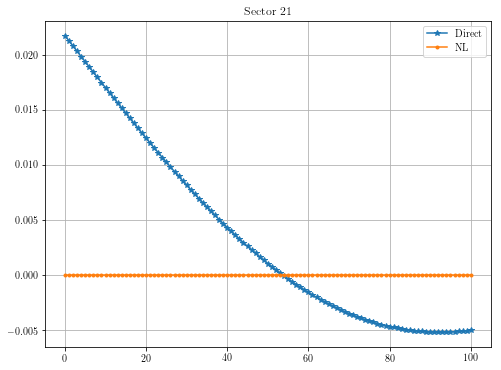

[ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


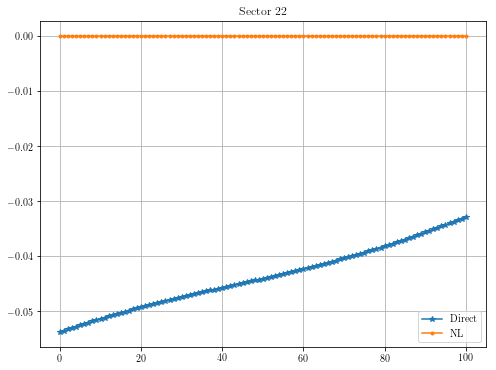

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


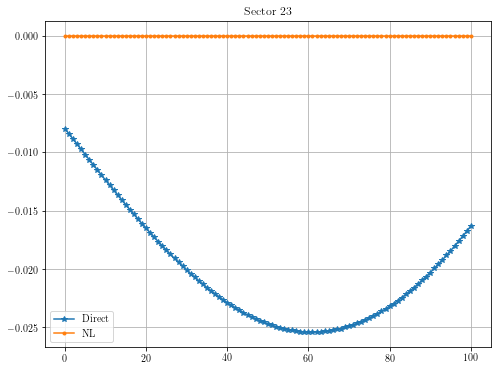

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


In [185]:
for a in range(post_data.num_sect):
    fig = plt.figure(figsize = (8, 6))
    gs  = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(post_data.enst_flux_per_sec[:, 0, a] * const_fac * norm_fac, '*-')
    ax.plot(post_data.enst_flux_C_theta[:, a], '.-')
    ax.set_title(r"Sector {}".format(a))
    ax.legend([r"Direct", r"NL"])
    ax.grid()
    plt.show()
    
    print(post_data.enst_flux_per_sec[:, 0, a] * const_fac * norm_fac / post_data.enst_flux_C_theta[:, a])

## Compare Enstorphy Flux Computed From Nonlinear Term and Directly - Ignoring Sectors

In [42]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

In [43]:
## Find the constant
print((post_data.enst_flux_test[:, 0] * const_fac * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
print()
print(const_fac)
print(norm_fac)
print(1 / (14000 * .29257143))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]

39.47841760435743
2.9802322387695312e-08
0.00024414062380790708


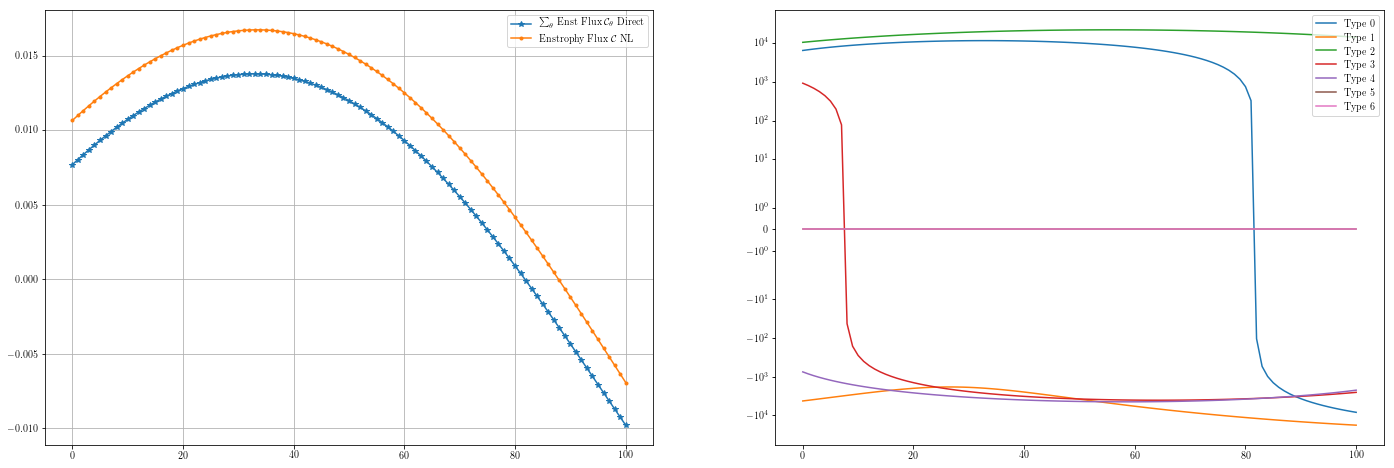

In [12]:
fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '*-')
ax1.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '.-')
# ax1.plot(post_data.enst_flux_C[:], '.-')
ax1.grid()
ax1.legend([r"$\sum_\theta$ Enst Flux $\mathcal{C}_\theta$ Direct", r"Enstrophy Flux $\mathcal{C}$ NL", r"Enstrophy Flux $\mathcal{C}$"])

ax2 = fig.add_subplot(gs[0, 1])
for i in range(post_data.triad_R_test.shape[1]):
    ax2.plot(post_data.enst_flux_test[:, i])
# ax2.set_yscale('log')
ax2.legend([r"Type {}".format(i) for i in range(post_data.triad_R_test.shape[1])])
ax2.set_yscale('symlog')
plt.show()

## Compare Both ways of computing Enstrophy Flux in C using Nonlinear term

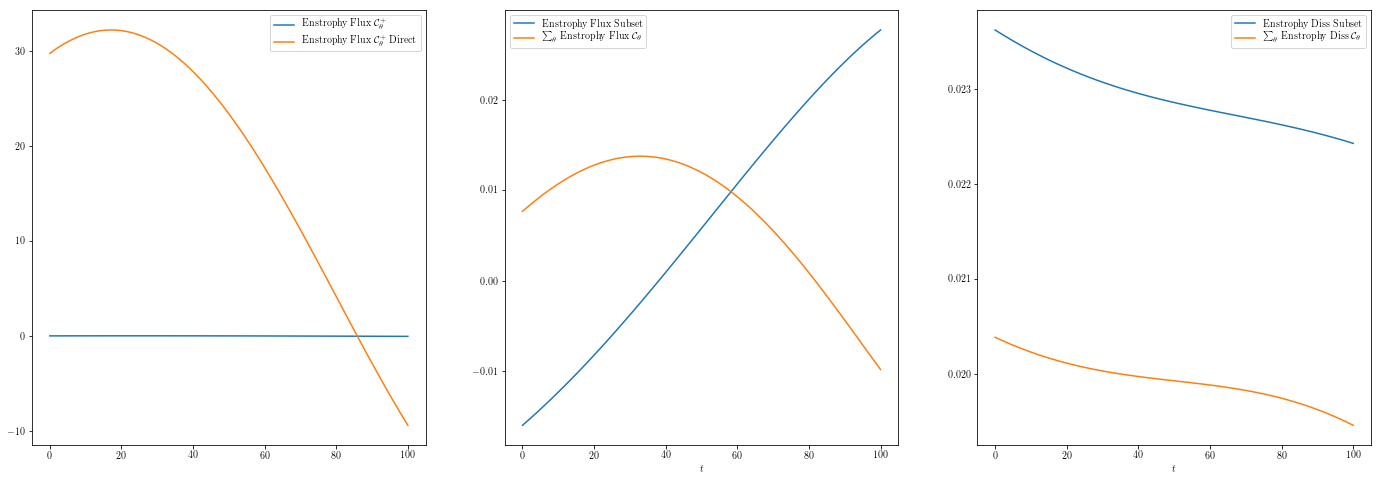

[1.15876909 1.15860161 1.15842815 1.15824883 1.15806378 1.15787315
 1.15767708 1.15747574 1.15726929 1.15705789 1.15684172 1.15662098
 1.15639585 1.15616654 1.15593325 1.15569619 1.15545558 1.15521164
 1.15496462 1.15471474 1.15446225 1.1542074  1.15395044 1.15369163
 1.15343124 1.15316954 1.1529068  1.15264331 1.15237934 1.15211518
 1.15185113 1.15158748 1.15132454 1.1510626  1.15080197 1.15054297
 1.1502859  1.15003109 1.14977884 1.14952948 1.14928334 1.14904074
 1.148802   1.14856745 1.14833743 1.14811227 1.1478923  1.14767785
 1.14746925 1.14726685 1.14707098 1.14688198 1.14670017 1.1465259
 1.14635951 1.14620132 1.14605167 1.14591091 1.14577935 1.14565734
 1.1455452  1.14544327 1.14535187 1.14527133 1.14520197 1.14514411
 1.14509808 1.14506419 1.14504275 1.14503409 1.1450385  1.14505629
 1.14508777 1.14513323 1.14519296 1.14526727 1.14535643 1.14546072
 1.14558043 1.14571582 1.14586716 1.14603471 1.14621873 1.14641948
 1.14663718 1.14687209 1.14712442 1.14739442 1.14768228 1.14798

In [55]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2
theta = int(post_data.num_sect // 2)

fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_C_theta[:, theta])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac * norm_fac)
ax1.legend([r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$", r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$ Direct"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enst_flux_C[:])
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
ax2.set_xlabel(r"$t$")
# ax2.set_xlim(-1, 20)
# ax2.set_yscale('log')
ax2.legend([r"Enstrophy Flux Subset", r"$\sum_\theta$ Enstrophy Flux $\mathcal{C}_\theta$", r"Total Enstrophy"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(post_data.enst_diss_C[:])
ax3.plot(np.sum(post_data.enst_diss_C_theta[:, :], axis = -1))
# ax3.set_yscale('log')
# ax3.set_xlim(-1, 5)
ax3.set_xlabel(r"$t$")
ax3.legend([r"Enstrophy Diss Subset", r"$\sum_\theta$ Enstrophy Diss $\mathcal{C}_\theta$", r"Total Enstrophy"])

plt.show()


print(post_data.enst_diss_C[:] / np.sum(post_data.enst_diss_C_theta[:, :], axis = -1))


## NOTE: There is a discrepency between the two methods because the way the spectrum index is computed you take the sqrt and round so some modes
## are included that aren't in C.

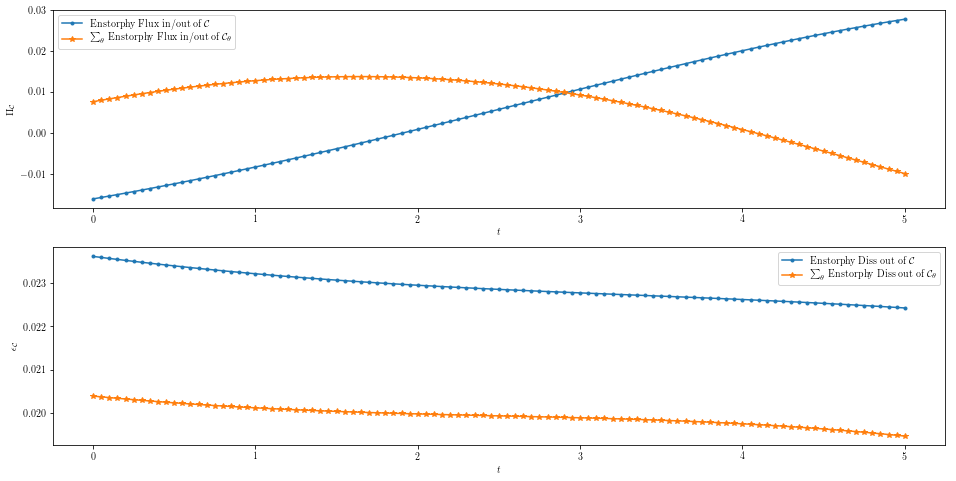

In [48]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(run_data.time, post_data.enst_flux_C[:], '.-')
ax1.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, 1:], axis = 1), '*-')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"Enstorphy Flux in/out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Flux in/out of $\mathcal{C}_\theta$"])
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(run_data.time, post_data.enst_diss_C[:], '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_diss_C_theta[:, 1:], axis = 1), '*-')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\epsilon_{\mathcal{C}}$")
ax2.legend([r"Enstorphy Diss out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Diss out of $\mathcal{C}_\theta$"])
plt.show()

## Compare Spectra Between Post & Solver 

In [50]:
 t = 50

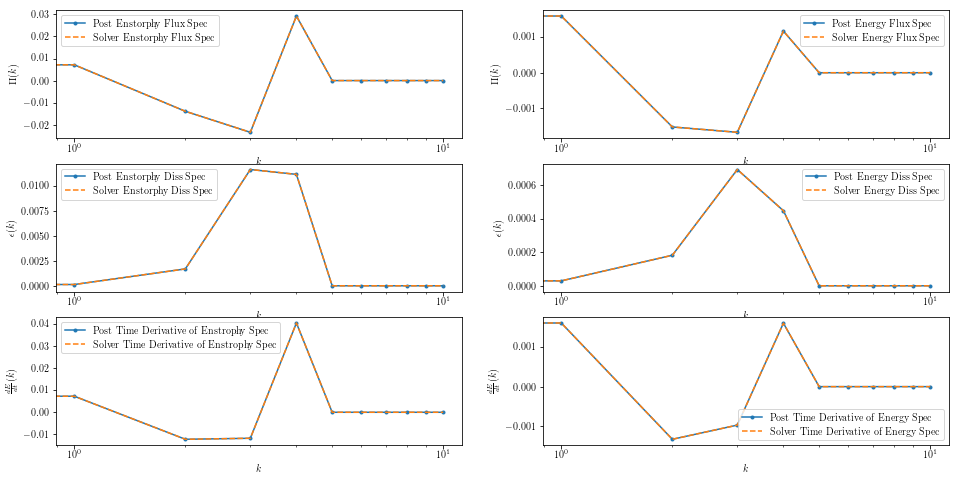

In [51]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_spec[t, 1:], '.-')
ax1.plot(spec_data.enst_flux_spectrum[t, 1:], '--')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\Pi(k)$")
ax1.set_xscale('log')
ax1.legend([r"Post Enstorphy Flux Spec", r"Solver Enstorphy Flux Spec"])
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enrg_flux_spec[t, 1:], '.-')
ax2.plot(spec_data.enrg_flux_spectrum[t, 1:], '--')
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$\Pi(k)$")
ax2.set_xscale('log')
ax2.legend([r"Post Energy Flux Spec", r"Solver Energy Flux Spec"])
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(post_data.enst_diss_spec[t, 1:], '.-')
ax3.plot(spec_data.enst_diss_spectrum[t, 1:] , '--')
ax3.set_xlabel(r"$k$")
ax3.set_ylabel(r"$\epsilon(k)$")
ax3.set_xscale('log')
ax3.legend([r"Post Enstorphy Diss Spec", r"Solver Enstorphy Diss Spec"])
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(post_data.enrg_diss_spec[t, 1:], '.-')
ax4.plot(spec_data.enrg_diss_spectrum[t, 1:] , '--')
ax4.set_xlabel(r"$k$")
ax4.set_ylabel(r"$\epsilon(k)$")
ax4.set_xscale('log')
ax4.legend([r"Post Energy Diss Spec", r"Solver Energy Diss Spec"])
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(post_data.d_enst_dt_spec[t, 1:], '.-')
ax5.plot(spec_data.d_enst_dt_spectrum[t, 1:] , '--')
ax5.set_xlabel(r"$k$")
ax5.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax5.set_xscale('log')
ax5.legend([r"Post Time Derivative of Enstrophy Spec", r"Solver Time Derivative of Enstrophy Spec"])
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(post_data.d_enrg_dt_spec[t, 1:], '.-')
ax6.plot(spec_data.d_enrg_dt_spectrum[t, 1:] , '--')
ax6.set_xlabel(r"$k$")
ax6.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax6.set_xscale('log')
ax6.legend([r"Post Time Derivative of Energy Spec", r"Solver Time Derivative of Energy Spec"])
plt.show()

## Compare Enstorphy Flux in C_theta - Combing 1D and 2D Contributions

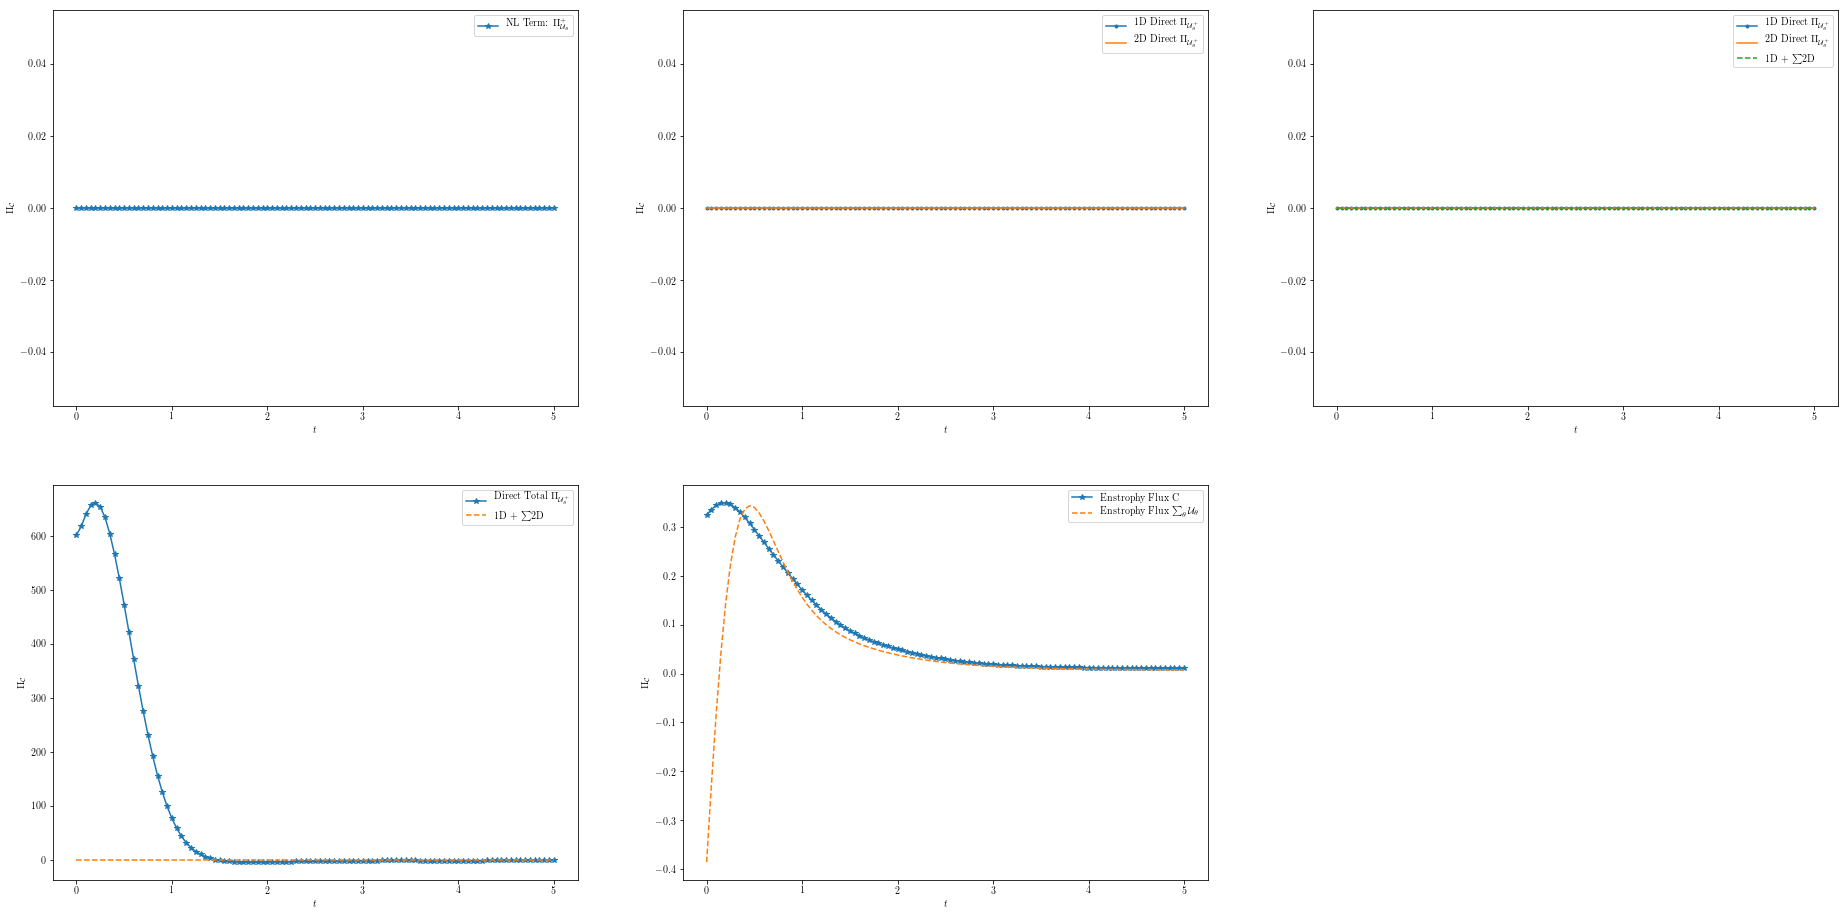

In [51]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2

theta = int(post_data.num_sect//2)

fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
# ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, theta],  '.-')
ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, -1], '*-' )
# ax1.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta], '*-') #  * norm_fac * const_fac / 10
# ax1.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
# ax1.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax1.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"NL Term: $\Pi_{\mathcal{U}_\theta}^{+}$", r"Direct Total $\Pi_{\mathcal{U}_\theta}^{+}$"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax2.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax2.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax3.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
ax3.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax3.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta] * norm_fac * const_fac / 10, '*-')
ax4.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax4.set_xlabel(r"$t$")
ax4.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax4.legend([r"Direct Total $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(run_data.time, post_data.enst_flux_C[:], '*-')
ax5.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '--')
ax5.set_xlabel(r"$t$")
ax5.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax5.legend([r"Enstrophy Flux C", r"Enstrophy Flux $\sum_\theta \mathcal{U}_\theta$"])
plt.show()

# r"$\Pi_{\mathcal{U}_\theta^{+}}$: Enstorphy Flux in/out of $\mathcal{U}_\theta^{+}$", 

[-0.00088895  0.0109422  -0.00081001 -0.00456419 -0.01642116  0.00076059
 -0.00779385  0.01451505 -0.03074954  0.05871409  0.02116911 -0.05182   ]
[ 0.          0.          0.          0.          0.          0.
 -0.00088895  0.0109422  -0.00081001 -0.00456419 -0.01642116  0.00076059
 -0.00779385  0.01451505 -0.03074954  0.05871409  0.02116911 -0.05182
 -0.00286549  0.          0.          0.          0.          0.        ]
[ 1.06478046e-02  1.09856502e-02  1.13154840e-02  1.16371252e-02
  1.19503962e-02  1.22551232e-02  1.25511356e-02  1.28382666e-02
  1.31163530e-02  1.33852354e-02  1.36447581e-02  1.38947694e-02
  1.41351216e-02  1.43656707e-02  1.45862772e-02  1.47968053e-02
  1.49971234e-02  1.51871044e-02  1.53666249e-02  1.55355662e-02
  1.56938136e-02  1.58412568e-02  1.59777900e-02  1.61033114e-02
  1.62177240e-02  1.63209349e-02  1.64128559e-02  1.64934032e-02
  1.65624973e-02  1.66200637e-02  1.66660320e-02  1.67003366e-02
  1.67229166e-02  1.67337157e-02  1.67326823e-02  1

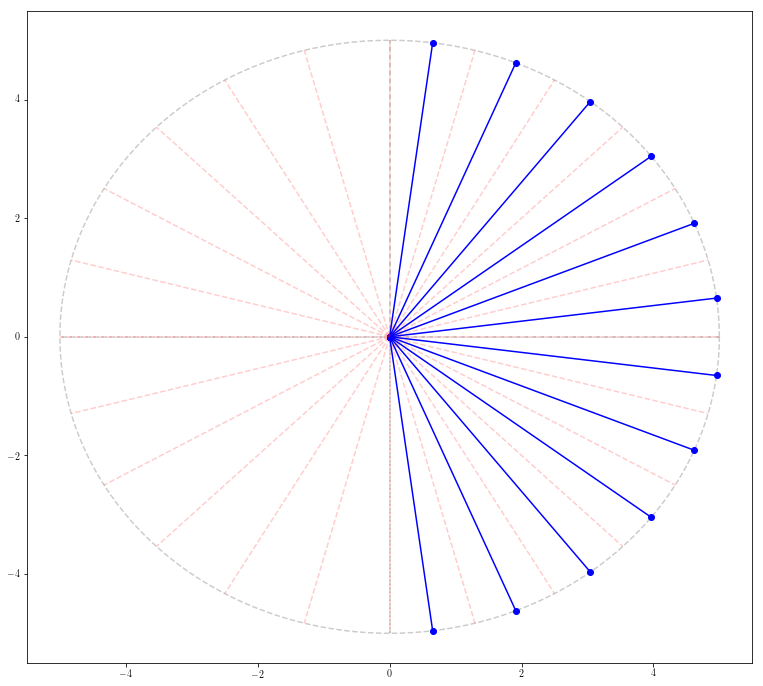

In [396]:
print(post_data.enst_flux_C_theta[-1, int(post_data.num_sect // 4):int(3 * post_data.num_sect // 4)])
print(post_data.enst_flux_C_theta[-1, :])
print(np.sum(post_data.enst_flux_C_theta[:, int(post_data.num_sect // 4):int(3 * post_data.num_sect // 4)], axis = -1))


n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

plt.figure(figsize = (13, 12))
plt.plot(x, y, 'k--', alpha = 0.2)
plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
for aa in range(post_data.num_sect):
    ## Plot sectors
    plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.1)
    plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.1)
#     if post_data.enst_flux_C_theta[-1, aa] != 0.0:
    if aa >= int(post_data.num_sect // 4) and aa < int(3 * post_data.num_sect // 4):
        plt.plot([0, R*np.cos(theta[aa])], [0, R*np.sin(theta[aa])], 'o-', alpha = 1, color = "b")
        

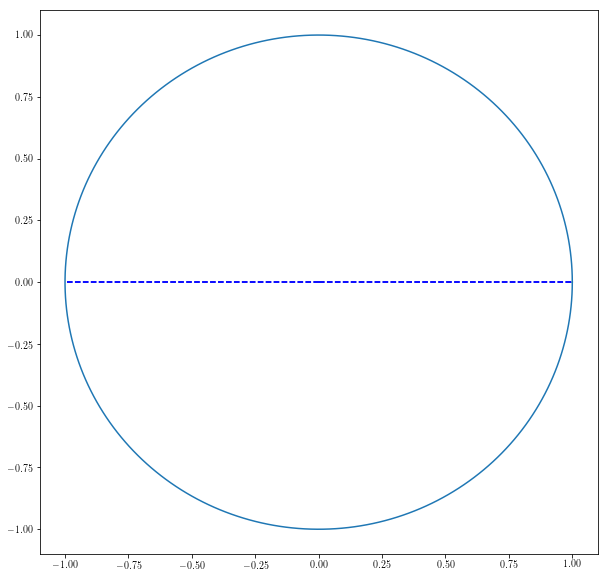

In [274]:
R = 1
angle = np.linspace(0.0, 2.0 * np.pi, 256)

x = R * np.cos(angle)
y = R * np.sin(angle)
dtheta = 2*np.pi/post_data.num_sect
fig = plt.figure(figsize = (10, 10))
plt.plot(x, y)
for i, a in enumerate(post_data.theta):
    plt.plot([0.0, R * np.cos(a - dtheta/2)], [0.0, R * np.sin(a - dtheta/2)], 'b--')
    plt.plot([0.0, R * np.cos(a + dtheta/2)], [0.0, R * np.sin(a + dtheta/2)], 'b--')    

In [38]:
Nx     = sys_vars.Nx
Ny     = sys_vars.Ny
kmax   = post_data.kmax
C_kmax = post_data.kmax_C

for k3_x in range(-Nx//2 + 1, Nx//2 + 1):
    for k3_y in range(-Nx//2 + 1, Nx//2 + 1):
        
        ## Compute polar data for k3
        k3_sqr = k3_x**2 + k3_y**2
        k3_ang = np.arctan2(k3_x, k3_y)
        k3_ang_neg = np.arctan2(-k3_x, -k3_y)
        
        if (k3_sqr > C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)
                    
        elif (k3_sqr <= C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)